Environment versions:
Matplotlib 3.7.1
Numpy 1.26.4
Pandas 2.2.1
Python 3.11.3
Seaborn 0.12.2
Sklearn 1.4.1
Wordcloud 1.9.3
Imbalanced-learn 0.12.2
NLTK 3.8.1
TextBlob 0.18.0
Tensorflow 2.12.0
Joblib 1.2.0

**Applied AI Project Assignment**

Colours for plots chosen based on:
Choosing Colormaps in Matplotlib — Matplotlib 3.8.1 documentation - colour guide 
https://matplotlib.org/stable/users/explain/colors/colormaps.html.

Using 'viridis' palette/colours throughout as colour blind friendly.

**Sentiment analysis of drug reviews**

This project will used supervised ML and deep learning approaches to classify sentiment of drug reviews.

The models explored are:

ML = RF and multinomialNB

Deep learning = GRU, LSTM and BiLSTM

The dataset is open source and available at:
https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler, SMOTE
import nltk
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import pickle
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from joblib import load, dump
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GRU, LSTM, Dense, Dropout, Flatten, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#Read in the data by first defining the data directory
#Use raw strings (prefixed with r) when dealing with Windows file paths to avoid issues with escape characters
data_dir = r'C:\Users\873958\OneDrive - hull.ac.uk\Applied Artificial Intelligence 771767\Assignment\drug+review+dataset+drugs+com'

In [3]:
#File paths for the train and test tsv files
train_file_path = data_dir + '\\drugsComTrain_raw.tsv'
test_file_path = data_dir + '\\drugsComTest_raw.tsv'

#Read the train and test files into dfs
#sep='\t' specifies that the files are tab separated in tsv
#The train and test split is 75%/25%
train_df = pd.read_csv(train_file_path, sep='\t')
test_df = pd.read_csv(test_file_path, sep='\t')

#Display the first few rows of each df to verify
print("Train DataFrame:")
display(train_df.head())

print("\nTest DataFrame:")
display(test_df.head())

Train DataFrame:


Unnamed: 0                  drugName                     condition  \
0      206461                 Valsartan  Left Ventricular Dysfunction   
1       95260                Guanfacine                          ADHD   
2       92703                    Lybrel                 Birth Control   
3      138000                Ortho Evra                 Birth Control   
4       35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   

                date  usefulCount  
0       May 20, 2012           27  
1     April 27, 2010          192  
2  December 14, 2009           17  
3   November 3, 2015           10  
4  November 27, 2016           37


Test DataFrame:


Unnamed: 0         drugName                     condition  \
0      163740      Mirtazapine                    Depression   
1      206473       Mesalamine  Crohn's Disease, Maintenance   
2      159672          Bactrim       Urinary Tract Infection   
3       39293         Contrave                   Weight Loss   
4       97768  Cyclafem 1 / 35                 Birth Control   

                                              review  rating  \
0  "I&#039;ve tried a few antidepressants over th...    10.0   
1  "My son has Crohn&#039;s disease and has done ...     8.0   
2                      "Quick reduction of symptoms"     9.0   
3  "Contrave combines drugs that were used for al...     9.0   
4  "I have been on this birth control for one cyc...     9.0   

                 date  usefulCount  
0   February 28, 2012           22  
1        May 17, 2009           17  
2  September 29, 2017            3  
3       March 5, 2017           35  
4    October 22, 2015            4

In [4]:
#Concatenate train_df and test_df
#Create new index for new df
combined_df = pd.concat([train_df, test_df], ignore_index=True)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215063 entries, 0 to 215062
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   215063 non-null  int64  
 1   drugName     215063 non-null  object 
 2   condition    213869 non-null  object 
 3   review       215063 non-null  object 
 4   rating       215063 non-null  float64
 5   date         215063 non-null  object 
 6   usefulCount  215063 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 11.5+ MB


There are only null values in the condition column.

Review and rating column are key to sentiment classification.

usefulCount indicates the weighting of how useful a review is serving as a proxy for the perceived quality or importance of the review.

**Project steps:**

1. Cleaning

2. Exploratory data analysis - at least 2 visualisations required (histograms, violin plots, scatter plots, word clouds, heat maps, and fish plots)

3. Balance classes - down- or over-sampling e.g. SMOTE. Might need dimensionality reduction?

4. Preprocessing

5. Split into training and test set (75/25)

6. Sub-sample training set (10%) for model optimisation

7. Build, train and test models

8. Two appropriate strategies for finetuning - out of hyperparameter tuning, transfer learning, and regularisation.

9. Each method/model is evaluated with at least two metrics. At least two appropriate visualisations are used to summarise the results. Examples are tables, heat maps, and confusion matrices. 

**Cleaning**

Already know there are no null values in any column except for condition.

In [5]:
#Convert rating column in combined_df to integer64 data type
combined_df['rating'] = combined_df['rating'].astype(np.int64)

In [6]:
#Convert date column to datetime object
combined_df['date'] = pd.to_datetime(combined_df['date'])

In [7]:
#Drop any empty rows
combined_df.dropna(inplace=True)

In [8]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213869 entries, 0 to 215062
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Unnamed: 0   213869 non-null  int64         
 1   drugName     213869 non-null  object        
 2   condition    213869 non-null  object        
 3   review       213869 non-null  object        
 4   rating       213869 non-null  int64         
 5   date         213869 non-null  datetime64[ns]
 6   usefulCount  213869 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 13.1+ MB


In [9]:
combined_df.head()

Unnamed: 0                  drugName                     condition  \
0      206461                 Valsartan  Left Ventricular Dysfunction   
1       95260                Guanfacine                          ADHD   
2       92703                    Lybrel                 Birth Control   
3      138000                Ortho Evra                 Birth Control   
4       35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9 2012-05-20   
1  "My son is halfway through his fourth week of ...       8 2010-04-27   
2  "I used to take another oral contraceptive, wh...       5 2009-12-14   
3  "This is my first time using any form of birth...       8 2015-11-03   
4  "Suboxone has completely turned my life around...       9 2016-11-27   

   usefulCount  
0           27  
1          192  
2           17  
3           10  
4           37

In [10]:
#Identify duplicate rows if there are any
duplicate_rows = combined_df[combined_df.duplicated()]
display(duplicate_rows)

Empty DataFrame
Columns: [Unnamed: 0, drugName, condition, review, rating, date, usefulCount]
Index: []

In [11]:
#Print unique rating values to check for outliers
rating_values = combined_df['rating'].unique()
print(rating_values)

[ 9  8  5  2  1 10  4  3  7  6]


There are no outliers in the rating column with ratings ranging from 1-10.

Only need to deal with nulls if looking at disease area...

**Data exploration**

In this section:

1. Rating distribution
2. Top 10 conditions with most reviews
3. Top 10 drugs with 1 and 10 ratings
4. Rating distribution for top 5 conditions only

**Rating distribution entire dataset**

1= poor
10 = excellent

In [12]:
#Define distribution plot function to take any x from df
def plot_distribution(df, x, xlabel='', ylabel='', label_map=None):
    """
    Plot the count of values in a specified column of a DataFrame.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    x (str): The name of the column to plot.
    x_label (str, optional): Label for the x-axis. Default is an empty string.
    y_label (str, optional): Label for the y-axis. Default is an empty string.
    label_map (dict, optional): Dictionary mapping numerical labels to corresponding string labels. Default is None.
    
    Returns:
    fig (matplotlib.figure.Figure): The figure object containing the plot.
    """
    fig = plt.figure()
    sns.countplot(data=df, x=x, palette='viridis')
    plt.xlabel(xlabel)
    if label_map:
        plt.xticks(ticks=range(len(label_map)), labels=[label_map[i] for i in range(len(label_map))], rotation=45, ha='right')
    plt.ylabel(ylabel)
    plt.tight_layout()
    return fig

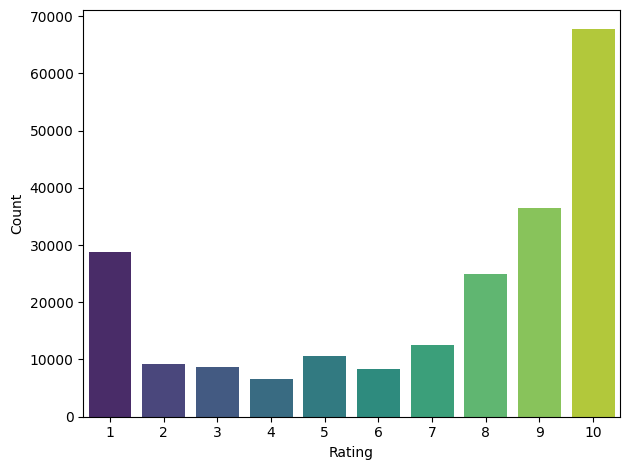

In [13]:
#Plot distribution of ratings for combined_df
rating_distribution = plot_distribution(combined_df, x='rating', xlabel='Rating', ylabel='Count')

There are more positive (8-10) reviews than negative (1-3) and more neutral reviews. Reviews are generally quite polarised, either strongly positive or negative.

**Top ten conditions distribution**

In [14]:
def plot_top_conditions(df, n=10, xlabel='', ylabel=''):
    """
    Plot the top N conditions by count.

    Parameters:
    data (DataFrame): The DataFrame containing the data.
    n (int, optional): Number of top conditions to plot. Default is 10.
    
    Returns:
    - fig (matplotlib.figure.Figure): The figure object containing the plot.
    """
    top_conditions = df['condition'].value_counts().head(n)
    fig = plt.figure(figsize=(10, 6))
    sns.barplot(x=top_conditions.index, y=top_conditions.values, palette='viridis')
    plt.xlabel(xlabel)
    plt.xticks(rotation=45, ha='right') 
    plt.ylabel(ylabel)
    plt.tight_layout()
    return fig

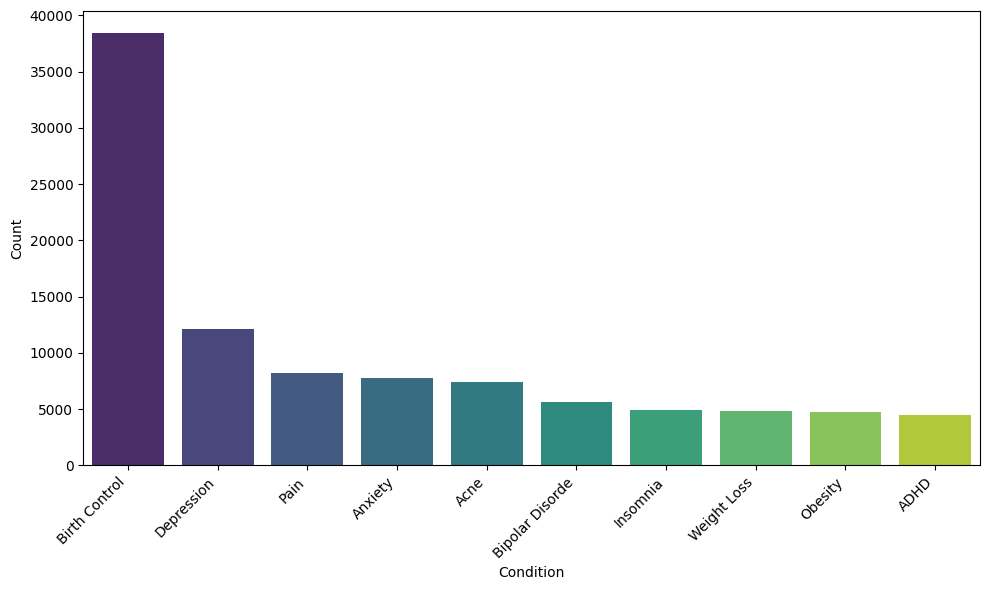

In [15]:
top_conditions_distribution = plot_top_conditions(combined_df, n=10, xlabel='Condition', ylabel='Count')

I am going to take a closer look at the top 5 diseases because they have a decent number of reviews between them and hopefully a good distribtuion of positive, negative and neutral reviews, to subsample and perform oversampling on to balance the classes for classification purposes.

**Top 10 drugs with 1 and 10 ratings**

In [16]:
#Function to plot top ten drugs by rating
def plot_top_drugs(df, rating=10, n=10, xlabel='', ylabel=''):
    """
    Plot the top N drugs with a specified rating.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    rating (int): The rating value to filter on. Default is 10.
    n (int, optional): Number of top drugs to plot. Default is 10.
    
    Returns:
    fig (matplotlib.figure.Figure): The figure object containing the plot.
    """
    top_drugs = df[df['rating'] == rating]['drugName'].value_counts().head(n)
    fig = plt.figure(figsize=(10, 6))
    sns.barplot(x=top_drugs.index, y=top_drugs.values, palette='viridis')
    plt.xlabel('Count')
    plt.ylabel('Drug Name')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    return fig

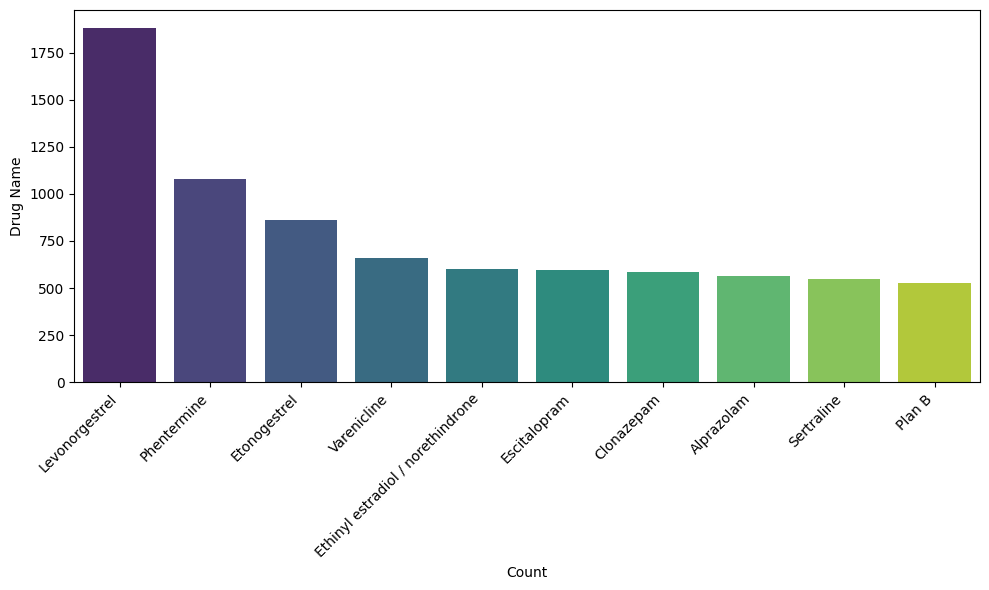

In [17]:
#Display top ten drugs with 10 rating
top_ten_drugs_10_rating = plot_top_drugs(combined_df, xlabel='Drug Name', ylabel='Count')

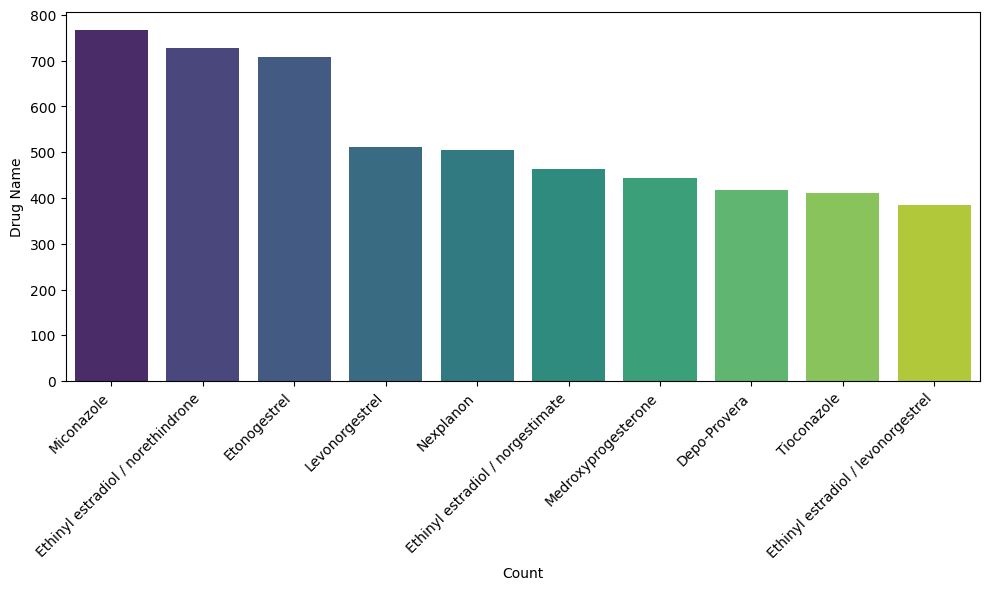

In [18]:
#Display top ten drugs with 1 rating
top_ten_drugs_1_rating = plot_top_drugs(combined_df, rating=1, xlabel='Drug Name', ylabel='Count')

Of particular note is that Levonorgestrel, etonogestrel and ethinyl estaradiol/norethindrone are featured high up in the top ten with both a 1 and 10 rating so reviews are very polarised for these birth control drugs, working well for some women, but not for others.

In [19]:
#Get the top 5 diseases by count
top_diseases = combined_df['condition'].value_counts().head(5).index.tolist()

#Filter combined_df to include only reviews associated with these diseases
filtered_df = combined_df[combined_df['condition'].isin(top_diseases)]

#Create a new df with these reviews
top_five_diseases_df = filtered_df[['condition', 'drugName', 'review', 'rating']].copy()

#Reset the index of top_five_diseases_df
top_five_diseases_df.reset_index(drop=True, inplace=True)

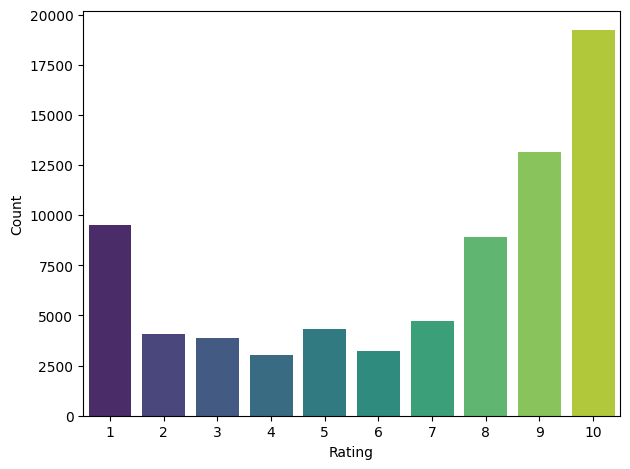

In [20]:
#Plot distribution of ratings for top_five_diseases_df
rating_distribution_top_five_diseases = plot_distribution(top_five_diseases_df, x='rating', xlabel='Rating', ylabel='Count')

There is still a good distribution of reviews across all ratings so this sample of the dataset should be good for oversampling and training a classifier on. Will test how well it generalises to subsampled test set and entire data test set based on 75/25 split.

**Review length standardisation**

There may be some review length outliers that can be removed to standardise review length for classification.

This has been performed by others on this dataset:

Basiri, M. E., Abdar, M., Cifci, M. A., Nemati, S. & Acharya, U. R. (2020) A novel method for sentiment classification of drug reviews using fusion of deep and machine learning techniques. Knowledge-Based Systems, 198, 105949.

In [21]:
#from matplotlib.ticker import AutoMinorLocator
def boxplot_review_length(df, color_index=4):
    """
    Plots the distribution of review lengths in the given DataFrame using Seaborn.

    Parameters:
    df (DataFrame): The DataFrame containing the 'review' column.

    Returns:
    fig: The matplotlib figure object.
    """
    #Calculate the length of each review
    review_lengths = df['review'].apply(len)
    
    #Plot the distribution of review lengths
    fig = plt.figure(figsize=(10, 6))
    sns.boxplot(y=review_lengths, color=sns.color_palette('viridis')[color_index])
    #Set minor ticks
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.ylabel('Review Length')
    plt.tight_layout()
    
    return fig

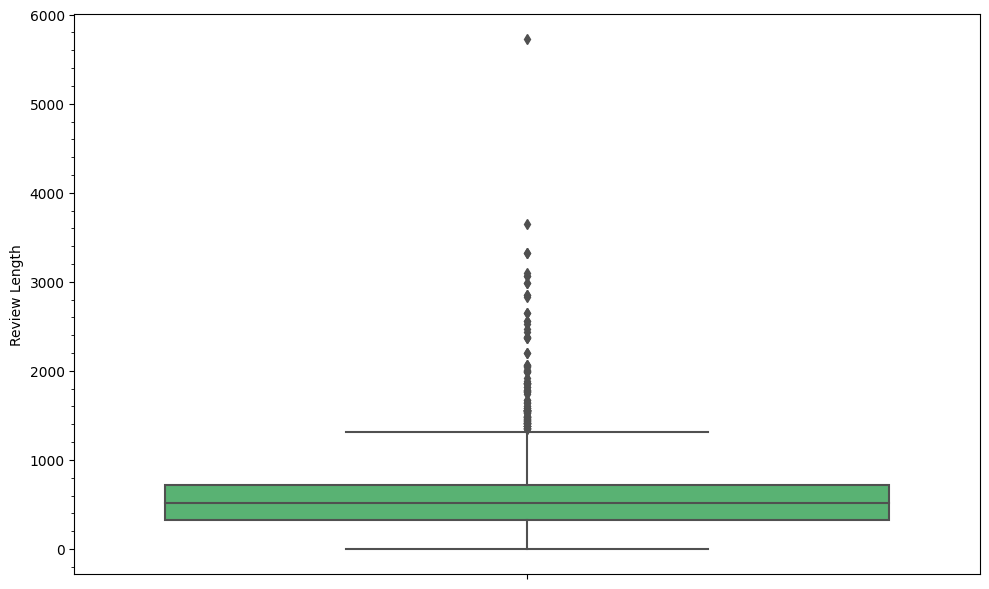

In [22]:
#Plot boxplot of review lengths in top_five_diseases_df
review_length_top_five_diseases_df = boxplot_review_length(top_five_diseases_df)

In [23]:
#Only keep reviews below 1400 length
top_five_diseases_df_updated = top_five_diseases_df[top_five_diseases_df['review'].apply(len) < 1400]
top_five_diseases_df_updated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73993 entries, 0 to 74091
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   condition  73993 non-null  object
 1   drugName   73993 non-null  object
 2   review     73993 non-null  object
 3   rating     73993 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


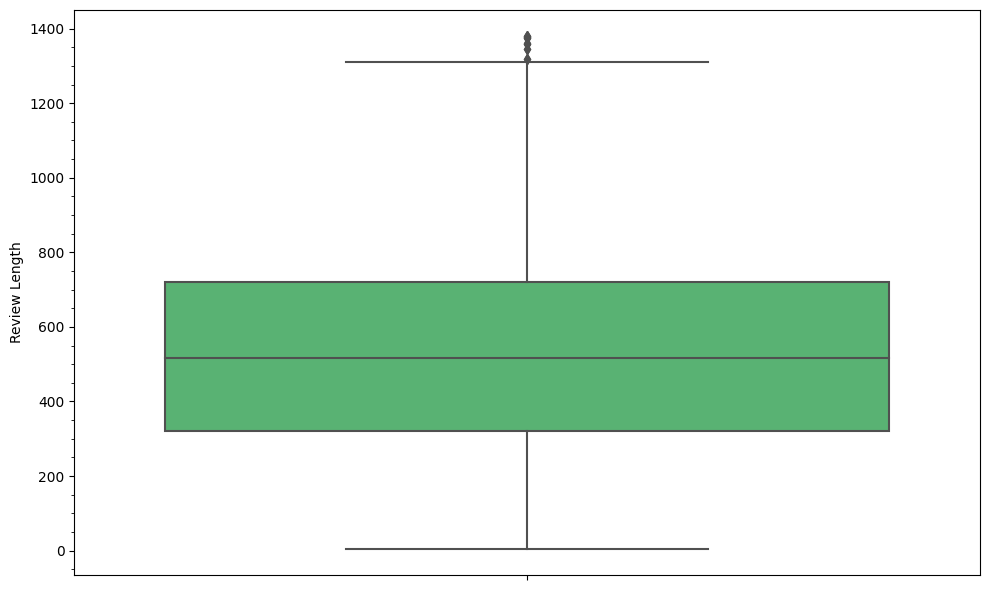

In [24]:
#Plot boxplot of review lengths in top_five_diseases_df_updated
review_length_top_five_diseases_df_updated = boxplot_review_length(top_five_diseases_df_updated)

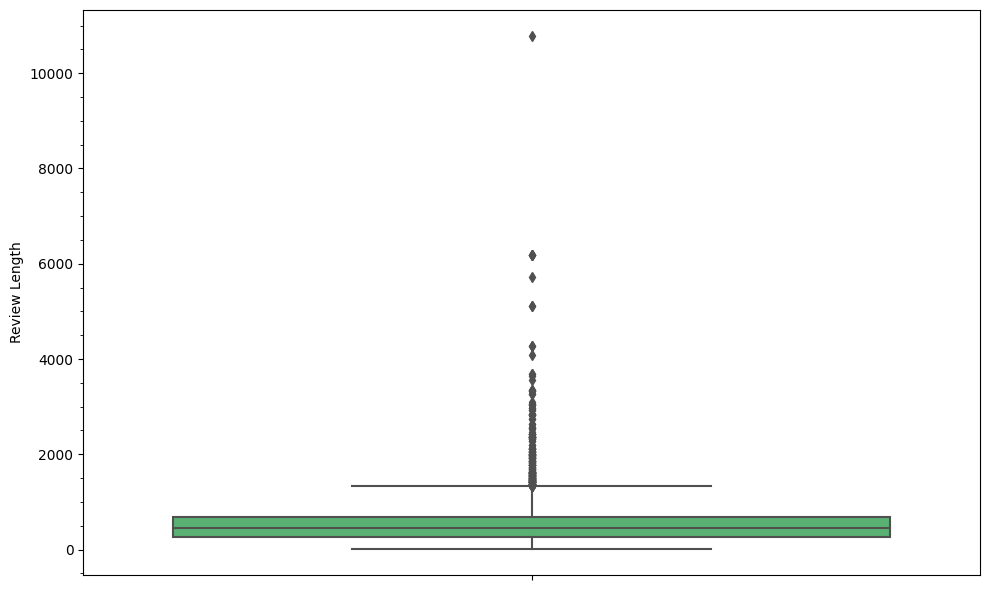

In [25]:
#Plot boxplot of review lengths in combined_df
review_length_combined_df = boxplot_review_length(combined_df)

In [26]:
#Only keep reviews below 1400 length
combined_df_updated = combined_df[combined_df['review'].apply(len) < 1400]
combined_df_updated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213673 entries, 0 to 215062
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Unnamed: 0   213673 non-null  int64         
 1   drugName     213673 non-null  object        
 2   condition    213673 non-null  object        
 3   review       213673 non-null  object        
 4   rating       213673 non-null  int64         
 5   date         213673 non-null  datetime64[ns]
 6   usefulCount  213673 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 13.0+ MB


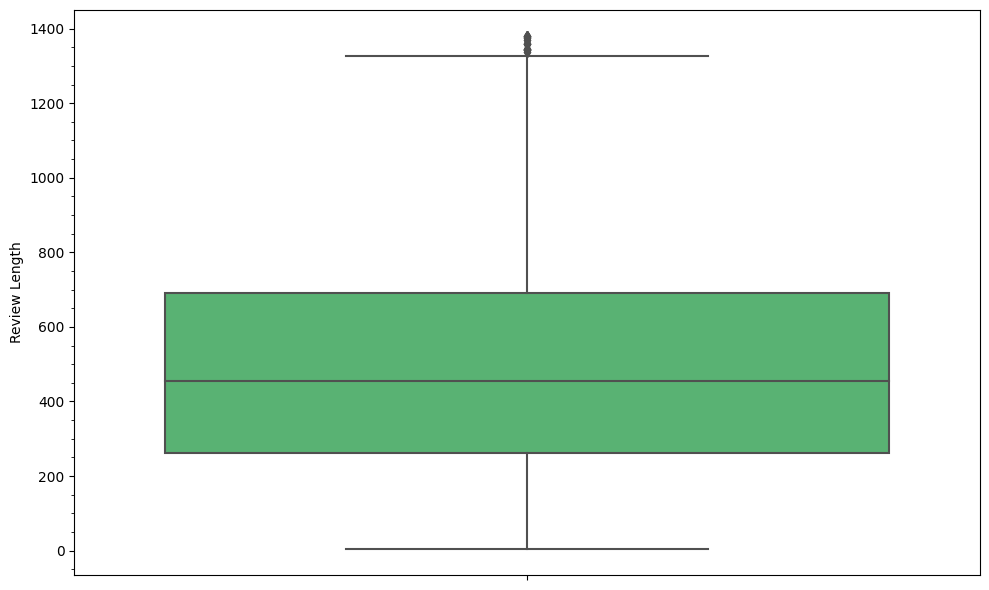

In [27]:
#Plot boxplot of review lengths in combined_df_updated
review_length_combined_df_updated = boxplot_review_length(combined_df_updated)

**Sentiment labelling for classification**

Perform for entire dataset combined_df_updated (to be downsampled) and top_five_diseases_df_updated (to be oversampled).

The following classifications are assigned.
0: Negative 
1: Neutral 
2: Positive

Positive is rating 7-10, Neutral is 5,6, Negative is 1-4 (in line with what others have done in literature).

In [28]:
#Apply sentiment classifier labels to top_five_diseases_df 
#Label pos as 2, neutral as 1 and negative as 0 for classification using ML and DL models
#Positive is rating 7-10, Neutral is 5,6, Negative is 1-4 (in line with what others have done in literature)
def label_sentiment(rating):
    """
    Label sentiment based on the rating.
    
    Parameters:
    rating (int): The rating of the review.
    
    Returns:
    int: The sentiment label (0 for negative, 1 for neutral, 2 for positive).
    """
    if rating >= 7:
        return 2  #Positive
    elif rating == 5 or rating == 6:
        return 1  #Neutral
    else:
        return 0  #Negative

In [29]:
top_five_diseases_df_updated = top_five_diseases_df_updated.copy()
top_five_diseases_df_updated['sentiment_class'] = top_five_diseases_df_updated['rating'].apply(label_sentiment)
top_five_diseases_df_updated.head()

condition                            drugName  \
0  Birth Control                              Lybrel   
1  Birth Control                          Ortho Evra   
2  Birth Control  Ethinyl estradiol / levonorgestrel   
3     Depression                      L-methylfolate   
4  Birth Control                           Nexplanon   

                                              review  rating  sentiment_class  
0  "I used to take another oral contraceptive, wh...       5                1  
1  "This is my first time using any form of birth...       8                2  
2  "I had been on the pill for many years. When m...       8                2  
3  "I have taken anti-depressants for years, with...      10                2  
4  "Started Nexplanon 2 months ago because I have...       3                0

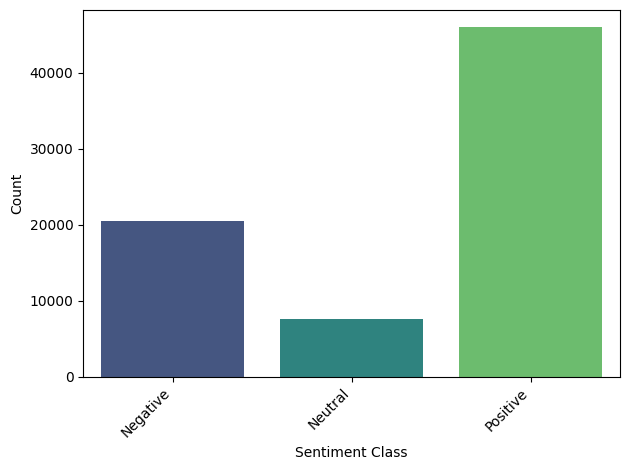

In [30]:
#Define custom label map for plotting
custom_label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

#Plot distribution of sentiment class for top_five_diseases_df_updated
class_distribution_top_five_diseases = plot_distribution(top_five_diseases_df_updated, x='sentiment_class', xlabel='Sentiment Class', ylabel='Count', label_map=custom_label_map)

In [31]:
def calculate_sentiment_proportions(df, class_column='sentiment_class'):
    """
    Calculate the percentage proportions of sentiment classes in a DataFrame.

    Parameters:
    df (DataFrame): The DataFrame containing the sentiment classes.
    class_column (str, optional): The name of the column containing the sentiment classes. Default is 'sentiment_class'.
    
    Returns:
    percentage_proportions (Series): The percentage proportions of sentiment classes.
    """
    #Calculate the value counts of sentiment classes in df
    sentiment_counts = df[class_column].value_counts()

    #Calculate the total number of samples
    total_samples = sentiment_counts.sum()

    #Calculate the percentage proportions to 2dp
    percentage_proportions = (sentiment_counts / total_samples) * 100
    percentage_proportions = percentage_proportions.round(2)

    return percentage_proportions

In [32]:
#Calculate percentage sentiment proportions for top_five_diseases_df_updated
percentage_proportions_top_five_diseases_df_updated = calculate_sentiment_proportions(top_five_diseases_df_updated)
print("Percentage Proportions of Sentiment Classes in top_five_diseases_df_updated:")
print(percentage_proportions_top_five_diseases_df_updated)

Percentage Proportions of Sentiment Classes in top_five_diseases_df_updated:
sentiment_class
2    62.14
0    27.62
1    10.24
Name: count, dtype: float64


In [33]:
#Make a copy of the combined_df_updated
combined_df_updated = combined_df_updated.copy()
#Apply the label_sentiment function to create a new 'sentiment_class' column in the copy
combined_df_updated['sentiment_class'] = combined_df_updated['rating'].apply(label_sentiment)

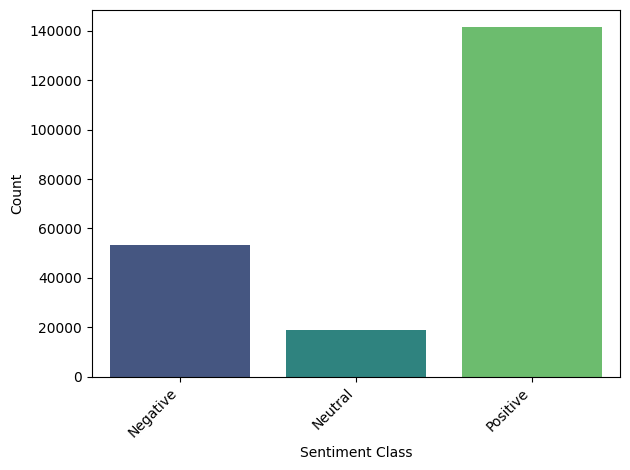

In [34]:
#Plot distribution of sentiment class for combined_df_updated
class_distribution_combined_df_updated = plot_distribution(combined_df_updated, x='sentiment_class', xlabel='Sentiment Class', ylabel='Count', label_map=custom_label_map)

In [35]:
#Calculate percecntage sentiment proportions for combined_df_updated
percentage_proportions_combined_df_updated = calculate_sentiment_proportions(combined_df_updated)
print("Percentage Proportions of Sentiment Classes in combined_df_updated:")
print(percentage_proportions_combined_df_updated)

Percentage Proportions of Sentiment Classes in combined_df_updated:
sentiment_class
2    66.19
0    24.90
1     8.91
Name: count, dtype: float64


The class distribution proportions of the top 5 disease df updated and entire combined df updated are roughly the same with most reviews positive, fewer negative and the least neutral.

**Class balance**

The datasets are highly imbalanced.

This imbalance will effect both feature selection and model training, so will determine effect of unbalanced and balanced data on feature seletion and for running any classifiers.

Techniques I can try are:

Oversampling of top_five_diseases_df_updated: Increase the number of instances in the minority classes (negative and neutral) by data augmentation (randomly applying transformations to create new instances (random oversampling)), or using SMOTE or ADASYN (applied after vectorisation to convert text to vectors as these oversampling techniques can only be used on numerical values).

Downsampling of combined_df_updated: Decrease the number of instances in the positive and negative classes by randomly removing instances.

The problem with down-sampling combined_df_updated is that it significantly decreases the dataset size which will reduce the amount available for training which could decrease performance and could lead to overfitting. This will be determined by looking at accuracy and classification peformance of test data to determine generalisation.

Random oversampling can also cause overfitting. This will also be determined.

*Downsampling*

Applying to negative and positive classes for combined_df_updated (entire df)

In [36]:
#Function to randomly downsample positive and negative classes in combined_df
def downsample_sentiment_classes(df, class_column='sentiment_class', random_state=42):
    """
    Downsample the neutral (class 0) and positive (class 2) sentiment classes in the DataFrame to balance it.

    Parameters:
    df (DataFrame): The DataFrame containing the sentiment classes.
    class_column (str, optional): The name of the column containing the sentiment classes. Default is 'sentiment_class'.
    random_state (int, optional): Random seed for reproducibility. Default is 42.
    
    Returns:
    balanced_df (DataFrame): The balanced DataFrame with downsampled sentiment classes.
    """
    #Separate df into three dfs based on sentiment class
    class_0_df = df[df[class_column] == 0]
    class_1_df = df[df[class_column] == 1]
    class_2_df = df[df[class_column] == 2]

    #Calculate the minimum number of samples among the three classes
    min_samples = min(len(class_0_df), len(class_1_df), len(class_2_df))

    #Randomly downsample the class 0 and class 2 dfs to match the number of samples in class_1_df
    class_0_downsampled = class_0_df.sample(n=min_samples, random_state=random_state)
    class_2_downsampled = class_2_df.sample(n=min_samples, random_state=random_state)

    #Concatenate the downsampled dfs with class_1_df
    balanced_df = pd.concat([class_1_df, class_0_downsampled, class_2_downsampled])

    #Shuffle df to mix the rows
    balanced_df = balanced_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    return balanced_df

In [37]:
#Apply downsampling function to combined_df
downsampled_df = downsample_sentiment_classes(combined_df_updated)

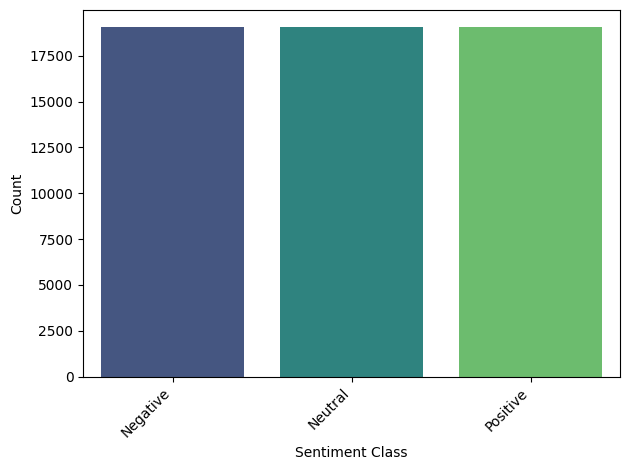

In [38]:
#Plot distribution of sentiment class for downsampled_df
class_distribution_downsampled_df = plot_distribution(downsampled_df, x='sentiment_class', xlabel='Sentiment Class', ylabel='Count', label_map=custom_label_map)

In [39]:
#Calculate percecntage sentiment proportions for downsampled_df
percentage_proportions_downsampled_df = calculate_sentiment_proportions(downsampled_df)
print("Percentage Proportions of Sentiment Classes in downsampled_df:")
print(percentage_proportions_downsampled_df)

Percentage Proportions of Sentiment Classes in downsampled_df:
sentiment_class
1    33.33
0    33.33
2    33.33
Name: count, dtype: float64


*Oversampling*

Oversampling will be applied to top_five_diseases_df_updated only and not the entire combined_df_updated because the size is going to be massive with very long run times for the entire oversampled dataset.

Increase the number of instances in the minority classes (negative and neutral) by data augmentation (randomly duplcaiting to create new instances), or using SMOTE.

Random oversampling will be applied after preprocessing top_five_diseases_df_updated.

SMOTE will be applied after preprocessing and when review text data has been converted to numerical vectors for classification.

**Preprocessing**

Applied using NLTK and TextBlob to review column in downsampled_df and top_five_diseases_df_updated for sentiment analysis.

NLTK (2023) Natural language toolkit documentation. Available online: https://www.nltk.org/ [Accessed 06/04/2024].

TextBlob (n. d.) Installation. Available online: https://textblob.readthedocs.io/en/dev/install.html [Accessed 06/04/2024].

Steps in this section: 

1. Check standard encoding (no non-ASCII characters)
2. Lowercasing
3. Tokenisation 
4. Remove punctuation and stopwords
5. Remove special characters, URLs, HTML, email addresses
6. Lemmatisation
7. Standardise whitespaces
8. Spell-checking and removing contractions

Tokenisation is using tensorflow.keras.preprocessing.text import Tokenizer for ML and DL purposes (for word embedding later).

Tensorflow (n. d.) tf.keras.preprocessing.text.Tokenizer. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer [Accessed 09/04/2024].

Not going to define domain-specific stopwords. May incorporate some if words pop out on sentiment wordclouds for exclusion.

I don't have abbreviations and acronyms dictionary so these are not handled in this preprocessing.

Also not handling negations.

ALso not including n-grams with the practical considerations of increased dimensionality, data sparsity, and the risk of overfitting.

While TextBlob.correct() can handle some contractions and spelling correction, it may not expand all contractions accurately, especially in domain-specific texts. 

Geeksforgeeks (n. d.) TextBlob.correct() method. Available online: https://www.geeksforgeeks.org/python-textblob-correct-method/ [Accessed 06/04/2024].

Python (2024) re - Regular expression operations. Available online: https://docs.python.org/3/library/re.html [Accessed 06/04/2024].

Python (2024b) string - Common string operations. Available online: https://docs.python.org/3/library/string.html [Accessed 06/04/2024].

Python tutorials (n. d.) NLTK stop words. Available online: https://pythonspot.com/nltk-stop-words/ [Accessed 06/04/2024].

In [127]:
#Sample of reviews to check preprocessing quality before running on entire dataset
sampled_reviews = top_five_diseases_df_updated.sample(n=30, random_state=42)

In [34]:
#from tensorflow.keras.preprocessing.text import Tokenizer
#from nltk.corpus import stopwords
#from nltk.stem import WordNetLemmatizer
#import re
#import nltk
#from textblob import TextBlob

#Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

#Function to preprocess text
def preprocess_text(texts):
    """
    Preprocesses the input texts by performing tokenization, lemmatization, removal of punctuation, stop words,
    special characters, numerical data, URLs, email addresses, HTML tags, non-ASCII characters,
    multilingual text, extra whitespaces, and converts all words to lowercase. It also expands contractions 
    and spell checks using TextBlob.correct().
    
    Parameters:
    texts (list of str): Input texts to be preprocessed.
    
    Returns:
    tuple: A tuple containing:
        - list of str: Preprocessed texts suitable for ML model learning.
        - list of list of str: Tokenized sequences suitable for DL model learning.
        - keras.preprocessing.text.Tokenizer: Tokenizer object.
    """
    #Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    #Convert text to lowercase, expand contractions, and correct spelling
    texts_cleaned = []
    for text in texts:
        text_lower = text.lower()
        #Textblob might not do a perfect job of handling contractions!
        text_corrected = str(TextBlob(text_lower).correct())
        texts_cleaned.append(text_corrected)
    
    #Remove URLs, email addresses, and HTML tags
    texts_cleaned = [re.sub(r'http\S+|www\S+|\S*@\S*|<.*?>', '', text) for text in texts_cleaned]
    
    #Remove non-ASCII characters, punctuation, special characters, and numerical data
    texts_cleaned = [re.sub(r'[^\x00-\x7F]|[\W\d]', ' ', text) for text in texts_cleaned]
    
    #Remove extra whitespaces
    texts_cleaned = [re.sub(r'\s+', ' ', text) for text in texts_cleaned]
    
    #Tokenize the texts
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts_cleaned)
    sequences = tokenizer.texts_to_sequences(texts_cleaned)
    
    #Lemmatize the tokens and remove stopwords
    lemmatized_texts = []
    stop_words = set(stopwords.words('english'))
    for seq in sequences:
        lemmatized_seq = [lemmatizer.lemmatize(token) for token in tokenizer.sequences_to_texts([seq])[0].split() if token not in stop_words]
        lemmatized_texts.append(' '.join(lemmatized_seq))
    
    return lemmatized_texts, sequences, tokenizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\873958\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\873958\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\873958\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [129]:
#Preprocess review text data in sampled_reviews
sampled_reviews = sampled_reviews.copy()
cleaned_sampled_reviews, sample_sequences, sample_tokenizer = preprocess_text(sampled_reviews['review'].tolist())
sampled_reviews['cleaned_review'] = cleaned_sampled_reviews

In [130]:
sampled_reviews.head()

condition                            drugName  \
42312           Pain                              Elavil   
11138  Birth Control  Ethinyl estradiol / levonorgestrel   
41962           Acne                        Isotretinoin   
4085   Birth Control  Ethinyl estradiol / norelgestromin   
2302            Acne                         Minocycline   

                                                  review  rating  \
42312  "I was given this medication to help my daily ...       3   
11138  "Lately I&#039;ve been feeling &quot;off&quot;...       3   
41962  "Omg I love accutane. Best think that ever hap...      10   
4085   "I&#039;ve been on the patch for a month now. ...       7   
2302   "My daughter started taking minocycline 3 year...       3   

       sentiment_class                                     cleaned_review  
42312                0  given meditation help daily chronic headache s...  
11138                0  lately feeling quit quit feel moody sometimes ...  
41962                2  org love accurate best think ever happened mon...  
4085                 2  patch month far good breast look great even bu...  
2302                 0  daughter started taking minocycline year ago a...

In [131]:
display(sample_sequences)

[[1,
  12,
  328,
  13,
  62,
  5,
  158,
  6,
  215,
  329,
  47,
  29,
  3,
  7,
  124,
  63,
  7,
  64,
  54,
  330,
  76,
  17,
  1,
  14,
  65,
  10,
  4,
  216,
  47,
  159,
  30,
  20,
  4,
  47,
  29,
  5,
  331,
  1,
  34,
  8,
  332,
  2,
  217,
  10,
  97,
  17,
  6,
  333,
  218,
  2,
  219,
  2,
  334,
  335,
  336,
  337,
  2,
  220,
  26,
  4,
  55,
  1,
  56,
  19,
  48,
  24,
  125,
  2,
  1,
  57,
  221,
  338,
  26,
  4,
  55,
  160,
  222,
  19,
  126,
  5,
  127,
  16,
  58,
  13,
  62,
  23,
  1,
  223,
  339,
  224,
  24,
  13,
  1,
  56,
  19,
  225,
  13,
  62],
 [340,
  1,
  41,
  11,
  97,
  98,
  58,
  98,
  1,
  48,
  161,
  2,
  341,
  126,
  5,
  342,
  9,
  21,
  128,
  1,
  99,
  162,
  221,
  226,
  227,
  2,
  162,
  24,
  1,
  12,
  100,
  5,
  343,
  129,
  344,
  23,
  9,
  21,
  345,
  128,
  1,
  101,
  5,
  4,
  130,
  2,
  102,
  12,
  163,
  1,
  101,
  5,
  4,
  346,
  2,
  102,
  27,
  6,
  228,
  12,
  163,
  1,
  41,
  14,
  131,
  229,
  

In [132]:
display(sample_tokenizer)

In [35]:
#Preprocess text data in the review column
top_five_diseases_df_updated = top_five_diseases_df_updated.copy()
cleaned_top_five_diseases_df_updated, top_five_diseases_sequences, top_five_diseases_tokenizer = preprocess_text(top_five_diseases_df_updated['review'].tolist())
top_five_diseases_df_updated['cleaned_review'] = cleaned_top_five_diseases_df_updated

In [145]:
display(top_five_diseases_sequences)

[[1,
  151,
  6,
  69,
  287,
  987,
  983,
  84,
  15,
  41,
  293,
  2,
  10,
  50,
  223,
  50,
  188,
  94,
  1815,
  63,
  25,
  109,
  42,
  56,
  14,
  4,
  4437,
  812,
  11372,
  84,
  19,
  24,
  1416,
  16,
  1141,
  23,
  1,
  244,
  6,
  4768,
  68,
  3,
  2348,
  82,
  1001,
  64,
  5,
  109,
  168,
  572,
  1,
  54,
  4768,
  452,
  12,
  5,
  38,
  49,
  11,
  37,
  34,
  3,
  2511,
  272,
  2,
  3,
  37,
  348,
  8,
  110,
  75,
  64,
  46,
  3,
  269,
  375,
  222,
  110,
  75,
  2,
  30,
  21,
  523,
  375,
  243,
  71,
  120,
  177,
  5,
  523,
  37,
  348,
  8,
  110,
  75,
  2,
  30,
  4,
  33,
  3,
  411,
  11,
  3,
  523,
  77,
  1,
  112,
  9,
  316,
  1008,
  730,
  3,
  408,
  42,
  19,
  17,
  1,
  108,
  20,
  9,
  90,
  109,
  42,
  56,
  3,
  890,
  11,
  167,
  37,
  414,
  10,
  23,
  6498,
  5665],
 [13,
  19,
  5,
  38,
  60,
  174,
  90,
  541,
  11,
  61,
  55,
  1,
  28,
  569,
  1,
  116,
  21,
  3,
  326,
  1,
  9,
  22,
  12,
  4,
  8,
  29,
  3

In [147]:
display(top_five_diseases_tokenizer)

In [36]:
display(top_five_diseases_df_updated)

condition                            drugName  \
0      Birth Control                              Lybrel   
1      Birth Control                          Ortho Evra   
2      Birth Control  Ethinyl estradiol / levonorgestrel   
3         Depression                      L-methylfolate   
4      Birth Control                           Nexplanon   
...              ...                                 ...   
74087  Birth Control               Microgestin Fe 1 / 20   
74088  Birth Control                                Apri   
74089        Anxiety                        Escitalopram   
74090  Birth Control                      Levonorgestrel   
74091           Pain                          Tapentadol   

                                                  review  rating  \
0      "I used to take another oral contraceptive, wh...       5   
1      "This is my first time using any form of birth...       8   
2      "I had been on the pill for many years. When m...       8   
3      "I have taken anti-depressants for years, with...      10   
4      "Started Nexplanon 2 months ago because I have...       3   
...                                                  ...     ...   
74087  "I was on Microgestin for about 3 years. Over ...       6   
74088  "I started taking Apri about 7 months ago. My ...       9   
74089  "I&#039;ve been taking Lexapro (escitaploprgra...       9   
74090  "I&#039;m married, 34 years old and I have no ...       8   
74091  "I was prescribed Nucynta for severe neck/shou...       1   

       sentiment_class                                     cleaned_review  
0                    1  used take another oral contraceptive pill cycl...  
1                    2  first time using form birth control glad went ...  
2                    2  pill many year doctor changed chateau effectiv...  
3                    2  taken anti depressant year improvement mostly ...  
4                    0  started nexplanon month ago minimal amount con...  
...                ...                                                ...  
74087                1  microgestin year past year started get extreme...  
74088                2  started taking april month ago breast got noti...  
74089                2  taking lexapro escitaploprgram since february ...  
74090                2  married year old kiss taking pill haste decide...  
74091                0  prescribed nucynta severe neck shoulder pain t...  

[73993 rows x 6 columns]

#import pickle
#Save tokenizer and sequence
with open('top_five_diseases_sequences.pkl', 'wb') as file:
    pickle.dump(top_five_diseases_sequences, file)
    
with open('top_five_diseases_tokenizer.pkl', 'wb') as file:
    pickle.dump(top_five_diseases_tokenizer, file)

#Load tokenizer and sequence
with open('top_five_diseases_sequences.pkl', 'rb') as file:
    top_five_diseases_sequences = pickle.load(file)
    
with open('top_five_diseases_tokenizer.pkl', 'rb') as file:
    top_five_diseases_tokenizer = pickle.load(file)

In [39]:
#Save preprocessed top_five_diseases_df_updated to csv
top_five_diseases_df_updated.to_csv('preprocessed_top_five_diseases_df_updated.csv', index=False)

In [40]:
#Preprocess text data in the review column in downsampled_df
downsampled_df = downsampled_df.copy()
cleaned_downsampled_df, downsampled_sequences, downsampled_tokenizer = preprocess_text(downsampled_df['review'].tolist())
downsampled_df['cleaned_review'] = cleaned_downsampled_df

#Save tokenizer and sequence
with open('downsampled_sequences.pkl', 'wb') as file:
    pickle.dump(downsampled_sequences, file)
    
with open('downsampled_tokenizer.pkl', 'wb') as file:
    pickle.dump(downsampled_tokenizer, file)

#Load tokenizer and sequence
with open('downsampled_sequences.pkl', 'rb') as file:
    downsampled_sequences = pickle.load(file)
    
with open('downsampled_tokenizer.pkl', 'rb') as file:
    downsampled_tokenizer = pickle.load(file)

In [43]:
#Save preprocessed downsampled_df to csv
downsampled_df.to_csv('preprocessed_downsampled_df.csv', index=False)

**Read in preprocessed datasets for classification**

In [5]:
#Read in preprocessed_top_five_diseases_df_updated.csv and preprocessed_downsampled_df as dfs
top_5_df = pd.read_csv('preprocessed_top_five_diseases_df_updated.csv')

In [41]:
top_5_df.head()

condition                            drugName  \
0  Birth Control                              Lybrel   
1  Birth Control                          Ortho Evra   
2  Birth Control  Ethinyl estradiol / levonorgestrel   
3     Depression                      L-methylfolate   
4  Birth Control                           Nexplanon   

                                              review  rating  sentiment_class  \
0  "I used to take another oral contraceptive, wh...       5                1   
1  "This is my first time using any form of birth...       8                2   
2  "I had been on the pill for many years. When m...       8                2   
3  "I have taken anti-depressants for years, with...      10                2   
4  "Started Nexplanon 2 months ago because I have...       3                0   

                                      cleaned_review  
0  used take another oral contraceptive pill cycl...  
1  first time using form birth control glad went ...  
2  pill many year doctor changed chateau effectiv...  
3  taken anti depressant year improvement mostly ...  
4  started nexplanon month ago minimal amount con...

In [42]:
down_df = pd.read_csv('preprocessed_downsampled_df.csv')

In [43]:
#Count NaN values in the cleaned_review column of boths dfs
nan_count_top_5 = top_5_df['cleaned_review'].isna().sum()
nan_count_down = down_df['cleaned_review'].isna().sum()

print("Number of NaNs in 'cleaned_review' column of top_5_df:", nan_count_top_5)
print("Number of NaNs in 'cleaned_review' column of down_df:", nan_count_down)

Number of NaNs in 'cleaned_review' column of top_5_df: 1
Number of NaNs in 'cleaned_review' column of down_df: 2


In [44]:
#Remove NaN values from the cleaned_review column of both dfs
top_5_df = top_5_df.dropna(subset=['cleaned_review'])
down_df = down_df.dropna(subset=['cleaned_review'])

*Random oversampling*

Simple approach by randomly duplicating samples from the minority classes until they are balanced with the majority class.

This may not work very well and may lead to overfitting, but will give it a try!

Imbalanced learn (n. d.) RandomOverSampler. Available online: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html [Accessed 06/04/2024].

In [6]:
#from imblearn.over_sampling import RandomOverSampler
#Function to randomly oversample minority classes in top_five_diseases_df_updated
def random_oversampling(df, class_column='sentiment_class'):
    """
    Perform random oversampling to balance the classes in the DataFrame.

    Parameters:
    df (DataFrame): The DataFrame containing the sentiment classes.
    class_column (str, optional): The name of the column containing the sentiment classes. Default is 'sentiment_class'.
    
    Returns:
    balanced_df (DataFrame): The DataFrame with balanced sentiment classes.
    """
    #Instantiate RandomOverSampler
    oversampler = RandomOverSampler(random_state=42)

    #Separate features and target variable
    X = df.drop(columns=[class_column])
    y = df[class_column]

    #Perform random oversampling
    X_resampled, y_resampled = oversampler.fit_resample(X, y)

    #Create balanced_df
    balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
    balanced_df[class_column] = y_resampled

    return balanced_df

In [7]:
#Apply random oversampling to top_five_diseases_df_updated
random_oversampling_df = random_oversampling(top_5_df)

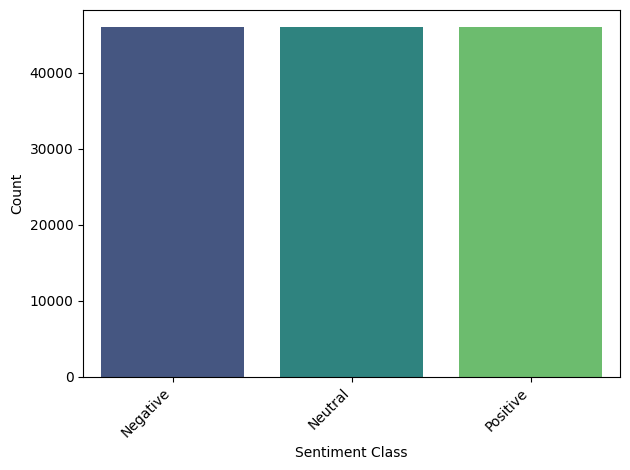

In [47]:
#Plot distribution of sentiment class for random_oversampling_df
class_distribution_random_oversampling_df = plot_distribution(random_oversampling_df, x='sentiment_class', xlabel='Sentiment Class', ylabel='Count', label_map=custom_label_map)

In [48]:
display(random_oversampling_df)

condition                            drugName  \
0       Birth Control                              Lybrel   
1       Birth Control                          Ortho Evra   
2       Birth Control  Ethinyl estradiol / levonorgestrel   
3          Depression                      L-methylfolate   
4       Birth Control                           Nexplanon   
...               ...                                 ...   
137938  Birth Control                   Junel Fe 1.5 / 30   
137939  Birth Control                        Etonogestrel   
137940  Birth Control                      Levonorgestrel   
137941  Birth Control                          Seasonique   
137942  Birth Control                        Etonogestrel   

                                                   review  rating  \
0       "I used to take another oral contraceptive, wh...       5   
1       "This is my first time using any form of birth...       8   
2       "I had been on the pill for many years. When m...       8   
3       "I have taken anti-depressants for years, with...      10   
4       "Started Nexplanon 2 months ago because I have...       3   
...                                                   ...     ...   
137938  "So, I&#039;ve been on this birth control for ...       6   
137939  "It either works for you or it doesn&#039;t. I...       6   
137940  "Okay, so you hear the horror stories and then...       5   
137941  "I took Seasonique for 2.5 years. I rated it a...       5   
137942  "I was on Nexplanon for precisely 3 months. I ...       6   

                                           cleaned_review  sentiment_class  
0       used take another oral contraceptive pill cycl...                1  
1       first time using form birth control glad went ...                2  
2       pill many year doctor changed chateau effectiv...                2  
3       taken anti depressant year improvement mostly ...                2  
4       started nexplanon month ago minimal amount con...                0  
...                                                   ...              ...  
137938  birth control month far much problem mildness ...                1  
137939  either work seems like get mostly side effect ...                1  
137940  okay hear horror story hear lady say bad say e...                1  
137941  took seasonique year rate job get pregnant how...                1  
137942  nexplanon precisely month got yesterday switch...                1  

[137943 rows x 6 columns]

In [49]:
#Save preprocessed random_oversampling_df to csv
random_oversampling_df.to_csv('preprocessed_random_oversampling_df.csv', index=False)

In [8]:
#Upload random_oversampling_df to df
random_oversampling_df = pd.read_csv('preprocessed_random_oversampling_df.csv')

In [52]:
#Create dict of all the plots created so far in this notebook for use in report
figures_to_save = {}

figures_to_save["./rating_distribution.png"] = rating_distribution
figures_to_save["./top_conditions_distribution.png"] = top_conditions_distribution
figures_to_save["./top_ten_drugs_10_rating.png"] = top_ten_drugs_10_rating
figures_to_save["./top_ten_drugs_1_rating.png"] = top_ten_drugs_1_rating
figures_to_save["./rating_distribution_top_five_diseases.png"] = rating_distribution_top_five_diseases
figures_to_save["./review_length_top_five_diseases_df.png"] = review_length_top_five_diseases_df
figures_to_save["./review_length_top_five_diseases_df_updated.png"] = review_length_top_five_diseases_df_updated
figures_to_save["./review_length_combined_df.png"] = review_length_combined_df
figures_to_save["./review_length_combined_df_updated.png"] = review_length_combined_df_updated
figures_to_save["./class_distribution_top_five_diseases.png"] = class_distribution_top_five_diseases
figures_to_save["./class_distribution_combined_df_updated.png"] = class_distribution_combined_df_updated
figures_to_save["./class_distribution_downsampled_df.png"] = class_distribution_downsampled_df
figures_to_save["./class_distribution_random_oversampling_df.png"] = class_distribution_random_oversampling_df

figures_to_save

{'./rating_distribution.png': <Figure size 640x480 with 1 Axes>,
 './top_conditions_distribution.png': <Figure size 1000x600 with 1 Axes>,
 './top_ten_drugs_10_rating.png': <Figure size 1000x600 with 1 Axes>,
 './top_ten_drugs_1_rating.png': <Figure size 1000x600 with 1 Axes>,
 './rating_distribution_top_five_diseases.png': <Figure size 640x480 with 1 Axes>,
 './review_length_top_five_diseases_df.png': <Figure size 1000x600 with 1 Axes>,
 './review_length_top_five_diseases_df_updated.png': <Figure size 1000x600 with 1 Axes>,
 './review_length_combined_df.png': <Figure size 1000x600 with 1 Axes>,
 './review_length_combined_df_updated.png': <Figure size 1000x600 with 1 Axes>,
 './class_distribution_top_five_diseases.png': <Figure size 640x480 with 1 Axes>,
 './class_distribution_combined_df_updated.png': <Figure size 640x480 with 1 Axes>,
 './class_distribution_downsampled_df.png': <Figure size 640x480 with 1 Axes>,
 './class_distribution_random_oversampling_df.png': <Figure size 640x480

In [46]:
#Function to save figures in any dictionary
def save_figures(fig_dict):
    """
    Save figures from the provided dictionary.

    Parameters:
    fig_dict (dict): Dictionary where keys are filenames and values are figure objects.

    Returns:
    None
    """
    for filename, figure in fig_dict.items():
        figure.savefig(filename)

In [53]:
save_figures(figures_to_save)

**Wordclouds**

Pypi (2024) wordcloud 1.9.3. Available online: https://pypi.org/project/wordcloud/ [Accessed 06/04/2024].

In [72]:
#from wordcloud import WordCloud
#Function to generate word clouds for text input
def generate_word_cloud(text):
    """
    Generate a word cloud from the provided text.

    Parameters:
    text (str): The input text from which the word cloud will be generated.

    Returns:
    wordcloud: The WordCloud object.
    """
    #Generate the word cloud
    wordcloud = WordCloud(width=800, height=800,
                          background_color='black',
                          min_font_size=10).generate(text)

    #Create the plot
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout()

    return wordcloud

In [73]:
#Function to generate wordclouds for each class in a df
def visualize_word_clouds_by_class(df):
    """
    Generate and visualize word clouds for each sentiment class in the given DataFrame.

    Parameters:
    df (DataFrame): The DataFrame containing the 'review' and 'sentiment_class' columns.

    Returns:
    list: A list of matplotlib figure objects, each containing a word cloud for a sentiment class.
    """
    #Separate reviews based on sentiment class
    sentiment_classes = df['sentiment_class'].unique()

    #Initialize a list to store figure objects
    word_cloud_figures = []

    #Generate and visualize word clouds for each sentiment class
    for sentiment_class in sentiment_classes:
        #Filter reviews for the current sentiment class
        sentiment_reviews = df[df['sentiment_class'] == sentiment_class]['review']
        
        #Concatenate the preprocessed text data
        concatenated_text = ' '.join(sentiment_reviews)
        
        #Generate and visualize word cloud
        fig = generate_word_cloud(concatenated_text)
        word_cloud_figures.append(fig)

    return word_cloud_figures

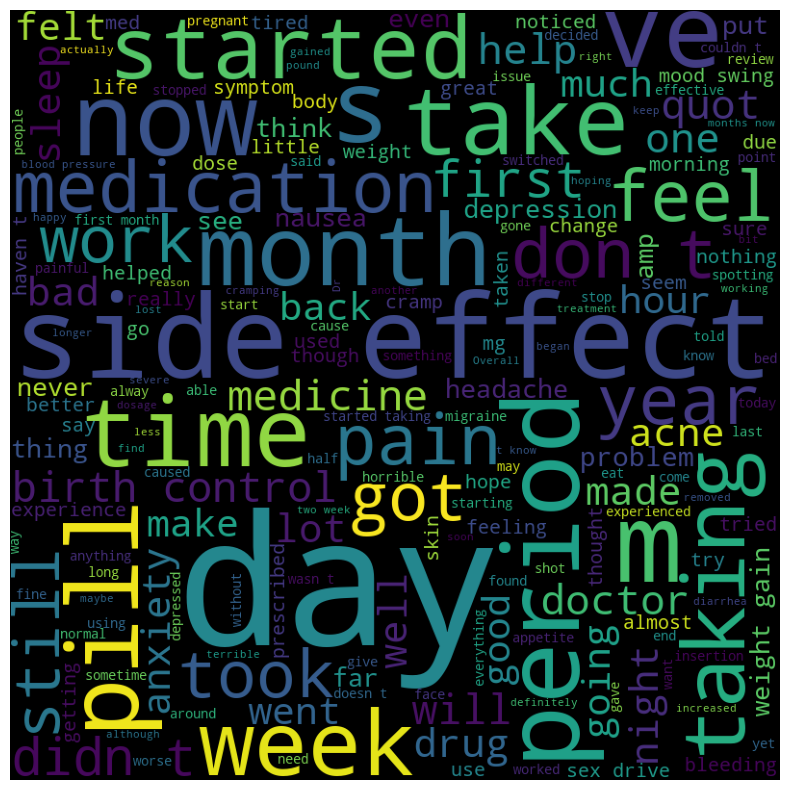

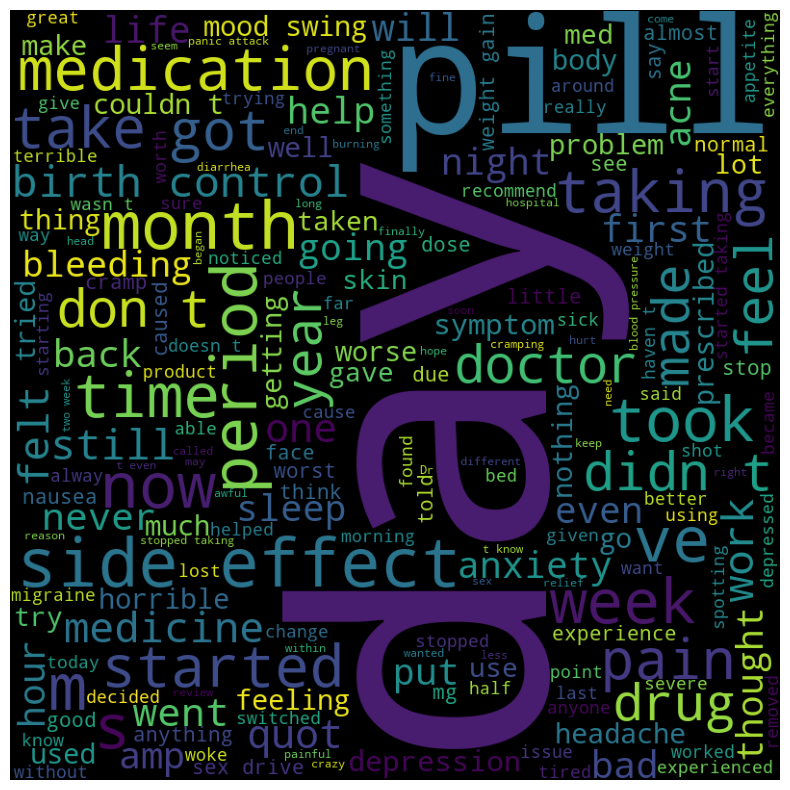

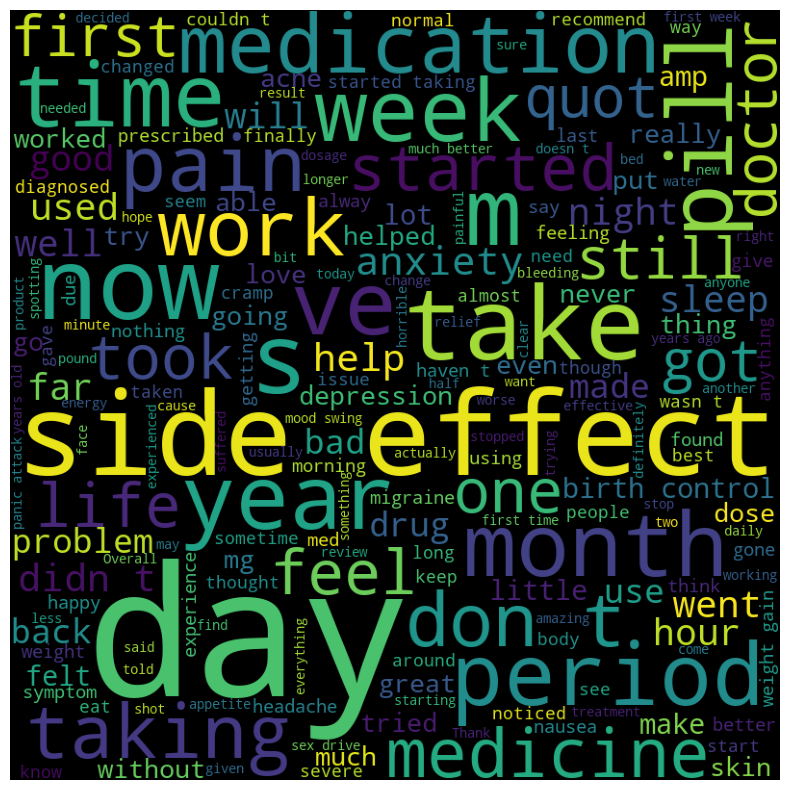

In [74]:
#Call the function to generate and visualize word clouds for classes in down_df
word_cloud_figures_downsampled = visualize_word_clouds_by_class(down_df)

#Save each figure separately
for i, word_cloud in enumerate(word_cloud_figures_downsampled):
    word_cloud.to_file(f"wordcloud_sentiment_class_downsampled_{i}.png")

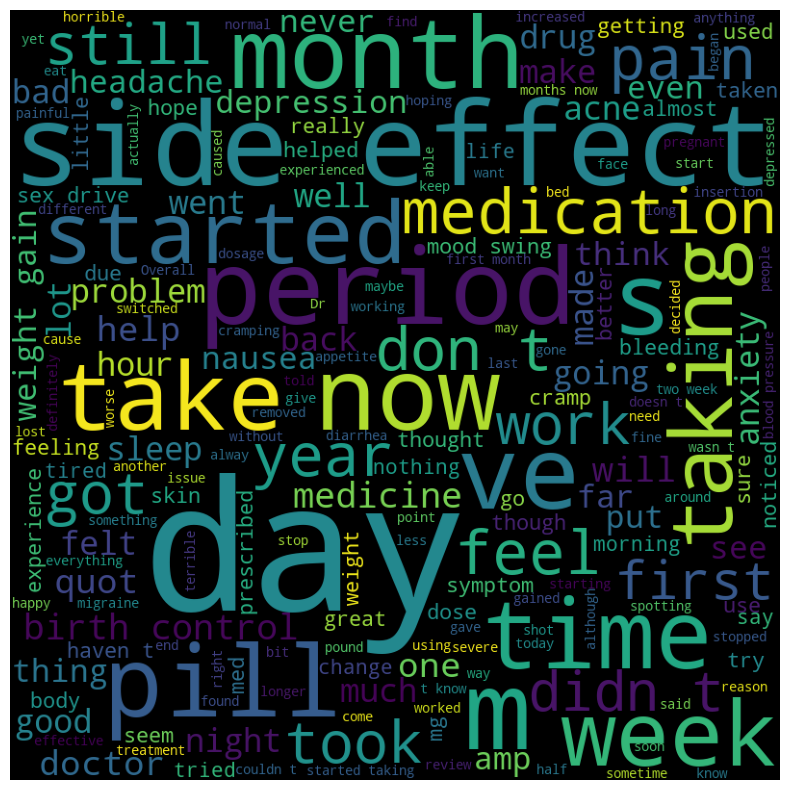

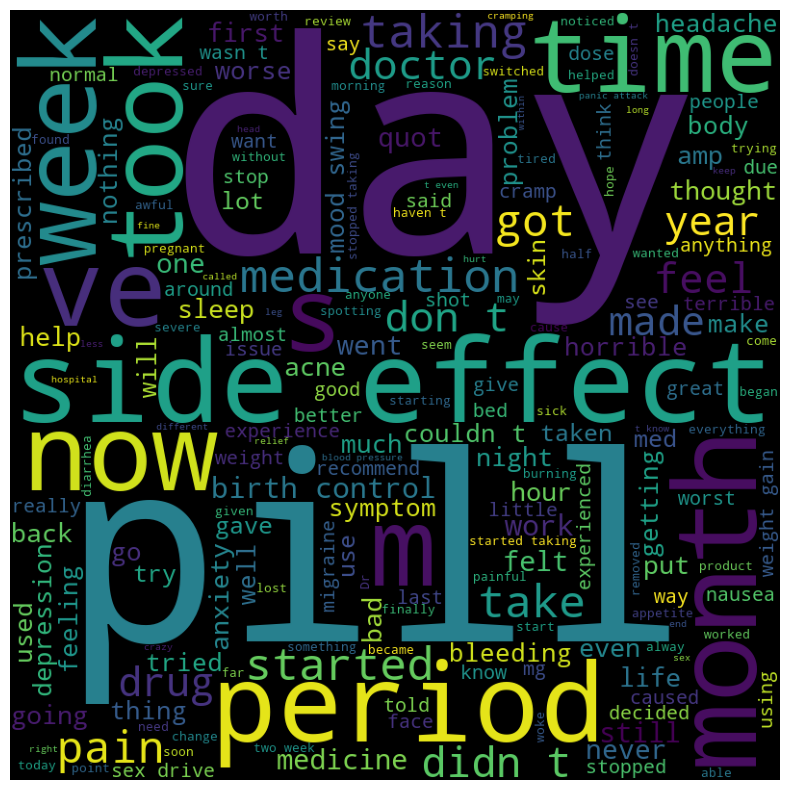

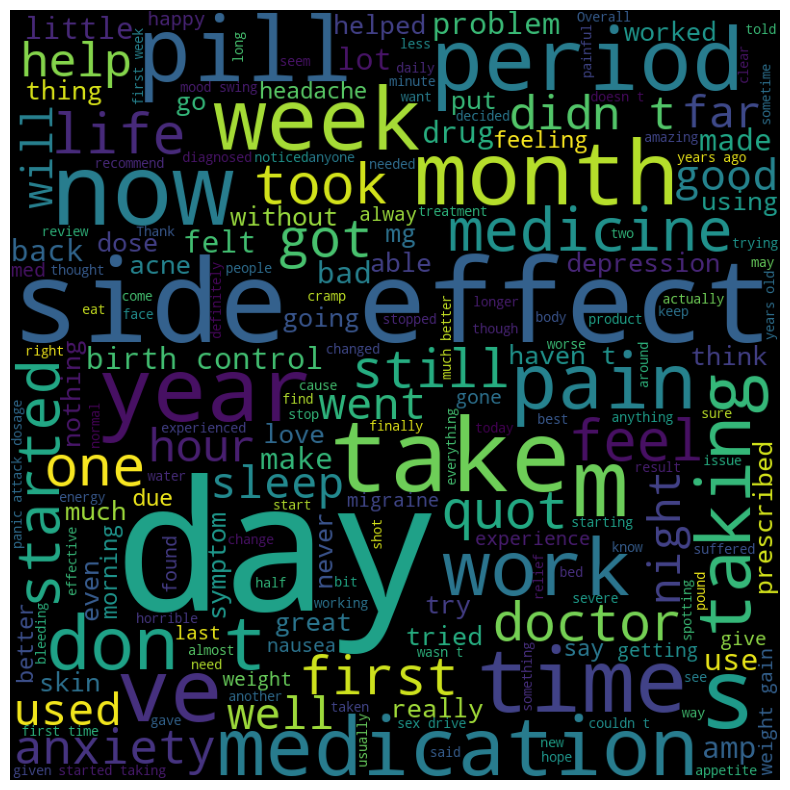

In [75]:
#Call the function to generate and visualize word clouds for classes in random_oversampling_df
word_cloud_figures_random_oversampling = visualize_word_clouds_by_class(random_oversampling_df)

#Save each figure separately
for i, word_cloud in enumerate(word_cloud_figures_random_oversampling):
    word_cloud.to_file(f"wordcloud_sentiment_class_random_oversampling_{i}.png")

**Vectorisation**

TF-IDF and CountVectoriser

Scikit-learn (n. d.) sklearn.feature_extraction.text.TfidfVectorizer. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html [Accessed 04/04/2024].

Scikit-learn (n. d.) sklearn.feature_extraction.text.CountVectorizer. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html [Accessed 04/04/2024].

Create sparce matrices that are compatible with NB and RF (and other ML models like DT and linearSVM).

In [39]:
#Drop rows with NaN values in cleaned_review column of random_oversampling_df
random_oversampling_df = random_oversampling_df.dropna(subset=['cleaned_review'])

In [78]:
#from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tfidf_vectorizer = TfidfVectorizer()
count_vectorizer = CountVectorizer()

#Vectorize text data in down_df
downsampled_tfidf_matrix = tfidf_vectorizer.fit_transform(down_df['cleaned_review'])
downsampled_count_matrix = count_vectorizer.fit_transform(down_df['cleaned_review'])

#Vectorize text data in random_oversampling_df
random_oversampling_tfidf_matrix = tfidf_vectorizer.transform(random_oversampling_df['cleaned_review'])
random_oversampling_count_matrix = count_vectorizer.transform(random_oversampling_df['cleaned_review'])

#Vectorize text data in top_5_df
top_five_diseases_tfidf_matrix = tfidf_vectorizer.transform(top_5_df['cleaned_review'])
top_five_diseases_count_matrix = count_vectorizer.transform(top_5_df['cleaned_review'])

**SMOTE**

When applying SMOTE to a multi-class dataset, it treats each class independently and oversamples the minority class samples to match the number of samples in the majority class. This process is repeated for each minority class in the dataset, resulting in a balanced distribution across all classes.

Imbalanced learn (n. d.-b) SMOTE. Available online: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html [Accessed 13/03/2024].

In [79]:
#from imblearn.over_sampling import SMOTE
#Function to apply SMOTE to vectors for top_five_diseases_tfidf_matrix and top_five_diseases_count_matrix
def balance_classes_with_SMOTE(X, y):
    """
    Balances the classes in the dataset using SMOTE oversampling.

    Parameters:
    X : array-like or sparse matrix of shape. The input features.
    y : array-like of shape. The target labels.

    Returns:
    X_resampled : array-like or sparse matrix of shape. The resampled input features.
    y_resampled : array-like of shape. The resampled target labels.
    """
    #Apply SMOTE to input features and target labels
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)

    return X_resampled, y_resampled

In [80]:
#Apply function to top_5_disease matrices for both TF-IDF and CV and sentiment classes (y)
X_resampled_tfidf, y_resampled_tfidf = balance_classes_with_SMOTE(top_five_diseases_tfidf_matrix, top_5_df['sentiment_class'])
X_resampled_count, y_resampled_count = balance_classes_with_SMOTE(top_five_diseases_count_matrix, top_5_df['sentiment_class'])

In [81]:
#Function to plot balance of sentiment classes before and after SMOTE
def plot_smote_class_distribution(y_original, y_resampled, label_map=None)
    """
    Plots the distribution of class labels before and after SMOTE.

    Parameters:
    y_original : array-like of shape. The original target labels.
    y_resampled : array-like of shape. The resampled target labels.
    classes : array-like of shape. The unique class labels.

    Returns:
    fig : matplotlib.figure.Figure The matplotlib figure object containing the plot.
    """
    original_counts = np.bincount(y_original)
    resampled_counts = np.bincount(y_resampled)

    fig, ax = plt.subplots()
    ax.bar(classes, original_counts, color=sns.color_palette('viridis')[2], alpha=0.5, label='Original')
    ax.bar(classes, resampled_counts, color=sns.color_palette('viridis')[1], alpha=0.5, label='Resampled')
    ax.set_xlabel('Class Label')
    if label_map:
        plt.xticks(ticks=range(len(label_map)), labels=[label_map[i] for i in range(len(label_map))], rotation=45, ha='right')
    ax.set_ylabel('Count')
    ax.legend()
    
    plt.tight_layout()

    return fig

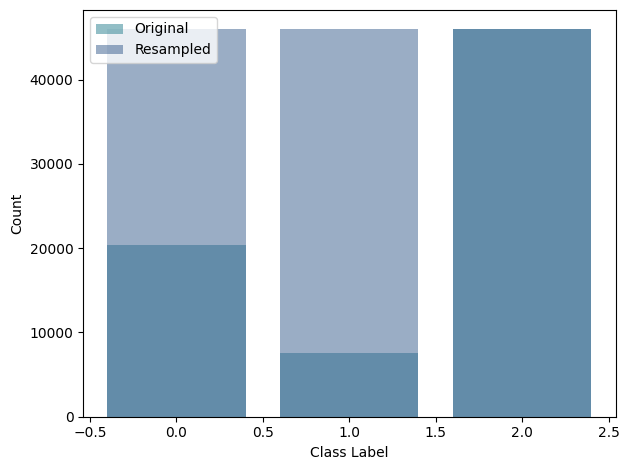

In [82]:
#Plot class distribution before and after SMOTE for TF-IDF resampling
smote_tfidf_five_diseases = plot_smote_class_distribution(top_5_df['sentiment_class'], y_resampled_tfidf, label_map=custom_label_map)

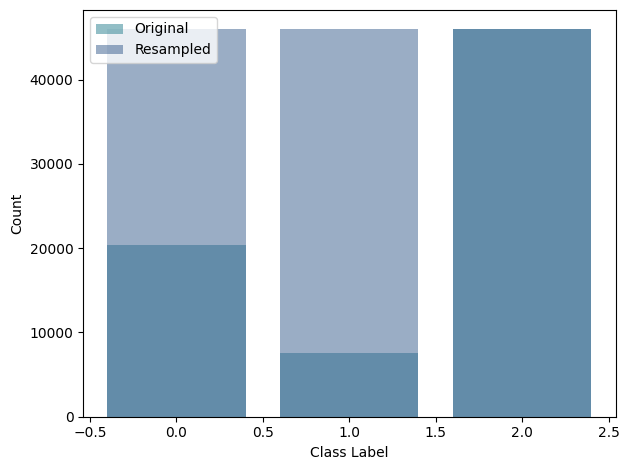

In [83]:
#Plot class distribution before and after SMOTE for CountVectorizer resampling
smote_count_five_diseases = plot_smote_class_distribution(top_5_df['sentiment_class'], y_resampled_count, label_map=custom_label_map)

In [152]:
#Create dict of the extra plots in this notebook for use in report
figures_to_save_2 = {}

figures_to_save_2["./smote_tfidf_five_diseases.png"] = smote_tfidf_five_diseases
figures_to_save_2["./smote_count_five_diseases.png"] = smote_count_five_diseases

figures_to_save_2

{'./smote_tfidf_five_diseases.png': <Figure size 640x480 with 1 Axes>,
 './smote_count_five_diseases.png': <Figure size 640x480 with 1 Axes>}

In [153]:
save_figures(figures_to_save_2)

In [84]:
#from sklearn.model_selection import train_test_split
#Split the SMOTE oversampled data using TF-IDF and CV into training and testing sets (75%/25% split)
X_train_smote_tfidf, X_test_smote_tfidf, y_train_smote_tfidf, y_test_smote_tfidf = train_test_split(X_resampled_tfidf, y_resampled_tfidf, test_size=0.25, random_state=42)
X_train_smote_count, X_test_smote_count, y_train_smote_count, y_test_smote_count = train_test_split(X_resampled_count, y_resampled_count, test_size=0.25, random_state=42)

In [85]:
#Print the shapes
print("X_resampled_tfidf shape:", X_resampled_tfidf.shape)
print("X_resampled_count shape:", X_resampled_count.shape)
print("y_resampled_tfidf shape:", y_resampled_tfidf.shape)
print("y_resampled_count shape:", y_resampled_count.shape)

X_resampled_tfidf shape: (137943, 18512)
X_resampled_count shape: (137943, 18512)
y_resampled_tfidf shape: (137943,)
y_resampled_count shape: (137943,)


In [86]:
#Define X for TF-IDF and CV matrix for random_oversampling with the sentiment classes
X_random_oversampling_tfidf = random_oversampling_tfidf_matrix
X_random_oversampling_count = random_oversampling_count_matrix
y_random_oversampling = random_oversampling_df['sentiment_class']

#Split the random_oversampling data using TF-IDF and CV into training and testing sets (75%/25% split)
X_train_random_over_tfidf, X_test_random_over_tfidf, y_train_random_over_tfidf, y_test_random_over_tfidf = train_test_split(X_random_oversampling_tfidf, y_random_oversampling, test_size=0.25, random_state=42)
X_train_random_over_count, X_test_random_over_count, y_train_random_over_count, y_test_random_over_count = train_test_split(X_random_oversampling_count, y_random_oversampling, test_size=0.25, random_state=42)

In [87]:
#Print the shapes
print("X_random_oversampling_tfidf shape:", X_random_oversampling_tfidf.shape)
print("X_random_oversampling_count shape:", X_random_oversampling_count.shape)
print("y_random_oversampling shape:", y_random_oversampling.shape)

X_random_oversampling_tfidf shape: (57130, 18512)
X_random_oversampling_count shape: (57130, 18512)
y_random_oversampling shape: (57130,)


In [88]:
#Splitting into X and y for TF-IDF matrix
X_downsampled_tfidf = downsampled_tfidf_matrix
y_down = down_df['sentiment_class']

#Defining X for CountVectorizer matrix
X_downsampled_count = downsampled_count_matrix

In [89]:
#Define X for TF-IDF and CV matrix for downsampled with the sentiment classes
X_downsampled_tfidf = downsampled_tfidf_matrix
X_downsampled_count = downsampled_count_matrix
y_downsampled = downsampled_df['sentiment_class']

#Split the downsampled data using TF-IDF and CV into training and testing sets (75%/25% split)
X_train_down_tfidf, X_test_down_tfidf, y_train_down_tfidf, y_test_down_tfidf = train_test_split(X_downsampled_tfidf, y_down, test_size=0.25, random_state=42)
X_train_down_count, X_test_down_count, y_train_down_count, y_test_down_count = train_test_split(X_downsampled_count, y_down, test_size=0.25, random_state=42)

In [91]:
#import pickle
#Save train-test splits for the downsampled dataset
with open('downsampled_dataset_traintest.pkl', 'wb') as file:
    pickle.dump({
        'X_train_tfidf': X_train_down_tfidf,
        'X_test_tfidf': X_test_down_tfidf,
        'y_train_tfidf': y_train_down_tfidf,
        'y_test_tfidf': y_test_down_tfidf,
        'X_train_count': X_train_down_count,
        'X_test_count': X_test_down_count,
        'y_train_count': y_train_down_count,
        'y_test_count': y_test_down_count
    }, file)

#Save train-test splits for the randomly oversampled dataset
with open('random_oversampled_dataset_traintest.pkl', 'wb') as file:
    pickle.dump({
        'X_train_tfidf': X_train_random_over_tfidf,
        'X_test_tfidf': X_test_random_over_tfidf,
        'y_train_tfidf': y_train_random_over_tfidf,
        'y_test_tfidf': y_test_random_over_tfidf,
        'X_train_count': X_train_random_over_count,
        'X_test_count': X_test_random_over_count,
        'y_train_count': y_train_random_over_count,
        'y_test_count': y_test_random_over_count
    }, file)

#Save train-test splits for the SMOTE oversampled dataset
with open('SMOTE_oversampled_dataset_traintest.pkl', 'wb') as file:
    pickle.dump({
        'X_train_tfidf': X_train_smote_tfidf,
        'X_test_tfidf': X_test_smote_tfidf,
        'y_train_tfidf': y_train_smote_tfidf,
        'y_test_tfidf': y_test_smote_tfidf,
        'X_train_count': X_train_smote_count,
        'X_test_count': X_test_smote_count,
        'y_train_count': y_train_smote_count,
        'y_test_count': y_test_smote_count
    }, file)

#Load train-test splits for the downsampled dataset
with open('downsampled_dataset_traintest.pkl', 'rb') as file:
    downsampled_data = pickle.load(file)
    X_train_down_tfidf = downsampled_data['X_train_tfidf']
    X_test_down_tfidf = downsampled_data['X_test_tfidf']
    y_train_down_tfidf = downsampled_data['y_train_tfidf']
    y_test_down_tfidf = downsampled_data['y_test_tfidf']
    X_train_down_count = downsampled_data['X_train_count']
    X_test_down_count = downsampled_data['X_test_count']
    y_train_down_count = downsampled_data['y_train_count']
    y_test_down_count = downsampled_data['y_test_count']

#Load train-test splits for the randomly oversampled dataset
with open('random_oversampled_dataset_traintest.pkl', 'rb') as file:
    random_oversampled_data = pickle.load(file)
    X_train_random_over_tfidf = random_oversampled_data['X_train_tfidf']
    X_test_random_over_tfidf = random_oversampled_data['X_test_tfidf']
    y_train_random_over_tfidf = random_oversampled_data['y_train_tfidf']
    y_test_random_over_tfidf = random_oversampled_data['y_test_tfidf']
    X_train_random_over_count = random_oversampled_data['X_train_count']
    X_test_random_over_count = random_oversampled_data['X_test_count']
    y_train_random_over_count = random_oversampled_data['y_train_count']
    y_test_random_over_count = random_oversampled_data['y_test_count']

#Load train-test splits for the SMOTE oversampled dataset
with open('SMOTE_oversampled_dataset_traintest.pkl', 'rb') as file:
    SMOTE_oversampled_data = pickle.load(file)
    X_train_smote_tfidf = SMOTE_oversampled_data['X_train_tfidf']
    X_test_smote_tfidf = SMOTE_oversampled_data['X_test_tfidf']
    y_train_smote_tfidf = SMOTE_oversampled_data['y_train_tfidf']
    y_test_smote_tfidf = SMOTE_oversampled_data['y_test_tfidf']
    X_train_smote_count = SMOTE_oversampled_data['X_train_count']
    X_test_smote_count = SMOTE_oversampled_data['X_test_count']
    y_train_smote_count = SMOTE_oversampled_data['y_train_count']
    y_test_smote_count = SMOTE_oversampled_data['y_test_count']

*The training and test data variables to compare CV with TF-IDF for ML classification are:*

For downsampled dataset:
X_train_down_tfidf, X_test_down_tfidf, y_train_down_tfidf, y_test_down_tfidf
X_train_down_count, X_test_down_count, y_train_down_count, y_test_down_count 

For randomly oversampled dataset:
X_train_random_over_tfidf, X_test_random_over_tfidf, y_train_random_over_tfidf, y_test_random_over_tfidf 
X_train_random_over_count, X_test_random_over_count, y_train_random_over_count, y_test_random_over_count 

For SMOTE oversampled dataset:
X_train_smote_tfidf, X_test_smote_tfidf, y_train_smote_tfidf, y_test_smote_tfidf
X_train_smote_count, X_test_smote_count, y_train_smote_count, y_test_smote_count

In [92]:
#Further subsampling the training sets to use only 10% of the 75% split
#Use stratify to ensure the proportion of different classes in the target variable to keep balanced classes
X_train_down_tfidf_sub, _, y_train_down_tfidf_sub, _ = train_test_split(X_train_down_tfidf, y_train_down_tfidf, train_size=0.1, stratify=y_train_down_tfidf)
X_train_down_count_sub, _, y_train_down_count_sub, _ = train_test_split(X_train_down_count, y_train_down_count, train_size=0.1, stratify=y_train_down_count)
X_train_random_over_tfidf_sub, _, y_train_random_over_tfidf_sub, _ = train_test_split(X_train_random_over_tfidf, y_train_random_over_tfidf, train_size=0.1, stratify=y_train_random_over_tfidf)
X_train_random_over_count_sub, _, y_train_random_over_count_sub, _ = train_test_split(X_train_random_over_count, y_train_random_over_count, train_size=0.1, stratify=y_train_random_over_count)
X_train_smote_tfidf_sub, _, y_train_smote_tfidf_sub, _ = train_test_split(X_train_smote_tfidf, y_train_smote_tfidf, train_size=0.1, stratify=y_train_smote_tfidf)
X_train_smote_count_sub, _, y_train_smote_count_sub, _ = train_test_split(X_train_smote_count, y_train_smote_count, train_size=0.1, stratify=y_train_smote_count)

In [93]:
#import pickle
#Save the subsampled training sets
with open('subsampled_train_test_sets.pkl', 'wb') as file:
    pickle.dump((X_train_down_tfidf_sub, y_train_down_tfidf_sub,
                 X_train_down_count_sub, y_train_down_count_sub,
                 X_train_random_over_tfidf_sub, y_train_random_over_tfidf_sub,
                 X_train_random_over_count_sub, y_train_random_over_count_sub,
                 X_train_smote_tfidf_sub, y_train_smote_tfidf_sub,
                 X_train_smote_count_sub, y_train_smote_count_sub), file)

#Load the subsampled training sets
with open('subsampled_train_test_sets.pkl', 'rb') as file:
    (X_train_down_tfidf_sub, y_train_down_tfidf_sub,
     X_train_down_count_sub, y_train_down_count_sub,
     X_train_random_over_tfidf_sub, y_train_random_over_tfidf_sub,
     X_train_random_over_count_sub, y_train_random_over_count_sub,
     X_train_smote_tfidf_sub, y_train_smote_tfidf_sub,
     X_train_smote_count_sub, y_train_smote_count_sub) = pickle.load(file)

**ML model development**

Train multinomialNB and RF for sentiment classification of TF-IDF and CV vectorised data for downsampled, randomly oversampled and SMOTE oversampled data.

**Multinomial NB**

Scikit-learn (n. d.) Naive Bayes. Available online: https://scikit-learn.org/stable/modules/naive_bayes.html [Accessed 04/04/2024].

In [94]:
#from sklearn.model_selection import GridSearchCV
#from sklearn.naive_bayes import MultinomialNB
#Define function to optimise hyperparameters for multinomial NB
#Optimising alpha and fit_prior
def optimize_multinomial_nb(X_train, y_train):
    """
    Optimize hyperparameters for Multinomial Naive Bayes classifier using grid search and 5-fold cross-validation.

    Parameters:
    X_train : array-like of shape. Training feature dataset.
    y_train : array-like of shape. True labels for the training data.

    Returns:
    MultinomialNB : Optimized Multinomial Naive Bayes classifier.
    """
    #Define the parameter grid
    param_grid = {
        'alpha': [0.1, 0.5, 1.0, 2.0],  
        'fit_prior': [True, False]  
    }
    
    #Create Multinomial Naive Bayes classifier
    nb = MultinomialNB()
    
    #Perform grid search with 5-fold cross-validation
    #Score based on accuracy
    #Use all available processors
    grid_search = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    #Print the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)
    
    #Return the best model found during the search
    return grid_search.best_estimator_

*Run on 10% subsampled training data for optimisation*

In [95]:
#For downsampled dataset with TF-IDF
best_model_down_tfidf_nb = optimize_multinomial_nb(X_train_down_tfidf_sub, y_train_down_tfidf_sub)

#For downsampled dataset with CV
best_model_down_count_nb = optimize_multinomial_nb(X_train_down_count_sub, y_train_down_count_sub)

#For randomly oversampled dataset with TF-IDF
best_model_random_over_tfidf_nb = optimize_multinomial_nb(X_train_random_over_tfidf_sub, y_train_random_over_tfidf_sub)

#For randomly oversampled dataset with CV
best_model_random_over_count_nb = optimize_multinomial_nb(X_train_random_over_count_sub, y_train_random_over_count_sub)

#For SMOTE oversampled dataset with TF-IDF
best_model_smote_tfidf_nb = optimize_multinomial_nb(X_train_smote_tfidf_sub, y_train_smote_tfidf_sub)

#For SMOTE oversampled dataset with CV
best_model_smote_count_nb = optimize_multinomial_nb(X_train_smote_count_sub, y_train_smote_count_sub)

Best Parameters: {'alpha': 2.0, 'fit_prior': True}
Best Score: 0.5541568065082498
Best Parameters: {'alpha': 2.0, 'fit_prior': False}
Best Score: 0.5345439972082575
Best Parameters: {'alpha': 1.0, 'fit_prior': True}
Best Score: 0.5536922430997067
Best Parameters: {'alpha': 2.0, 'fit_prior': True}
Best Score: 0.5347839125835614
Best Parameters: {'alpha': 0.1, 'fit_prior': False}
Best Score: 0.6494925084581923
Best Parameters: {'alpha': 0.5, 'fit_prior': True}
Best Score: 0.6065732237796037


In [96]:
#Extract the best parameters
best_params_down_tfidf_nb = best_model_down_tfidf_nb.get_params()
best_params_down_count_nb = best_model_down_count_nb.get_params()
best_params_random_over_tfidf_nb = best_model_random_over_tfidf_nb.get_params()
best_params_random_over_count_nb = best_model_random_over_count_nb.get_params()
best_params_smote_tfidf_nb = best_model_smote_tfidf_nb.get_params()
best_params_smote_count_nb = best_model_smote_count_nb.get_params()

In [97]:
#from joblib import dump
#Save the best parameters to files using joblib (more efficient than pickle for large datasets)
dump(best_params_down_tfidf_nb, 'best_params_down_tfidf_nb.joblib')
dump(best_params_down_count_nb, 'best_params_down_count_nb.joblib')
dump(best_params_random_over_tfidf_nb, 'best_params_random_over_tfidf_nb.joblib')
dump(best_params_random_over_count_nb, 'best_params_random_over_count_nb.joblib')
dump(best_params_smote_tfidf_nb, 'best_params_smote_tfidf_nb.joblib')
dump(best_params_smote_count_nb, 'best_params_smote_count_nb.joblib')

['best_params_smote_count_nb.joblib']

#from joblib import load
#Load the best parameters from files
best_params_down_tfidf_nb = load('best_params_down_tfidf_nb.joblib')
best_params_down_count_nb = load('best_params_down_count_nb.joblib')
best_params_random_over_tfidf_nb = load('best_params_random_over_tfidf_nb.joblib')
best_params_random_over_count_nb = load('best_params_random_over_count_nb.joblib')
best_params_smote_tfidf_nb = load('best_params_smote_tfidf_nb.joblib')
best_params_smote_count_nb = load('best_params_smote_count_nb.joblib')

*Run on full training data for final model evaluation*

In [98]:
#For full downsampled dataset with TF-IDF
best_model_down_tfidf_nb.fit(X_train_down_tfidf, y_train_down_tfidf)

#For full downsampled dataset with CV
best_model_down_count_nb.fit(X_train_down_count, y_train_down_count)

#For full randomly oversampled dataset with TF-IDF
best_model_random_over_tfidf_nb.fit(X_train_random_over_tfidf, y_train_random_over_tfidf)

#For full randomly oversampled dataset with CV
best_model_random_over_count_nb.fit(X_train_random_over_count, y_train_random_over_count)

#For full SMOTE oversampled dataset with TF-IDF
best_model_smote_tfidf_nb.fit(X_train_smote_tfidf, y_train_smote_tfidf)

#For full SMOTE oversampled dataset with CV
best_model_smote_count_nb.fit(X_train_smote_count, y_train_smote_count)

MultinomialNB(alpha=0.5)

*Evaluate model*

In [268]:
#from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
#function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the performance of the given model on the test data.

    Parameters:
    model : object. Trained classification model.
    X_test : array-like of shape. Test feature dataset.
    y_test : array-like of shape. True labels for the test data.

    Returns:
    str : Classification report containing precision, recall, F1-score, and support.
    float : ROC AUC score.
    float : ROC AUC micro-average score.
    array-like of shape : Confusion matrix.
    array-like of shape : Predicted probabilities for each class.
    """
    #Make predictions
    y_pred = model.predict(X_test)
    
    #Get classification report
    report = classification_report(y_test, y_pred)
    
    #Get predicted probabilities
    y_pred_proba = model.predict_proba(X_test)
      
    #Get micro-average ROC AUC score
    roc_auc_micro = roc_auc_score(y_test, y_pred_proba, average='micro', multi_class='ovr')
    
    #Get confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    return report, roc_auc_micro, cm, y_pred_proba

In [106]:
#Evaluate the best models for each dataset
reports_nb = []
roc_aucs_micro_nb = []
cms_nb = []
y_pred_nb = []

#For downsampled dataset with TF-IDF
report, roc_auc_micro, cm, y_pred_proba = evaluate_model(best_model_down_tfidf_nb, X_test_down_tfidf, y_test_down_tfidf)
reports_nb.append(report)
roc_aucs_micro_nb.append(roc_auc_micro)
cms_nb.append(cm)
y_pred_nb.append(y_pred_proba)

#For downsampled dataset with CV
report, roc_auc_micro, cm, y_pred_proba = evaluate_model(best_model_down_count_nb, X_test_down_count, y_test_down_count)
reports_nb.append(report)
roc_aucs_micro_nb.append(roc_auc_micro)
cms_nb.append(cm)
y_pred_nb.append(y_pred_proba)

#For randomly oversampled dataset with TF-IDF
report, roc_auc_micro, cm, y_pred_proba = evaluate_model(best_model_random_over_tfidf_nb, X_test_random_over_tfidf, y_test_random_over_tfidf)
reports_nb.append(report)
roc_aucs_micro_nb.append(roc_auc_micro)
cms_nb.append(cm)
y_pred_nb.append(y_pred_proba)

#For randomly oversampled dataset with CV
report, roc_auc_micro, cm, y_pred_proba = evaluate_model(best_model_random_over_count_nb, X_test_random_over_count, y_test_random_over_count)
reports_nb.append(report)
roc_aucs_micro_nb.append(roc_auc_micro)
cms_nb.append(cm)
y_pred_nb.append(y_pred_proba)

#For SMOTE oversampled dataset with TF-IDF
report, roc_auc_micro, cm, y_pred_proba = evaluate_model(best_model_smote_tfidf_nb, X_test_smote_tfidf, y_test_smote_tfidf)
reports_nb.append(report)
roc_aucs_micro_nb.append(roc_auc_micro)
cms_nb.append(cm)
y_pred_nb.append(y_pred_proba)

#For SMOTE oversampled dataset with CV
report, roc_auc_micro, cm, y_pred_proba = evaluate_model(best_model_smote_count_nb, X_test_smote_count, y_test_smote_count)
reports_nb.append(report)
roc_aucs_micro_nb.append(roc_auc_micro)
cms_nb.append(cm)
y_pred_nb.append(y_pred_proba)

#Print evaluation metrics
for i, dataset in enumerate(['downsampled TF-IDF', 'downsampled CountVectorizer', 'random oversampled TF-IDF', 
                             'random oversampled CountVectorizer', 'SMOTE oversampled TF-IDF', 'SMOTE oversampled CountVectorizer']):
    print(f"Evaluation metrics for {dataset}:\n")
    print("Classification Report:\n", reports_nb[i])
    print("\nROC AUC Weighted Average Score:", roc_aucs_micro_nb[i])
    print("\nConfusion Matrix:\n", cms_nb[i])
    print("\n")

Evaluation metrics for downsampled TF-IDF:

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.58      0.62      4824
           1       0.52      0.57      0.54      4846
           2       0.62      0.65      0.64      4613

    accuracy                           0.60     14283
   macro avg       0.60      0.60      0.60     14283
weighted avg       0.60      0.60      0.60     14283


ROC AUC Weighted Average Score: 0.7833025714499281

Confusion Matrix:
 [[2803 1298  723]
 [ 997 2738 1111]
 [ 416 1191 3006]]


Evaluation metrics for downsampled CountVectorizer:

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.59      0.63      4824
           1       0.53      0.53      0.53      4846
           2       0.60      0.67      0.63      4613

    accuracy                           0.60     14283
   macro avg       0.60      0.60      0.60     14283
weighted avg       

*Visualise confusion matrices for NB*

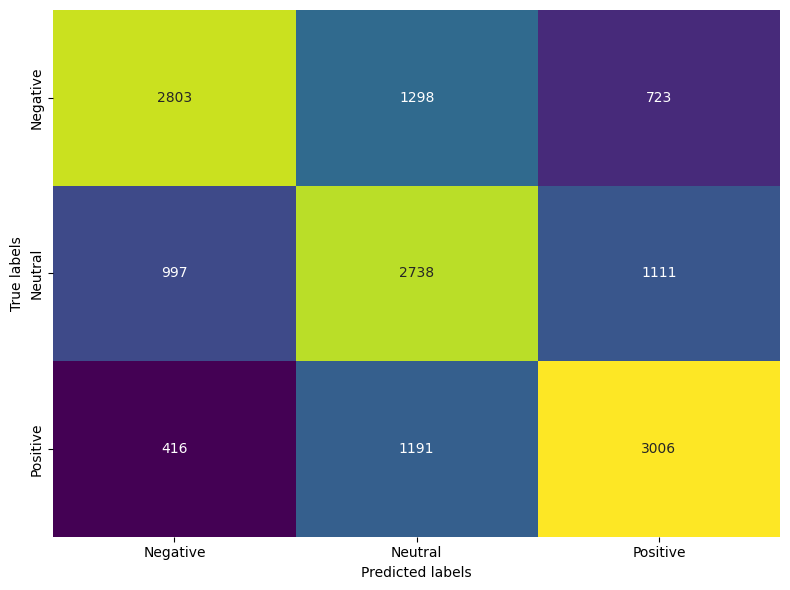

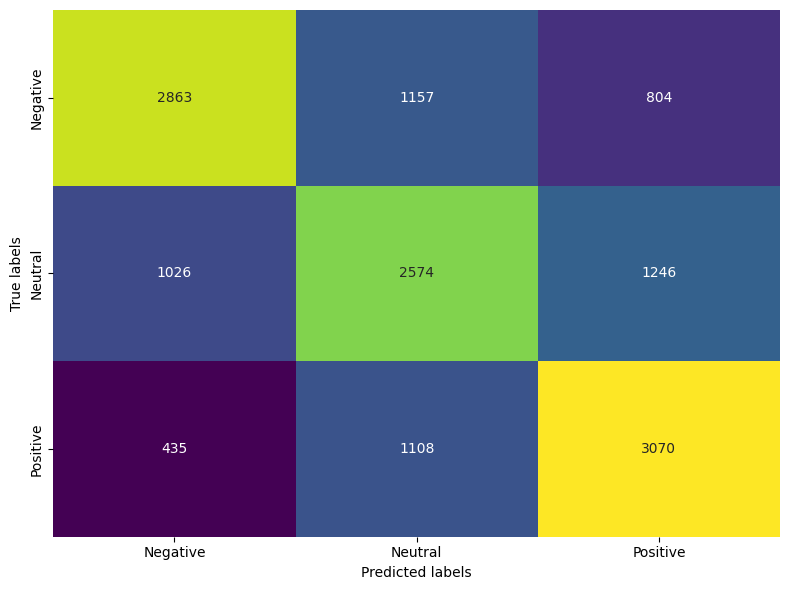

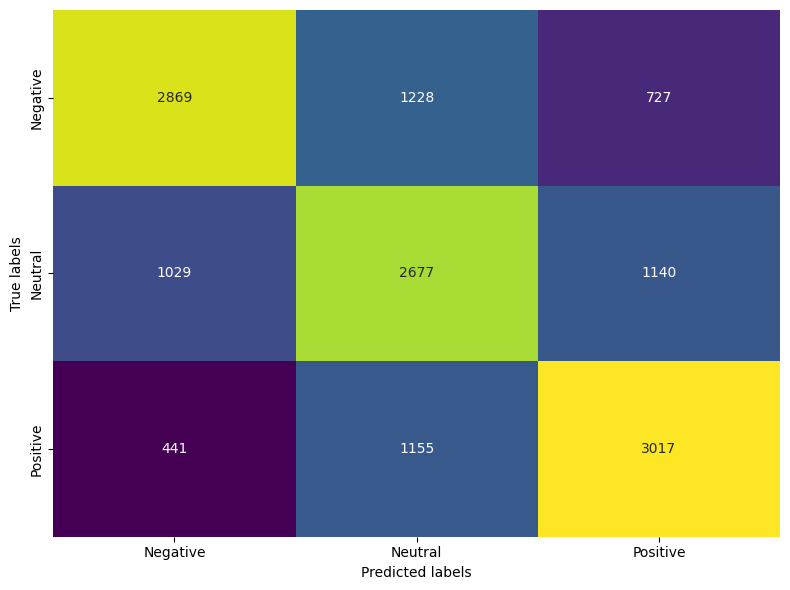

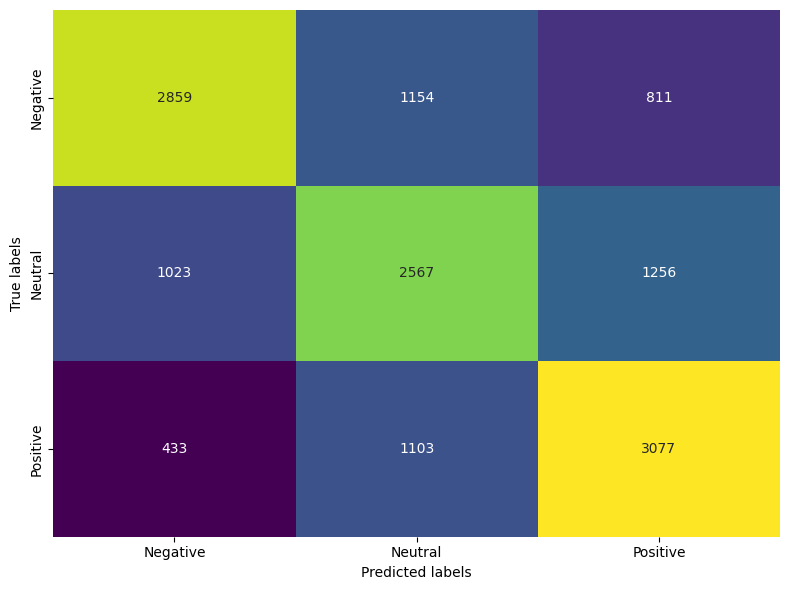

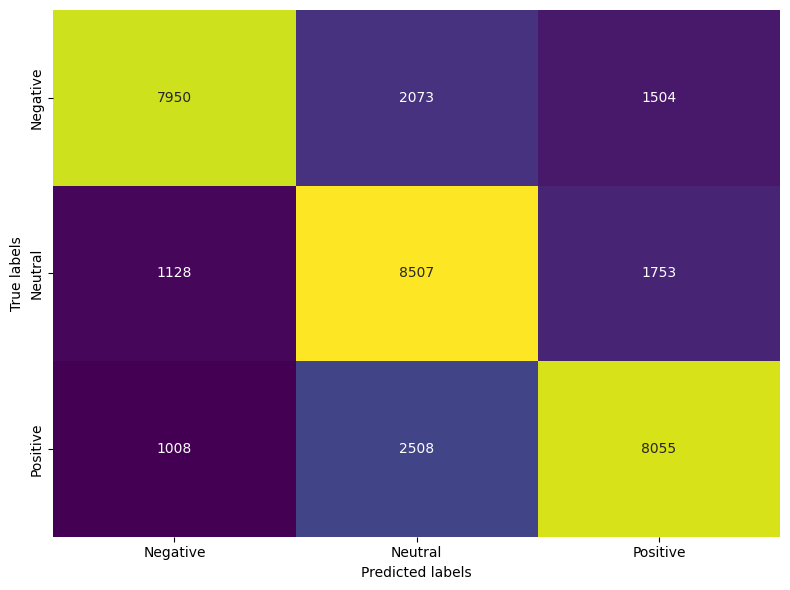

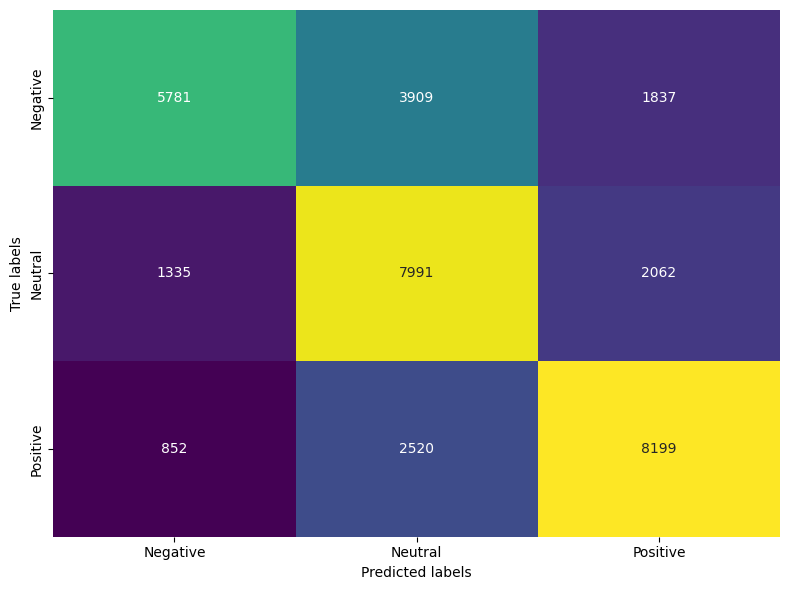

In [107]:
#Plot confusion matrices for all data
def plot_confusion_matrix_all(cm, dataset_name):
    """
    Plot the confusion matrix for a classification model.

    Parameters:
    cm : array-like of shape.Confusion matrix.
        
    Returns:
    matplotlib.figure.Figure. The confusion matrix plot.
    """
    fig = plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, cmap='viridis', fmt='g', cbar=False)

    #Define label mappings
    labels = ['Negative', 'Neutral', 'Positive']
    tick_marks = np.arange(len(labels))

    #Set ticks at center of each cell
    ax.set_xticks(tick_marks + 0.5, labels)
    ax.set_yticks(tick_marks + 0.5, labels)

    #Set labels on both axes
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.tight_layout()
    
    return fig

#Save confusion matrices for each dataset
confusion_matrix_figures_nb = []
for i, dataset_name in enumerate(['downsampled_TF-IDF', 'downsampled_CountVectorizer', 
                                  'random_oversampled_TF-IDF', 'random_oversampled_CountVectorizer', 
                                  'SMOTE_oversampled_TF-IDF', 'SMOTE_oversampled_CountVectorizer']):
    confusion_matrix_fig = plot_confusion_matrix_all(cms_nb[i], dataset_name)
    confusion_matrix_fig.savefig(f'nb_cm_{dataset_name}.png')
    confusion_matrix_figures_nb.append(confusion_matrix_fig)

TF-IDF-NB on the SMOTE oversampled dataset outperformed all other comparators (CV and down and random oversampling).

**Random Forest**

Scikit-learn (n. d.) sklearn.ensemble.RandomForestClassifier. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html [Accessed 04/04/2024].

In [108]:
#from sklearn.ensemble import RandomForestClassifier
#Function to optimise RF using grid search and cross-validation (5-fold)
#Optimising for n_estimators, max_depth, min_samples_split and min_samples_leaf
def optimize_random_forest(X_train, y_train):
    """
    Optimize hyperparameters for Random Forest classifier using grid search and 5-fold cross-validation.

    Parameters:
    X_train : array-like of shape (n_samples, n_features). Training feature dataset.
    y_train : array-like of shape (n_samples,). True labels for the training data.

    Returns:
    RandomForestClassifier : Optimized Random Forest classifier.
    """
    #Define the parameter grid
    param_grid = {
        'n_estimators': [100, 200, 300],  
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }
    
    #Create Random Forest classifier
    rf = RandomForestClassifier(random_state=42)
    
    #Perform grid search with 5-fold cross-validation
    #Score based on accuracy
    #Use all available processors
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    #Print the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)
    
    #Return the best model found during the search
    return grid_search.best_estimator_

*Run on 10% subsampled training data for optimisation*

In [109]:
#Use this function to find the best RF model for each dataset using the sub-sampled training data
#For downsampled dataset with TF-IDF
best_model_down_tfidf_rf = optimize_random_forest(X_train_down_tfidf_sub, y_train_down_tfidf_sub)

#For downsampled dataset with CV
best_model_down_count_rf = optimize_random_forest(X_train_down_count_sub, y_train_down_count_sub)

#For randomly oversampled dataset with TF-IDF
best_model_random_over_tfidf_rf = optimize_random_forest(X_train_random_over_tfidf_sub, y_train_random_over_tfidf_sub)

#For randomly oversampled dataset with CV
best_model_random_over_count_rf = optimize_random_forest(X_train_random_over_count_sub, y_train_random_over_count_sub)

#For SMOTE oversampled dataset with TF-IDF
best_model_smote_tfidf_rf = optimize_random_forest(X_train_smote_tfidf_sub, y_train_smote_tfidf_sub)

#For SMOTE oversampled dataset with CV
best_model_smote_count_rf = optimize_random_forest(X_train_smote_count_sub, y_train_smote_count_sub)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best Score: 0.5562590649843511
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best Score: 0.5532173197090481
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best Score: 0.5758672395555021
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.5611620628360179
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.7680038666022233
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.7055582406959885


In [110]:
#Extract the best parameters
best_params_down_tfidf = best_model_down_tfidf_rf.get_params()
best_params_down_count = best_model_down_count_rf.get_params()
best_params_random_over_tfidf = best_model_random_over_tfidf_rf.get_params()
best_params_random_over_count = best_model_random_over_count_rf.get_params()
best_params_smote_tfidf = best_model_smote_tfidf_rf.get_params()
best_params_smote_count = best_model_smote_count_rf.get_params()

In [111]:
#from joblib import dump
#Save the best parameters to files
dump(best_params_down_tfidf, 'best_params_down_tfidf.joblib')
dump(best_params_down_count, 'best_params_down_count.joblib')
dump(best_params_random_over_tfidf, 'best_params_random_over_tfidf.joblib')
dump(best_params_random_over_count, 'best_params_random_over_count.joblib')
dump(best_params_smote_tfidf, 'best_params_smote_tfidf.joblib')
dump(best_params_smote_count, 'best_params_smote_count.joblib')

['best_params_smote_count.joblib']

#from joblib import load
#Load the best parameters from files
best_params_down_tfidf = load('best_params_down_tfidf.joblib')
best_params_down_count = load('best_params_down_count.joblib')
best_params_random_over_tfidf = load('best_params_random_over_tfidf.joblib')
best_params_random_over_count = load('best_params_random_over_count.joblib')
best_params_smote_tfidf = load('best_params_smote_tfidf.joblib')
best_params_smote_count = load('best_params_smote_count.joblib')

*Run on full training data for final model evaluation*

In [112]:
#Train Random Forest classifiers on the whole dataset with the best parameters
#For downsampled dataset with TF-IDF
best_rf_down_tfidf = RandomForestClassifier(**best_params_down_tfidf)
best_rf_down_tfidf.fit(X_train_down_tfidf, y_train_down_tfidf)

#For downsampled dataset with CV
best_rf_down_count = RandomForestClassifier(**best_params_down_count)
best_rf_down_count.fit(X_train_down_count, y_train_down_count)

#For randomly oversampled dataset with TF-IDF
best_rf_random_over_tfidf = RandomForestClassifier(**best_params_random_over_tfidf)
best_rf_random_over_tfidf.fit(X_train_random_over_tfidf, y_train_random_over_tfidf)

#For randomly oversampled dataset with CV
best_rf_random_over_count = RandomForestClassifier(**best_params_random_over_count)
best_rf_random_over_count.fit(X_train_random_over_count, y_train_random_over_count)

#For SMOTE oversampled dataset with TF-IDF
best_rf_smote_tfidf = RandomForestClassifier(**best_params_smote_tfidf)
best_rf_smote_tfidf.fit(X_train_smote_tfidf, y_train_smote_tfidf)

#For SMOTE oversampled dataset with CV
best_rf_smote_count = RandomForestClassifier(**best_params_smote_count)
best_rf_smote_count.fit(X_train_smote_count, y_train_smote_count)

RandomForestClassifier(n_estimators=300, random_state=42)

In [114]:
#Evaluate the best models for each dataset
reports_rf = []
roc_aucs_micro_rf = []
cms_rf = []
y_pred_rf = []

#For downsampled dataset with TF-IDF
report, roc_auc_micro, cm, y_pred_proba = evaluate_model(best_rf_down_tfidf, X_test_down_tfidf, y_test_down_tfidf)
reports_rf.append(report)
roc_aucs_micro_rf.append(roc_auc_micro)
cms_rf.append(cm)
y_pred_rf.append(y_pred_proba)

#For downsampled dataset with CV
report, roc_auc_micro, cm, y_pred_proba = evaluate_model(best_rf_down_count, X_test_down_count, y_test_down_count)
reports_rf.append(report)
roc_aucs_micro_rf.append(roc_auc_micro)
cms_rf.append(cm)
y_pred_rf.append(y_pred_proba)

#For randomly oversampled dataset with TF-IDF
report, roc_auc_micro, cm, y_pred_proba = evaluate_model(best_rf_random_over_tfidf, X_test_random_over_tfidf, y_test_random_over_tfidf)
reports_rf.append(report)
roc_aucs_micro_rf.append(roc_auc_micro)
cms_rf.append(cm)
y_pred_rf.append(y_pred_proba)

#For randomly oversampled dataset with CV
report, roc_auc_micro, cm, y_pred_proba = evaluate_model(best_rf_random_over_count, X_test_random_over_count, y_test_random_over_count)
reports_rf.append(report)
roc_aucs_micro_rf.append(roc_auc_micro)
cms_rf.append(cm)
y_pred_rf.append(y_pred_proba)

#For SMOTE oversampled dataset with TF-IDF
report, roc_auc_micro, cm, y_pred_proba = evaluate_model(best_rf_smote_tfidf, X_test_smote_tfidf, y_test_smote_tfidf)
reports_rf.append(report)
roc_aucs_micro_rf.append(roc_auc_micro)
cms_rf.append(cm)
y_pred_rf.append(y_pred_proba)

#For SMOTE oversampled dataset with CV
report, roc_auc_micro, cm, y_pred_proba = evaluate_model(best_rf_smote_count, X_test_smote_count, y_test_smote_count)
reports_rf.append(report)
roc_aucs_micro_rf.append(roc_auc_micro)
cms_rf.append(cm)
y_pred_rf.append(y_pred_proba)

#Print evaluation metrics
for i, dataset in enumerate(['downsampled TF-IDF', 'downsampled CountVectorizer', 'random oversampled TF-IDF', 
                             'random oversampled CountVectorizer', 'SMOTE oversampled TF-IDF', 'SMOTE oversampled CountVectorizer']):
    print(f"Evaluation metrics for {dataset}:\n")
    print("Classification Report:\n", reports_rf[i])
    print("\nROC AUC Weighted Average Score:", roc_aucs_micro_rf[i])
    print("\nConfusion Matrix:\n", cms_rf[i])
    print("\n")

Evaluation metrics for downsampled TF-IDF:

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.75      0.74      4824
           1       0.77      0.67      0.71      4846
           2       0.70      0.78      0.74      4613

    accuracy                           0.73     14283
   macro avg       0.73      0.73      0.73     14283
weighted avg       0.73      0.73      0.73     14283


ROC AUC Weighted Average Score: 0.8812185377323489

Confusion Matrix:
 [[3622  486  716]
 [ 779 3238  829]
 [ 527  505 3581]]


Evaluation metrics for downsampled CountVectorizer:

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.75      0.73      4824
           1       0.75      0.62      0.68      4846
           2       0.68      0.77      0.72      4613

    accuracy                           0.71     14283
   macro avg       0.71      0.71      0.71     14283
weighted avg       

*Visualise confusion matrices for RF*

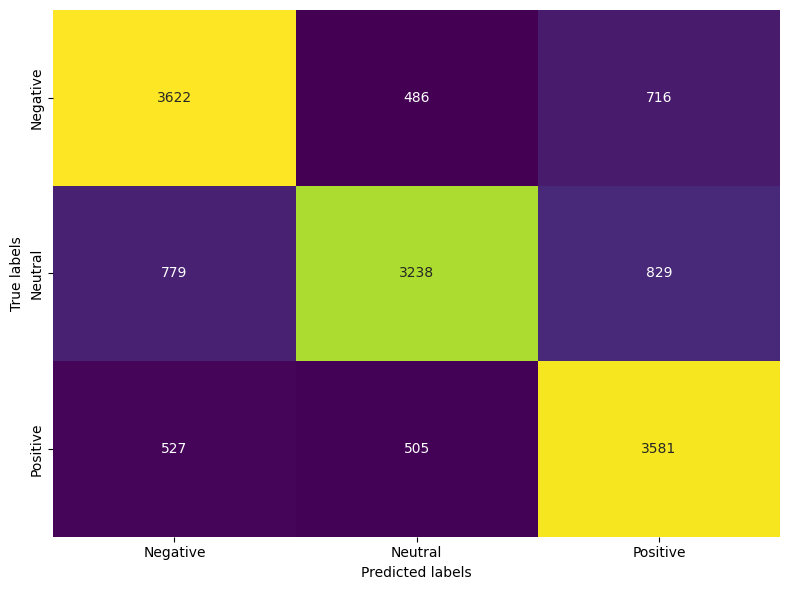

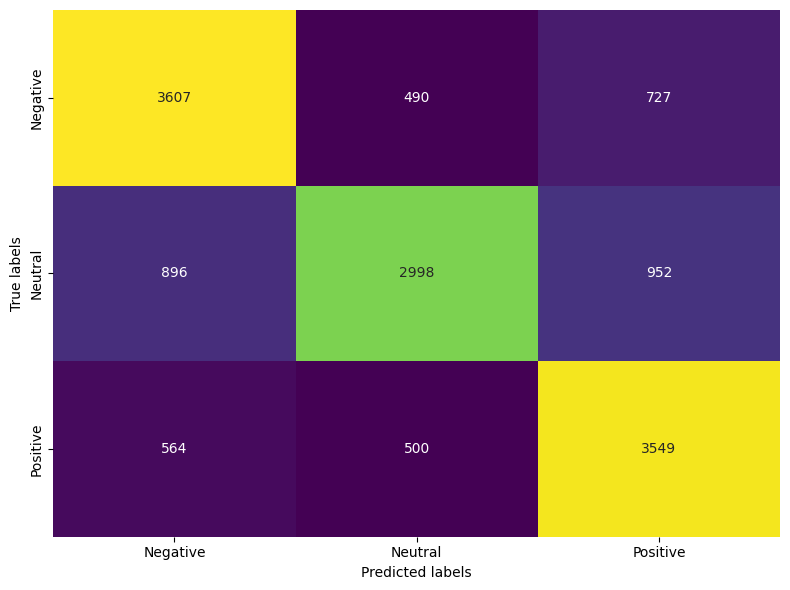

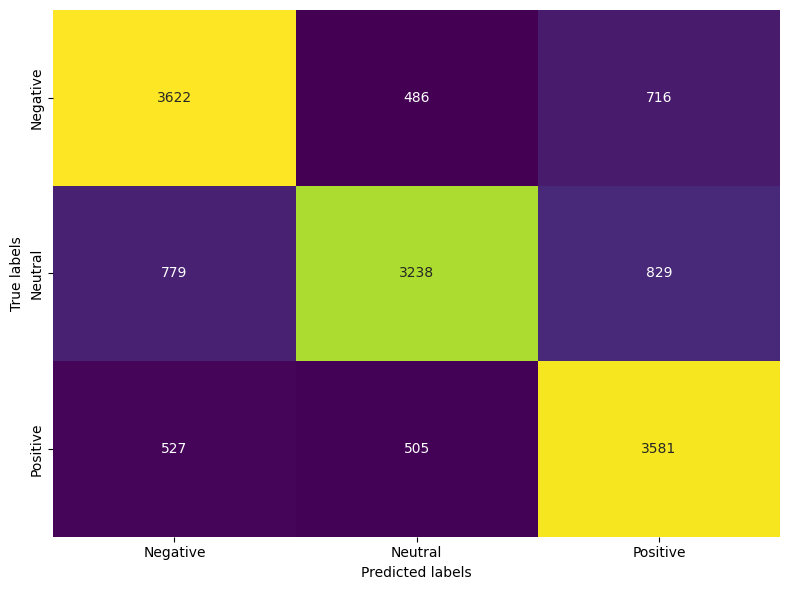

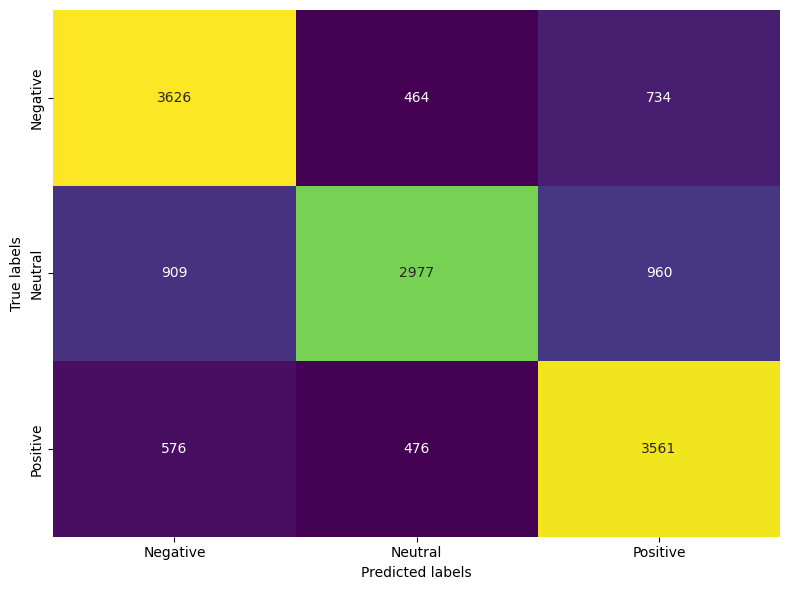

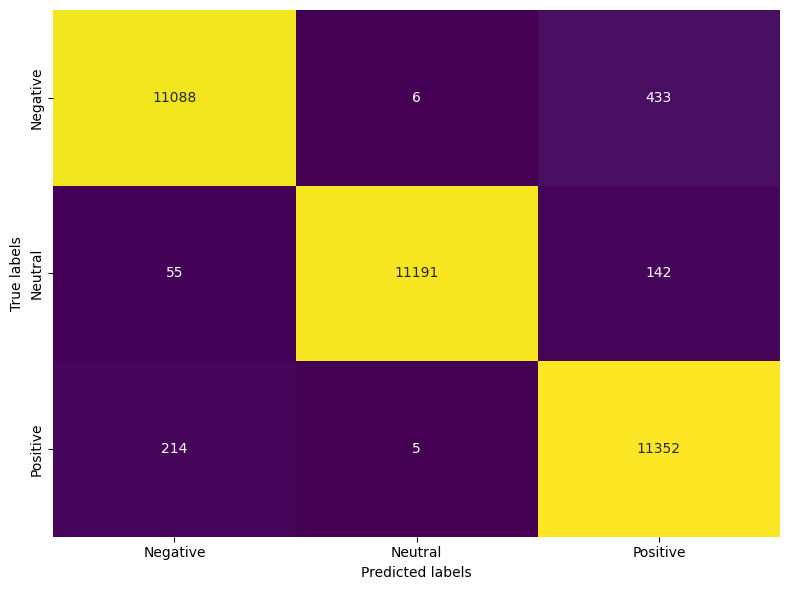

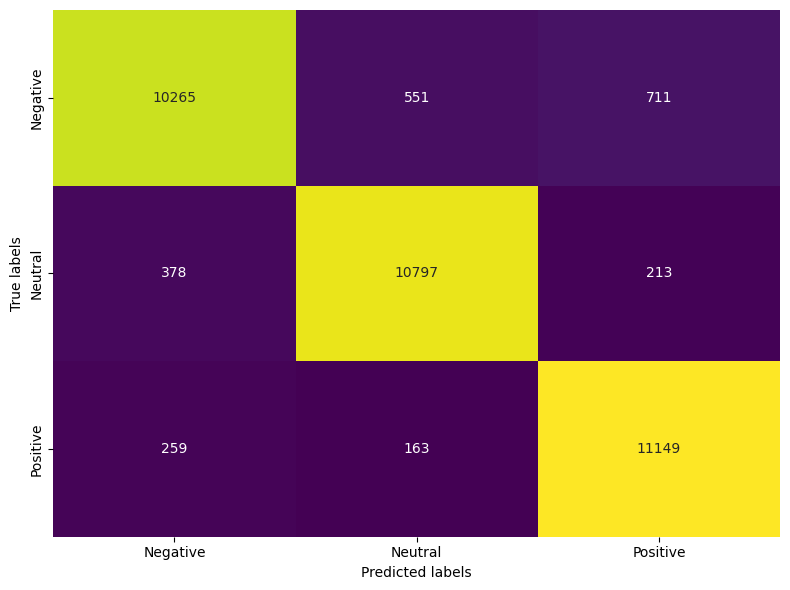

In [115]:
#Save confusion matrices for each dataset
confusion_matrix_figures_rf = []
for i, dataset_name in enumerate(['downsampled_TF-IDF', 'downsampled_CountVectorizer', 
                                  'random_oversampled_TF-IDF', 'random_oversampled_CountVectorizer', 
                                  'SMOTE_oversampled_TF-IDF', 'SMOTE_oversampled_CountVectorizer']):
    confusion_matrix_fig = plot_confusion_matrix_all(cms_rf[i], dataset_name)
    confusion_matrix_fig.savefig(f'rf_cm_{dataset_name}.png')
    confusion_matrix_figures_rf.append(confusion_matrix_fig)

**Summary of ML models**

TF-IDF outperformed CV for both NB and RF. The performane of both NB and RF was best for SMOTE oversampled dataset. 
TF-IDF-RF on SMOTE oversampled dataset achieved excellent accuracy at 98%.

All balancing techniques do a good job improving neutral class classification performance (indicated by precision, recall, F1-score). SMOTE outperformed downsampling and random-sampling.

**Word embedding for DL models**

SMOTE balanced data that has been vectorised can't be fed into word embedding models as they expect tokenised data as input.

Only the downsampled_df and random_oversampling_df can be used as input to word embedding model for comparison of DL classifier performance.

downsampled_sequences, downsampled_tokenizer
top_five_diseases_sequences, top_five_diseases_tokenizer

I don't have sequences for random_oversampling_df but do for top_five_diseases_tokeniser, a smaller dataset, but random_oversampling was created from this dataset so it is essentially an enlarged version with duplicated data, the vocabulary and tokenization patterns should still be well-captured by the tokenizer trained on the smaller dataset.

Need to pad sequences to ensure uniform length.

To use pre-trained word embeddings like GloVe, load and use as the initial weights for an Embedding layer in the neural network (GRU or LSTM). 

*GloVe word embedding*

Pennington, J., Socher, R. & Manning, C. D. (2014) GloVe: global vectors for word representation. Available online: https://nlp.stanford.edu/projects/glove/ [Accessed 13/03/2024].

Using:
Common Crawl (42B tokens, 1.9M vocab, uncased, 300d vectors, 1.75 GB download): glove.42B.300d.zip

In [16]:
#import pickle
#Load tokenizer and sequence for top_five_diseases
with open('top_five_diseases_sequences.pkl', 'rb') as file:
    top_five_diseases_sequences = pickle.load(file)
    
with open('top_five_diseases_tokenizer.pkl', 'rb') as file:
    top_five_diseases_tokenizer = pickle.load(file)

In [17]:
#Load tokenizer and sequence for balanced downsampled data
with open('downsampled_sequences.pkl', 'rb') as file:
    downsampled_sequences = pickle.load(file)
    
with open('downsampled_tokenizer.pkl', 'rb') as file:
    downsampled_tokenizer = pickle.load(file)

*Pad sequences*

Make all sequences the same length. Required for DL classification models.

In [56]:
#Calculate sequence lengths for downsampled_sequences and top_five_diseases_sequences
sequence_lengths_downsampled = [len(seq) for seq in downsampled_sequences]
sequence_lengths_top_five_diseases = [len(seq) for seq in top_five_diseases_sequences]
max_sequence_length_downsampled = np.max(sequence_lengths_downsampled)
max_sequence_length_top_five_diseases = np.max(sequence_lengths_top_five_diseases)
print("Maximum sequence length downsampled data:", max_sequence_length_downsampled)
print("Maximum sequence length top_five_diseases data:", max_sequence_length_top_five_diseases)

#Pad the sequences to ensure all same length
#from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequences_downsampled = pad_sequences(downsampled_sequences, maxlen=max_sequence_length_downsampled)
padded_sequences_top_five_diseases = pad_sequences(top_five_diseases_sequences, maxlen=max_sequence_length_top_five_diseases)

Maximum sequence length downsampled data: 269
Maximum sequence length top_five_diseases data: 269


*Load GloVe embeddings and create embedding_index*

In [57]:
#Number of unique words in downsampled_tokenizer dictionary
print("Number of unique words in downsampled_tokenizer dictionary=", 
      len(downsampled_tokenizer.word_index))

Number of unique words in downsampled_tokenizer dictionary= 20451


In [58]:
#Number of unique words in top_five_diseases_tokenizer dictionary
print("Number of unique words in top_five_diseases_tokenizer dictionary=", 
      len(top_five_diseases_tokenizer.word_index))

Number of unique words in top_five_diseases_tokenizer dictionary= 16958


In [59]:
#File path for embeddings
glove_file_path = 'C:\\Users\\873958\\OneDrive - hull.ac.uk\\Applied Artificial Intelligence 771767\\Assignment\\glove.42B.300d\\glove.42B.300d.txt'

In [60]:
#Function to create embedding index and print hits and misses
def create_embedding_index(file_path, tokenizer):
    """
    Creates an embedding index from a GloVe embeddings file, along with hit and miss counts.

    Parameters:
    file_path (str): Path to the GloVe embeddings file.
    tokenizer (keras.preprocessing.text.Tokenizer): Tokenizer object containing the word index.

    Returns:
    dict: Dictionary containing word embeddings indexed by words.
    int: Number of words in the tokenizer's word index with corresponding embeddings found in the GloVe file.
    int: Number of words in the tokenizer's word index with no corresponding embeddings found in the GloVe file.
    """
    embeddings_index = {}
    hits = 0
    misses = 0
    
    #Load embedding vectors from the file
    with open(file_path, encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    #Count hits and misses
    for word in tokenizer.word_index.keys():
        if word in embeddings_index:
            hits += 1
        else:
            misses += 1
    
    return embeddings_index, hits, misses

In [61]:
#Run the function for downsampled_tokenizer to get the embedding index and number of hits and misses for word_index in GloVe embeddings
downsampled_embeddings_index, hits, misses = create_embedding_index(glove_file_path, downsampled_tokenizer)
print("Number of hits:", hits)
print("Number of misses:", misses)

Number of hits: 18042
Number of misses: 2409


In [62]:
#Run the function for top_five_diseases_tokenizer
top_five_diseases_embeddings_index, hits, misses = create_embedding_index(glove_file_path, top_five_diseases_tokenizer)
print("Number of hits:", hits)
print("Number of misses:", misses)

Number of hits: 15366
Number of misses: 1592


Misses are quite small in comparison to hits for both datasets so going to stick with this particular embedding file.

*Create embedding matrix*

In [18]:
#Define embedding dimnesions and vaocabulary size
embedding_dim = 300  #Dimensionality of GloVe embeddings
vocab_size_downsampled = len(downsampled_tokenizer.word_index) + 1  #Vocabulary size (adding 1 for reserved 0 index)
vocab_size_top_five_diseases = len(top_five_diseases_tokenizer.word_index) + 1  

In [19]:
#Function to create embedding matrix
def create_embedding_matrix(tokenizer, embeddings_index, vocab_size):
    """
    Creates an embedding matrix using GloVe word embeddings.

    Parameters:
    tokenizer (keras.preprocessing.text.Tokenizer): Tokenizer object containing the word index.
    embeddings_index (dict): Dictionary containing GloVe word embeddings indexed by words.
    embedding_num (int): Dimensionality of GloVe embeddings.

    Returns:
    numpy.ndarray: Embedding matrix where each row corresponds to a word index and contains the word embedding.
    """
    #Initialize embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    #Fill embedding matrix
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [64]:
#Create the embedding matrix for downsampled_tokenizer and top_five_diseases_tokenizer
embedding_matrix_downsampled = create_embedding_matrix(downsampled_tokenizer, downsampled_embeddings_index, vocab_size_downsampled)
embedding_matrix_top_five_diseases = create_embedding_matrix(top_five_diseases_tokenizer, top_five_diseases_embeddings_index, vocab_size_top_five_diseases)

In [65]:
#Print a sample of one of the embedding matrices
print("Sample of the downsampled embedding matrix:")
for i in range(5):  #Print the first 5 rows
    print(f"Word index {i}: {embedding_matrix_downsampled[i]}")

Sample of the downsampled embedding matrix:
Word index 0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Word index 1: [-4.35039997e-

First row of embeddings is representing padding token.

In [66]:
#Save the embedding matrices
np.save('embedding_matrix_downsampled.npy', embedding_matrix_downsampled)
np.save('embedding_matrix_top_five_diseases.npy', embedding_matrix_top_five_diseases)

In [10]:
#Load the embedding matrices
embedding_matrix_downsampled = np.load('embedding_matrix_downsampled.npy')
embedding_matrix_top_five_diseases = np.load('embedding_matrix_top_five_diseases.npy')

*Create train test splits for model training*

Not one hot encoding sequences to reduce dimensionality and decrease memory requirements. Going to use sparse_categorical_crossentropy as loss function (suitable for non one hot encoded data).

In [67]:
#Filter out missing values from down df
down_df = down_df.dropna()

#Split downsampled_df into features (X) and target (y)
X_down_dl = down_df['cleaned_review']
y_down_dl = down_df['sentiment_class']

#Convert text data to sequences using the downsampled tokenizer
X_down_sequences = downsampled_tokenizer.texts_to_sequences(X_down_dl)

#Calculate sequence lengths for downsampled_sequences and top_five_diseases_sequences
sequence_lengths_X_down_sequences = [len(seq) for seq in X_down_sequences]
max_sequence_length_X_down_sequences = np.max(sequence_lengths_X_down_sequences)
print("Maximum sequence length X_down_sequences:", max_sequence_length_X_down_sequences)

Maximum sequence length X_down_sequences: 135


In [68]:
#Drop and NaN values from random oversampling df
random_oversampling_df = random_oversampling_df.dropna()

#Split random_oversampling_df into features (X) and target (y)
X_random_over_dl = random_oversampling_df['cleaned_review']
y_random_over_dl = random_oversampling_df['sentiment_class']

#Convert text data to sequences using the top_five_diseases_tokenizer
X_random_over_sequences = top_five_diseases_tokenizer.texts_to_sequences(X_random_over_dl)

#Calculate sequence lengths for downsampled_sequences and top_five_diseases_sequences
sequence_lengths_X_random_over_sequences = [len(seq) for seq in X_random_over_sequences]
max_sequence_length_X_random_over_sequences = np.max(sequence_lengths_X_random_over_sequences)
print("Maximum sequence length X_random_over_sequences:", max_sequence_length_X_random_over_sequences)

Maximum sequence length X_random_over_sequences: 130


In [69]:
#Pad the sequences to ensure all same length
#from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequences_X_down_sequences = pad_sequences(X_down_sequences, maxlen=max_sequence_length_X_down_sequences)
padded_sequences_X_random_over_sequences = pad_sequences(X_random_over_sequences, maxlen=max_sequence_length_X_random_over_sequences)

In [70]:
#Perform train-test split (75/25)
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(padded_sequences_X_down_sequences, y_down_dl, test_size=0.25, random_state=42)

In [71]:
X_train_random_over, X_test_random_over, y_train_random_over, y_test_random_over = train_test_split(padded_sequences_X_random_over_sequences, y_random_over_dl, test_size=0.25, random_state=42)

In [72]:
#Split the original training data into a smaller subset (10%)
X_train_down_subset, _, y_train_down_subset, _ = train_test_split(X_train_down, y_train_down, train_size=0.10, random_state=42, stratify=y_train_down)
X_train_random_over_subset, _, y_train_random_over_subset, _ = train_test_split(X_train_random_over, y_train_random_over, train_size=0.10, random_state=42, stratify=y_train_random_over)

In [73]:
#Print shape of train subsets
print("Shape of X_train_down_subset:", X_train_down_subset.shape)
print("Shape of y_train_down_subset:", y_train_down_subset.shape)

Shape of X_train_down_subset: (4284, 135)
Shape of y_train_down_subset: (4284,)


In [74]:
#import pickle
#Save train-test splits for downsampled data
with open('downsampled_train_test_splits.pkl', 'wb') as file:
    pickle.dump((X_train_down, X_test_down, y_train_down, y_test_down), file)

#Save train-test splits for downsampled data- subsampled 10% training data
with open('downsampled_train_test_splits_subsampled.pkl', 'wb') as file:
    pickle.dump((X_train_down_subset, X_test_down, y_train_down_subset, y_test_down), file)
    
#Save train-test splits for randomly oversampled data
with open('random_oversampled_train_test_splits.pkl', 'wb') as file:
    pickle.dump((X_train_random_over_subset, X_test_random_over, y_train_random_over_subset, y_test_random_over), file)

#Save train-test splits for randomly oversampled data- subsampled 10% training data
with open('random_oversampled_train_test_splits_subsampled.pkl', 'wb') as file:
    pickle.dump((X_train_random_over_subset, X_test_random_over, y_train_random_over_subset, y_test_random_over), file)

In [11]:
#Load train-test splits for downsampled data
with open('downsampled_train_test_splits.pkl', 'rb') as file:
    X_train_down, X_test_down, y_train_down, y_test_down = pickle.load(file)
    
#Load train-test splits for downsampled data- subsampled 10% training data
with open('downsampled_train_test_splits_subsampled.pkl', 'rb') as file:
    X_train_down_subset, X_test_down, y_train_down_subset, y_test_down = pickle.load(file)

#Load train-test splits for random_oversampled data
with open('random_oversampled_train_test_splits.pkl', 'rb') as file:
    X_train_random_over, X_test_random_over, y_train_random_over, y_test_random_over = pickle.load(file)
    
#Load train-test splits for random_oversampled data
with open('random_oversampled_train_test_splits_subsampled.pkl', 'rb') as file:
    X_train_random_over_subset, X_test_random_over, y_train_random_over_subset, y_test_random_over = pickle.load(file)

**DL model development**

Going to optimise GRU and LSTM on pre-trained word embeddings (GloVe) using random oversampling dataset.

Train on 10% subset data.

In this section:

1. Optimise GRU archiecture and hyperparemeters/regularisation comparing to baseline architecture.
2. Optimise model hyperparameters and regularisation using Ransomised search and 5-fold cross-validation
3. Determine if overfitting by monitoring training and validation accuracy and loss
4. Evaluate models with confusion matrix and classification report
5. Explore reducing batch size from 64 to 32 for GRU model
6. Build and optimise LSTM model, compare to GRU performance
7. Build and optimise BiLSTM model, compared to GRU/LSTM performance

**Build GRU model**

Optimise model and hyperparameters using randomised search and cross-validation (5-fold) and number of layers, play around with regularisation as well.

Chose randomised search due to computational time of gridsearch in reasonably large parameter space. 

Chosen activation function as 'relu' 
Chosen optmizer is 'adam'
This is based on previous literature and because this a common non-linear function preventing gradient issues.

Optimising for dropout, l1/l2 regularisation, recurrent_dropout, dense_dropout (all regulariation methods), number of dense layers, number of GRU/LSTM layers, batch size.

Architecture based on baseline model published by:

Haque, R., Laskar, S. H., Khushbu, K. G., Hasan, M. J. & Uddin, J. (2023) Data-driven solution to identify sentiments from online drug reviews. Computers, 12(4), 87.

*Build embedding layers (downsampled or random oversampled) for DL (LSTM or GRU) models*

#from tensorflow.keras.layers import Embedding
#from tensorflow.keras.initializers import Constant
downsampled_embedding_layer = Embedding(input_dim=vocab_size_downsampled,
                              output_dim=embedding_dim,
                              embeddings_initializer=Constant(embedding_matrix_downsampled),
                              input_length=X_train_down_subset.shape[1],
                              trainable=True)  #Set trainable=True if want embeddings to update during training

In [20]:
random_oversampled_embedding_layer = Embedding(input_dim=vocab_size_top_five_diseases,
                                     output_dim=embedding_dim,
                                     embeddings_initializer=Constant(embedding_matrix_top_five_diseases),
                                     input_length=X_train_random_over_subset.shape[1], #Length of subset
                                     trainable=True)  #Set trainable=True if want embeddings to update during training

*Model build and optmisation*

Chosen random_oversampled data to build DL models.

Starting with one layer GRU/LSTM.

Original baseline architecture uses Flatten layer with word embeddings, but don't think this is necessarily required for embedding matrix input. So the affect of flatten layer on performance will be explored.

Will run baseline model architecture first (albeit this was for the entire drugs.com dataset) and then optimise accordingly.

May need to play around with number of dense/dropout layers.

In [104]:
#from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Flatten
#from tensorflow.keras.models import Sequential
#from sklearn.model_selection import RandomizedSearchCV
#from keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras import regularizers
#Define the model architecture
#This is the architecture used in the Haque paper, 3 dense/dropout layers (units 64,32,16) and flatten layer
#Learning rate in paper was 0.01, but including in hyperparameter optimisation for this smaller dataset
#Dropout layer between GRU and classification layer
#Function to use on oversampled data
def gru_model_over(units=64, dropout=0.5, optimizer='adam',
              learning_rate=0.001, activation='relu',
              recurrent_dropout=0.1, regularization=None, 
              alpha=None, lambda_=None,
              dense_dropout=0.5, num_dense_layers=3):
    """
    Creates a GRU model with baseline architecture with dropout for sentiment analysis for oversampled data.

    Parameters:
    units (int): Dimensionality of the output space (number of units in the GRU layer).
    dropout (float): Dropout rate for the input units.
    optimizer (str): Adam optimizer to use for training.
    learning_rate (float): Learning rate for the optimizer.
    activation (str): ReLU activation function.
    recurrent_dropout (float): Dropout rate for the recurrent units.
    regularization (str or None): Regularization technique to use. Supported values are 'l1', 'l2', or None.
    alpha (float or None): Regularization strength for L1 regularization.
    lambda_ (float or None): Regularization strength for L2 regularization.
    dense_dropout (float): Dropout rate for the dense layers.
    num_dense_layers (int): Number of dense layers to add between GRU and the classification dense layer.

    Returns:
    keras.models.Sequential: Compiled GRU model.
    """
    #Build layers
    model = Sequential()
    #Add random_oversampled_embedding_layer
    model.add(random_oversampled_embedding_layer)
    #Add dropout layer after embedding layer
    model.add(Dropout(dropout))
    
    #Add GRU layer with dynamic regularization
    if regularization == 'l1':
        kernel_regularizer = regularizers.l1(alpha)
        recurrent_regularizer = regularizers.l1(alpha)
    elif regularization == 'l2':
        kernel_regularizer = regularizers.l2(lambda_)
        recurrent_regularizer = regularizers.l2(lambda_)
    else:
        kernel_regularizer = None
        recurrent_regularizer = None

    model.add(GRU(units=units, dropout=dropout,
                  recurrent_dropout=recurrent_dropout,
                  kernel_regularizer=kernel_regularizer,
                  recurrent_regularizer=recurrent_regularizer))
    
    #Define units for dense layers
    dense_units = [64, 32, 16]

    #Three dense and dropout layers
    for i in range(num_dense_layers):
        model.add(Dense(units=dense_units[i], activation=activation))
        model.add(Dropout(dense_dropout))

    #Add Flatten layer converting to 1D array
    model.add(Flatten())

    #Add classification dense layer
    model.add(Dense(units=3, activation='softmax'))

    #Compile model
    #Not using one-hot encoding so need to use sparse_categorical_crossentropy to handle integer labels
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

#Wrap the Keras model with KerasClassifier
model_wrapper_gru = KerasClassifier(build_fn=gru_model_over)

#Large parameter space!
param_dist = {
    'units': [32, 64, 128],
    'dropout': [0.2, 0.3, 0.4, 0.5],
    'learning_rate': [0.001, 0.01, 0.1],
    'recurrent_dropout': [0.1, 0.2, 0.3],
    'regularization': ['l1', 'l2', None], #L1/L2 regularisation or None
    'alpha': [0.001, 0.01, 0.1], #Hyperparameter specific to L1 regularization
    'lambda_': [0.001, 0.01, 0.1], #Hyperparameter specific to L2 regularization
    'dense_dropout': [0.2, 0.3, 0.4] #Dropout rate for dense layers
}

#Create RandomizedSearchCV objects 
#5-fold CV with 50 iterations
#Trad off with computational time and parameter space coverage
random_search_oversampled_gru = RandomizedSearchCV(
    estimator=model_wrapper_gru,
    param_distributions=param_dist,
    n_iter=50,  #Number of candidates sampled, very small proportion of feature space
    scoring='accuracy',
    cv=5, #5-fold cross-validation
    verbose=2,  #Displays a summary of each iteration, including the current parameter settings and the best score so far
    n_jobs=-1, #Use all available processors
    error_score='raise'
)

C:\Users\local_8739582\Temp\ipykernel_28736\3631371035.py:80: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_wrapper_gru = KerasClassifier(build_fn=gru_model_over)


In [105]:
#Fit the RandomizedSearchCV objects to the subset (10%) training data
random_search_oversampled_gru.fit(X_train_random_over_subset, y_train_random_over_subset)

#Get the best parameters and best score for each RandomizedSearchCV object
print("Best parameters found for oversampled data:", random_search_oversampled_gru.best_params_)
print("Best accuracy found for oversampled data:", random_search_oversampled_gru.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
134/134 [==============================] - 43s 304ms/step - loss: 1.0750 - accuracy: 0.3959
Best parameters found for oversampled data: {'units': 128, 'regularization': None, 'recurrent_dropout': 0.1, 'learning_rate': 0.001, 'lambda_': 0.001, 'dropout': 0.2, 'dense_dropout': 0.2, 'alpha': 0.001}
Best accuracy found for oversampled data: 0.5011755853389894


For the oversampled dataset, optimising using cross validation (5-fold, 10 iterations), the accuracy is not great (0.501). The flatten layer will be removed and the number of dense/dropout layers preceding the classification layer will also be explored. The fully connected dense layers with dropout are important to transform data through weighted connections using activation function and improve generalisation of model with regularisation to prevent overfitting, respectively.

In [106]:
#Function for gru model without flatten layer
def gru_model_over_noflatten(units=64, dropout=0.5, optimizer='adam',
              learning_rate=0.001, activation='relu',
              recurrent_dropout=0.1, regularization=None, 
              alpha=None, lambda_=None,
              dense_dropout=0.5, num_dense_layers=3):
    """
    Creates a one-layer GRU model with dropout for sentiment analysis for oversampled data. No flatten layer.

    Parameters:
    units (int): Dimensionality of the output space (number of units in the GRU layer).
    dropout (float): Dropout rate for the input units.
    optimizer (str): Adam optimizer to use for training.
    learning_rate (float): Learning rate for the optimizer.
    activation (str): ReLU activation function.
    recurrent_dropout (float): Dropout rate for the recurrent units.
    regularization (str or None): Regularization technique to use. Supported values are 'l1', 'l2', or None.
    alpha (float or None): Regularization strength for L1 regularization.
    lambda_ (float or None): Regularization strength for L2 regularization.
    dense_dropout (float): Dropout rate for the dense layers.
    num_dense_layers (int): Number of dense layers to add between GRU and the classification dense layer.

    Returns:
    keras.models.Sequential: Compiled GRU model.
    """
    #Build layers
    model = Sequential()
    #Add random_oversampled_embedding_layer
    model.add(random_oversampled_embedding_layer)
    #Add dropout layer after embedding layer
    model.add(Dropout(dropout))
    #Add GRU layer with dynamic regularization
    if regularization == 'l1':
        kernel_regularizer = regularizers.l1(alpha)
        recurrent_regularizer = regularizers.l1(alpha)
    elif regularization == 'l2':
        kernel_regularizer = regularizers.l2(lambda_)
        recurrent_regularizer = regularizers.l2(lambda_)
    else:
        kernel_regularizer = None
        recurrent_regularizer = None

    model.add(GRU(units=units, dropout=dropout,
                  recurrent_dropout=recurrent_dropout,
                  kernel_regularizer=kernel_regularizer,
                  recurrent_regularizer=recurrent_regularizer))
    
    #Define units for dense layers
    dense_units = [64, 32, 16]

    #Three dense and dropout layers
    for i in range(num_dense_layers):
        model.add(Dense(units=dense_units[i], activation=activation))
        model.add(Dropout(dense_dropout))

    #Add classification dense layer
    model.add(Dense(units=3, activation='softmax'))

    #Compile model
    #Not using one-hot encoding so need to use sparse_categorical_crossentropy to handle integer labels
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

#Wrap the Keras model with KerasClassifier
model_wrapper_gru_noflatten = KerasClassifier(build_fn=gru_model_over_noflatten)

#Create RandomizedSearchCV objects 
random_search_oversampled_gru_noflatten = RandomizedSearchCV(
    estimator=model_wrapper_gru_noflatten,
    param_distributions=param_dist,
    n_iter=50,  #Number of candidates sampled, very small proportion of feature space (0.01%!)
    scoring='accuracy',
    cv=5, #5-fold cross-validation
    verbose=2,  #Displays a summary of each iteration, including the current parameter settings and the best score so far
    n_jobs=-1, #Use all available processors
    error_score='raise'
)

C:\Users\local_8739582\Temp\ipykernel_28736\4173825123.py:66: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_wrapper_gru_noflatten = KerasClassifier(build_fn=gru_model_over_noflatten)


In [107]:
#Fit the RandomizedSearchCV objects to the subset (10%) training data
random_search_oversampled_gru_noflatten.fit(X_train_random_over_subset, y_train_random_over_subset)

#Get the best parameters and best score for each RandomizedSearchCV object
print("Best parameters found for oversampled data:", random_search_oversampled_gru_noflatten.best_params_)
print("Best accuracy found for oversampled data:", random_search_oversampled_gru_noflatten.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
134/134 [==============================] - 36s 253ms/step - loss: 1.0771 - accuracy: 0.4066
Best parameters found for oversampled data: {'units': 128, 'regularization': None, 'recurrent_dropout': 0.3, 'learning_rate': 0.1, 'lambda_': 0.1, 'dropout': 0.4, 'dense_dropout': 0.2, 'alpha': 0.01}
Best accuracy found for oversampled data: 0.4726946313482154


Accuracy has decreased marginally by removing flatten layer with 3 dense layer (0.473)

Run for 2 dense/dropout layers after GRU layer. Reintroduce flatten layer after defining optimal dense/dropout layer number.

In [108]:
#Two dense/dropout layers before classfiication layer
def gru_model_over_twodense(units=64, dense_units=32, dropout=0.5, optimizer='adam',
              learning_rate=0.001, activation='relu',
              recurrent_dropout=0.1, regularization=None, 
              alpha=None, lambda_=None,
              dense_dropout=0.5):
    """
    Creates a one-layer GRU model with dropout for sentiment analysis for oversampled data. 2 dense/dropout layers.

    Parameters:
    units (int): Dimensionality of the output space (number of units in the GRU layer).
    dense_units (int): Dimensionality of the dense layer.
    dropout (float): Dropout rate for the input units.
    optimizer (str): Adam optimizer to use for training.
    learning_rate (float): Learning rate for the optimizer.
    activation (str): ReLU activation function.
    recurrent_dropout (float): Dropout rate for the recurrent units.
    regularization (str or None): Regularization technique to use. Supported values are 'l1', 'l2', or None.
    alpha (float or None): Regularization strength for L1 regularization.
    lambda_ (float or None): Regularization strength for L2 regularization.
    dense_dropout (float): Dropout rate for the dense layers.

    Returns:
    keras.models.Sequential: Compiled GRU model.
    """
    #Build layers
    model = Sequential()
    #Add random_oversampled_embedding_layer
    model.add(random_oversampled_embedding_layer)
    #Add dropout layer after embedding layer
    model.add(Dropout(dropout))
    #Add GRU layer with dynamic regularization
    if regularization == 'l1':
        kernel_regularizer = regularizers.l1(alpha)
        recurrent_regularizer = regularizers.l1(alpha)
    elif regularization == 'l2':
        kernel_regularizer = regularizers.l2(lambda_)
        recurrent_regularizer = regularizers.l2(lambda_)
    else:
        kernel_regularizer = None
        recurrent_regularizer = None

    model.add(GRU(units=units, dropout=dropout,
                  recurrent_dropout=recurrent_dropout,
                  kernel_regularizer=kernel_regularizer,
                  recurrent_regularizer=recurrent_regularizer))
    
    #Add dense and dropout layers (two)
    model.add(Dense(units=dense_units, activation=activation))
    model.add(Dropout(dense_dropout))
    #Second has 16 units as first has 32
    model.add(Dense(units=16, activation=activation))
    model.add(Dropout(dense_dropout))

    #No flatten layer
    #Add classification dense layer
    model.add(Dense(units=3, activation='softmax'))

    #Compile model
    #Not using one-hot encoding so need to use sparse_categorical_crossentropy to handle integer labels
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

#Wrap the Keras model with KerasClassifier
model_wrapper_gru_twodense = KerasClassifier(build_fn=gru_model_over_twodense)

#Create RandomizedSearchCV objects 
random_search_oversampled_gru_twodense = RandomizedSearchCV(
    estimator=model_wrapper_gru_twodense,
    param_distributions=param_dist,
    n_iter=50,  #Number of candidates sampled
    scoring='accuracy',
    cv=5, #5-fold cross-validation
    verbose=2,  #Displays a summary of each iteration, including the current parameter settings and the best score so far
    n_jobs=-1, #Use all available processors
    error_score='raise'
)

C:\Users\local_8739582\Temp\ipykernel_28736\610449911.py:66: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_wrapper_gru_twodense = KerasClassifier(build_fn=gru_model_over_twodense)


In [109]:
#Fit the RandomizedSearchCV objects to the subset (10%) training data
random_search_oversampled_gru_twodense.fit(X_train_random_over_subset, y_train_random_over_subset)

#Get the best parameters and best score for each RandomizedSearchCV object
print("Best parameters found for oversampled data:", random_search_oversampled_gru_twodense.best_params_)
print("Best accuracy found for oversampled data:", random_search_oversampled_gru_twodense.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Program Files\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


134/134 [==============================] - 45s 321ms/step - loss: 1.0824 - accuracy: 0.3896
Best parameters found for oversampled data: {'units': 128, 'regularization': None, 'recurrent_dropout': 0.1, 'learning_rate': 0.01, 'lambda_': 0.01, 'dropout': 0.3, 'dense_dropout': 0.2, 'alpha': 0.01}
Best accuracy found for oversampled data: 0.5287143262194789


Two dense/dropout layers (0.529) is slightly better accuracy than three layers (0.501).

Run for 1 dense/dropout layers after GRU layer.

In [110]:
#One dense/dropout layer before classfiication layer
def gru_model_over_onedense(units=64, dense_units=32, dropout=0.5, optimizer='adam',
              learning_rate=0.001, activation='relu',
              recurrent_dropout=0.1, regularization=None, 
              alpha=None, lambda_=None,
              dense_dropout=0.5):
    """
    Creates a one-layer GRU model with dropout for sentiment analysis for oversampled data. 1 dense/dropout layer.

    Parameters:
    units (int): Dimensionality of the output space (number of units in the GRU layer).
    dense_units (int): Dimensionality of the dense layer.
    dropout (float): Dropout rate for the input units.
    optimizer (str): Adam optimizer to use for training.
    learning_rate (float): Learning rate for the optimizer.
    activation (str): ReLU activation function.
    recurrent_dropout (float): Dropout rate for the recurrent units.
    regularization (str or None): Regularization technique to use. Supported values are 'l1', 'l2', or None.
    alpha (float or None): Regularization strength for L1 regularization.
    lambda_ (float or None): Regularization strength for L2 regularization.
    dense_dropout (float): Dropout rate for the dense layers.

    Returns:
    keras.models.Sequential: Compiled GRU model.
    """
    #Build layers
    model = Sequential()
    #Add random_oversampled_embedding_layer
    model.add(random_oversampled_embedding_layer)
    #Add dropout layer after embedding layer
    model.add(Dropout(dropout))
    #Add GRU layer with dynamic regularization
    if regularization == 'l1':
        kernel_regularizer = regularizers.l1(alpha)
        recurrent_regularizer = regularizers.l1(alpha)
    elif regularization == 'l2':
        kernel_regularizer = regularizers.l2(lambda_)
        recurrent_regularizer = regularizers.l2(lambda_)
    else:
        kernel_regularizer = None
        recurrent_regularizer = None

    model.add(GRU(units=units, dropout=dropout,
                  recurrent_dropout=recurrent_dropout,
                  kernel_regularizer=kernel_regularizer,
                  recurrent_regularizer=recurrent_regularizer))
    
    #One dense and dropout layer
    model.add(Dense(units=dense_units, activation=activation))
    model.add(Dropout(dense_dropout))

    #No flatten layer
    #Add classification dense layer
    model.add(Dense(units=3, activation='softmax'))

    #Compile model
    #Not using one-hot encoding so need to use sparse_categorical_crossentropy to handle integer labels
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

#Wrap the Keras model with KerasClassifier
model_wrapper_gru_onedense = KerasClassifier(build_fn=gru_model_over_onedense)

param_dist_2 = {
    'units': [32, 64, 128],
    'dropout': [0.2, 0.3, 0.4, 0.5],
    'learning_rate': [0.001, 0.01, 0.1],
    'recurrent_dropout': [0.1, 0.2, 0.3],
    'regularization': ['l1', 'l2', None],
    'alpha': [0.001, 0.01, 0.1], #Hyperparameter specific to L1 regularization
    'lambda_': [0.001, 0.01, 0.1], #Hyperparameter specific to L2 regularization
    'dense_dropout': [0.2, 0.3, 0.4], #Dropout rate for dense layers
    'dense_units': [16, 32, 64]
}


#Create RandomizedSearchCV objects 
random_search_oversampled_gru_onedense = RandomizedSearchCV(
    estimator=model_wrapper_gru_onedense,
    param_distributions=param_dist_2,
    n_iter=50,  #Number of candidates sampled
    scoring='accuracy',
    cv=5, #5-fold cross-validation
    verbose=2,  #Displays a summary of each iteration, including the current parameter settings and the best score so far
    n_jobs=-1, #Use all available processors
    error_score='raise'
)

C:\Users\local_8739582\Temp\ipykernel_28736\3472651185.py:63: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_wrapper_gru_onedense = KerasClassifier(build_fn=gru_model_over_onedense)


In [111]:
#Fit the RandomizedSearchCV objects to the subset (10%) training data
random_search_oversampled_gru_onedense.fit(X_train_random_over_subset, y_train_random_over_subset)

#Get the best parameters and best score for each RandomizedSearchCV object
print("Best parameters found for oversampled data:", random_search_oversampled_gru_onedense.best_params_)
print("Best accuracy found for oversampled data:", random_search_oversampled_gru_onedense.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
134/134 [==============================] - 34s 238ms/step - loss: 1.0277 - accuracy: 0.4673
Best parameters found for oversampled data: {'units': 128, 'regularization': None, 'recurrent_dropout': 0.3, 'learning_rate': 0.001, 'lambda_': 0.01, 'dropout': 0.3, 'dense_units': 32, 'dense_dropout': 0.2, 'alpha': 0.1}
Best accuracy found for oversampled data: 0.5539198900751371


Better accuracy with one dense/dropout layer (0.554)

Run for optimal dense layers (1, 2 or 3) determined above and remove dropout between embedding layer and GRU layer. This may have negative impact on generalisation but interested in impact on accuracy.

In [112]:
#One dense/dropout layers before classfiication layer, no droput layer after embedding layer
def gru_model_over_onedense_nodropout(units=64, dense_units=32, dropout=0.5, optimizer='adam',
              learning_rate=0.001, activation='relu',
              recurrent_dropout=0.1, regularization=None, 
              alpha=None, lambda_=None,
              dense_dropout=0.5):
    """
    Creates a one-layer GRU model with dropout for sentiment analysis for oversampled data. 1 dense/dropout layer.

    Parameters:
    units (int): Dimensionality of the output space (number of units in the GRU layer).
    dense_units (int): Dimensionality of the dense layer.
    dropout (float): Dropout rate for the input units.
    optimizer (str): Adam optimizer to use for training.
    learning_rate (float): Learning rate for the optimizer.
    activation (str): ReLU activation function.
    recurrent_dropout (float): Dropout rate for the recurrent units.
    regularization (str or None): Regularization technique to use. Supported values are 'l1', 'l2', or None.
    alpha (float or None): Regularization strength for L1 regularization.
    lambda_ (float or None): Regularization strength for L2 regularization.
    dense_dropout (float): Dropout rate for the dense layers.

    Returns:
    keras.models.Sequential: Compiled GRU model.
    """
    #Build layers
    model = Sequential()
    #Add random_oversampled_embedding_layer
    model.add(random_oversampled_embedding_layer)
    #Add GRU layer with dynamic regularization
    if regularization == 'l1':
        kernel_regularizer = regularizers.l1(alpha)
        recurrent_regularizer = regularizers.l1(alpha)
    elif regularization == 'l2':
        kernel_regularizer = regularizers.l2(lambda_)
        recurrent_regularizer = regularizers.l2(lambda_)
    else:
        kernel_regularizer = None
        recurrent_regularizer = None

    model.add(GRU(units=units, dropout=dropout,
                  recurrent_dropout=recurrent_dropout,
                  kernel_regularizer=kernel_regularizer,
                  recurrent_regularizer=recurrent_regularizer))
    
    #One dense and dropout layer
    model.add(Dense(units=dense_units, activation=activation))
    model.add(Dropout(dense_dropout))

    #No flatten layer
    #Add classification dense layer
    model.add(Dense(units=3, activation='softmax'))

    #Compile model
    #Not using one-hot encoding so need to use sparse_categorical_crossentropy to handle integer labels
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

#Wrap the Keras model with KerasClassifier
model_wrapper_gru_onedense_nodropout = KerasClassifier(build_fn=gru_model_over_onedense_nodropout)

#Create RandomizedSearchCV objects 
random_search_oversampled_gru_onedense_nodropout = RandomizedSearchCV(
    estimator=model_wrapper_gru_onedense_nodropout,
    param_distributions=param_dist_2,
    n_iter=50,  #Number of candidates sampled
    scoring='accuracy',
    cv=5, #5-fold cross-validation
    verbose=2,  #Displays a summary of each iteration, including the current parameter settings and the best score so far
    n_jobs=-1, #Use all available processors
    error_score='raise'
)

C:\Users\local_8739582\Temp\ipykernel_28736\1808147603.py:61: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_wrapper_gru_onedense_nodropout = KerasClassifier(build_fn=gru_model_over_onedense_nodropout)


In [113]:
#Fit the RandomizedSearchCV objects to the subset (10%) training data
random_search_oversampled_gru_onedense_nodropout.fit(X_train_random_over_subset, y_train_random_over_subset)

#Get the best parameters and best score for each RandomizedSearchCV object
print("Best parameters found for oversampled data:", random_search_oversampled_gru_onedense_nodropout.best_params_)
print("Best accuracy found for oversampled data:", random_search_oversampled_gru_onedense_nodropout.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
134/134 [==============================] - 35s 242ms/step - loss: 1.0106 - accuracy: 0.4818
Best parameters found for oversampled data: {'units': 128, 'regularization': None, 'recurrent_dropout': 0.3, 'learning_rate': 0.001, 'lambda_': 0.1, 'dropout': 0.4, 'dense_units': 16, 'dense_dropout': 0.2, 'alpha': 0.1}
Best accuracy found for oversampled data: 0.5824049335325359


Removing dropout layer between embedding layer and GRU lyer slightly improved accuracy, but not sure of affect on gernalisations.

Add flatten layer back in, see if reintroduction improves accuracy of model.

Conscious of not removing too many dropout layers as generalisation of model will be reduced and may overfit to validation and test data so may reintroduce this layer if overfitting observed.

In [114]:
#One dense/dropout layer before classfiication layer plus flatten, dropout after embedding removed
def gru_model_over_onedense_flatten(units=64, dense_units=32, dropout=0.5, optimizer='adam',
              learning_rate=0.001, activation='relu',
              recurrent_dropout=0.1, regularization=None, 
              alpha=None, lambda_=None,
              dense_dropout=0.5):
    """
    Creates a one-layer GRU model with dropout for sentiment analysis for oversampled data. 1 dense/dropout layer.

    Parameters:
    units (int): Dimensionality of the output space (number of units in the GRU layer).
    dense_units (int): Dimensionality of the dense layer.
    dropout (float): Dropout rate for the input units.
    optimizer (str): Adam optimizer to use for training.
    learning_rate (float): Learning rate for the optimizer.
    activation (str): ReLU activation function.
    recurrent_dropout (float): Dropout rate for the recurrent units.
    regularization (str or None): Regularization technique to use. Supported values are 'l1', 'l2', or None.
    alpha (float or None): Regularization strength for L1 regularization.
    lambda_ (float or None): Regularization strength for L2 regularization.
    dense_dropout (float): Dropout rate for the dense layers.

    Returns:
    keras.models.Sequential: Compiled GRU model.
    """
    #Build layers
    model = Sequential()
    #Add random_oversampled_embedding_layer
    model.add(random_oversampled_embedding_layer)

    #Add GRU layer with dynamic regularization
    if regularization == 'l1':
        kernel_regularizer = regularizers.l1(alpha)
        recurrent_regularizer = regularizers.l1(alpha)
    elif regularization == 'l2':
        kernel_regularizer = regularizers.l2(lambda_)
        recurrent_regularizer = regularizers.l2(lambda_)
    else:
        kernel_regularizer = None
        recurrent_regularizer = None

    model.add(GRU(units=units, dropout=dropout,
                  recurrent_dropout=recurrent_dropout,
                  kernel_regularizer=kernel_regularizer,
                  recurrent_regularizer=recurrent_regularizer))
    
    #One dense and dropout layer
    model.add(Dense(units=dense_units, activation=activation))
    model.add(Dropout(dense_dropout))

    #Reintroduce flatten layer
    model.add(Flatten())
    
    #Add classification dense layer
    model.add(Dense(units=3, activation='softmax'))

    #Compile model
    #Not using one-hot encoding so need to use sparse_categorical_crossentropy to handle integer labels
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

#Wrap the Keras model with KerasClassifier
model_wrapper_gru_onedense_flatten = KerasClassifier(build_fn=gru_model_over_onedense_flatten)

#Create RandomizedSearchCV objects 
random_search_oversampled_gru_onedense_flatten = RandomizedSearchCV(
    estimator=model_wrapper_gru_onedense_flatten,
    param_distributions=param_dist_2,
    n_iter=50,  #Number of candidates sampled
    scoring='accuracy',
    cv=5, #5-fold cross-validation
    verbose=2,  #Displays a summary of each iteration, including the current parameter settings and the best score so far
    n_jobs=-1, #Use all available processors
    error_score='raise'
)

C:\Users\local_8739582\Temp\ipykernel_28736\3145627223.py:64: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_wrapper_gru_onedense_flatten = KerasClassifier(build_fn=gru_model_over_onedense_flatten)


In [115]:
#Fit the RandomizedSearchCV objects to the subset (10%) training data
random_search_oversampled_gru_onedense_flatten.fit(X_train_random_over_subset, y_train_random_over_subset)

#Get the best parameters and best score for each RandomizedSearchCV object
print("Best parameters found for oversampled data:", random_search_oversampled_gru_onedense_flatten.best_params_)
print("Best accuracy found for oversampled data:", random_search_oversampled_gru_onedense_flatten.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
134/134 [==============================] - 28s 198ms/step - loss: 0.9705 - accuracy: 0.5119
Best parameters found for oversampled data: {'units': 128, 'regularization': None, 'recurrent_dropout': 0.2, 'learning_rate': 0.001, 'lambda_': 0.1, 'dropout': 0.3, 'dense_units': 64, 'dense_dropout': 0.2, 'alpha': 0.1}
Best accuracy found for oversampled data: 0.6122839398466723


Remove all dense layers and dropout layer between embedding layer and GRU layer, Only dropout in GRU layer. Does accuracy improve? But poor generalisation potentially?

In [116]:
#GRU only
def gru_model_over_gruonly(units=64, dropout=0.5, optimizer='adam',
              learning_rate=0.001, activation='relu',
              recurrent_dropout=0.1, regularization=None, 
              alpha=None, lambda_=None):
    """
    Creates a one-layer GRU model with dropout for sentiment analysis for oversampled data. 1 dense/dropout layer.

    Parameters:
    units (int): Dimensionality of the output space (number of units in the GRU layer).
    dense_units (int): Dimensionality of the dense layer.
    dropout (float): Dropout rate for the input units.
    optimizer (str): Adam optimizer to use for training.
    learning_rate (float): Learning rate for the optimizer.
    activation (str): ReLU activation function.
    recurrent_dropout (float): Dropout rate for the recurrent units.
    regularization (str or None): Regularization technique to use. Supported values are 'l1', 'l2', or None.
    alpha (float or None): Regularization strength for L1 regularization.
    lambda_ (float or None): Regularization strength for L2 regularization.
    dense_dropout (float): Dropout rate for the dense layers.

    Returns:
    keras.models.Sequential: Compiled GRU model.
    """
    #Build layers
    model = Sequential()
    #Add random_oversampled_embedding_layer
    model.add(random_oversampled_embedding_layer)

    #Add GRU layer with dynamic regularization
    if regularization == 'l1':
        kernel_regularizer = regularizers.l1(alpha)
        recurrent_regularizer = regularizers.l1(alpha)
    elif regularization == 'l2':
        kernel_regularizer = regularizers.l2(lambda_)
        recurrent_regularizer = regularizers.l2(lambda_)
    else:
        kernel_regularizer = None
        recurrent_regularizer = None

    model.add(GRU(units=units, dropout=dropout,
                  recurrent_dropout=recurrent_dropout,
                  kernel_regularizer=kernel_regularizer,
                  recurrent_regularizer=recurrent_regularizer))
    
    #Add classification dense layer
    model.add(Dense(units=3, activation='softmax'))

    #Compile model
    #Not using one-hot encoding so need to use sparse_categorical_crossentropy to handle integer labels
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

#Wrap the Keras model with KerasClassifier
model_wrapper_gru_only = KerasClassifier(build_fn=gru_model_over_gruonly)

param_dist_3 = {
    'units': [32, 64, 128],
    'dropout': [0.2, 0.3, 0.4, 0.5],
    'learning_rate': [0.001, 0.01, 0.1],
    'recurrent_dropout': [0.1, 0.2, 0.3],
    'regularization': ['l1', 'l2', None], 
    'alpha': [0.001, 0.01, 0.1], #Hyperparameter specific to L1 regularization
    'lambda_': [0.001, 0.01, 0.1], #Hyperparameter specific to L2 regularization
}

#Create RandomizedSearchCV objects
random_search_oversampled_gru_only = RandomizedSearchCV(
    estimator=model_wrapper_gru_only,
    param_distributions=param_dist_3,
    n_iter=50,  #Number of candidates sampled
    scoring='accuracy',
    cv=5, #5-fold cross-validation
    verbose=2,  #Displays a summary of each iteration, including the current parameter settings and the best score so far
    n_jobs=-1, #Use all available processors
    error_score='raise'
)

C:\Users\local_8739582\Temp\ipykernel_28736\3304854429.py:56: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_wrapper_gru_only = KerasClassifier(build_fn=gru_model_over_gruonly)


In [117]:
#Fit the RandomizedSearchCV objects to the subset (10%) training data
random_search_oversampled_gru_only.fit(X_train_random_over_subset, y_train_random_over_subset)

#Get the best parameters and best score for each RandomizedSearchCV object
print("Best parameters found for oversampled data:", random_search_oversampled_gru_only.best_params_)
print("Best accuracy found for oversampled data:", random_search_oversampled_gru_only.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
134/134 [==============================] - 29s 203ms/step - loss: 0.9083 - accuracy: 0.5654
Best parameters found for oversampled data: {'units': 128, 'regularization': None, 'recurrent_dropout': 0.1, 'learning_rate': 0.01, 'lambda_': 0.001, 'dropout': 0.3, 'alpha': 0.01}
Best accuracy found for oversampled data: 0.6367885691228912


**Summary of hyperparameter optimisation, including regularisation for GRU model**

The best accuracy for training was obtained for simpler architectures, with fewer dens/dropout layers. However, overfitting may occur due to the simplicity of the architectures.

Recognise that only a very small proportion of the parameter space was explored using randmonised search with 50 iterations and 5-fold cross validation but this has advantages over computational time required for grid search.

*Run optimised GRU model on entire oversampled training data*

Going to run three models optimised above:

1. gru_model_over_gruonly because this has the highest accuracy during optimisation (0.637). However, this only consists of embeddings, GRU and classification layer. There is dropout in the GRU layer, but overfitting may occur due to lack of additional dense/dropout layers and dropout between embedding layer and GRU layer, include in baseline architecture. It is a trade-off between model simplicity and too much complexity that may see overfitting.

2. gru_model_over_onedense_flatten this has the second highest training accuracy (0.612), includes flatten layer, one dense/dropout layer but no dropout after embedding layer.

3. The original baseline model architecture will also be run, gru_model_over, (0.501 accuracy), has lower training accuracy but interested to see performance and overfitting compared to the simpler architectures above.

#Create the embedding layer for the entire dataset with optimized parameters
downsampled_embedding_layer_all = Embedding(input_dim=vocab_size_downsampled,
                                        output_dim=embedding_dim,
                                        embeddings_initializer=Constant(embedding_matrix_downsampled),
                                        input_length=X_train_down.shape[1],  # Use the length of the entire dataset
                                        trainable=True)  # Set trainable=True if you want embeddings to update during training

In [21]:
#Create the embedding layer for the entire dataset with optimized parameters
random_oversampled_embedding_layer_all = Embedding(input_dim=vocab_size_top_five_diseases,
                                        output_dim=embedding_dim,
                                        embeddings_initializer=Constant(embedding_matrix_top_five_diseases),
                                        input_length=X_train_random_over.shape[1],  #Use the length of the entire dataset
                                        trainable=True)  #Set trainable=True if want embeddings to update during training

In [22]:
#GRU only on all oversampled ata
def gru_model_over_gruonly_all(units=128, dropout=0.3, optimizer='adam',
              learning_rate=0.01, activation='relu',
              recurrent_dropout=0.1, regularization=None, 
              alpha=None, lambda_=None):
    """
    Creates a one-layer GRU model with dropout for sentiment analysis for oversampled data. 1 dense/dropout layer.

    Parameters:
    units (int): Dimensionality of the output space (number of units in the GRU layer).
    dense_units (int): Dimensionality of the dense layer.
    dropout (float): Dropout rate for the input units.
    optimizer (str): Adam optimizer to use for training.
    learning_rate (float): Learning rate for the optimizer.
    activation (str): ReLU activation function.
    recurrent_dropout (float): Dropout rate for the recurrent units.
    regularization (str or None): Regularization technique to use. Supported values are 'l1', 'l2', or None.
    alpha (float or None): Regularization strength for L1 regularization.
    lambda_ (float or None): Regularization strength for L2 regularization.
    dense_dropout (float): Dropout rate for the dense layers.

    Returns:
    keras.models.Sequential: Compiled GRU model.
    """
    #Build layers
    model = Sequential()
    #Add random_oversampled_embedding_layer_all
    model.add(random_oversampled_embedding_layer_all)

    #Add GRU layer with dynamic regularization
    if regularization == 'l1':
        kernel_regularizer = regularizers.l1(alpha)
        recurrent_regularizer = regularizers.l1(alpha)
    elif regularization == 'l2':
        kernel_regularizer = regularizers.l2(lambda_)
        recurrent_regularizer = regularizers.l2(lambda_)
    else:
        kernel_regularizer = None
        recurrent_regularizer = None

    model.add(GRU(units=units, dropout=dropout,
                  recurrent_dropout=recurrent_dropout,
                  kernel_regularizer=kernel_regularizer,
                  recurrent_regularizer=recurrent_regularizer))
    
    #Add classification dense layer
    model.add(Dense(units=3, activation='softmax'))

    #Compile model
    #Not using one-hot encoding so need to use sparse_categorical_crossentropy to handle integer labels
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [23]:
#from tensorflow.keras.callbacks import EarlyStopping
#Define early stopping criteria
#Might need to adjust patience
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [24]:
#Create an instance of the GRU model for downsampled data with optimized parameters
gru_model_over_gruonly_all_instance = gru_model_over_gruonly_all()

#Fit the model to the entire oversampled training data with early stopping
history_oversampled_gruonly = gru_model_over_gruonly_all_instance.fit(X_train_random_over, y_train_random_over, 
                                                                     epochs=30, batch_size=64, 
                                                                     verbose=2, validation_split=0.2,
                                                                     callbacks=[early_stopping])

Epoch 1/30
130/130 - 148s - loss: 1.0220 - accuracy: 0.4634 - val_loss: 1.0332 - val_accuracy: 0.5060 - 148s/epoch - 1s/step
Epoch 2/30
130/130 - 133s - loss: 0.8397 - accuracy: 0.6129 - val_loss: 0.8245 - val_accuracy: 0.6196 - 133s/epoch - 1s/step
Epoch 3/30
130/130 - 148s - loss: 0.6996 - accuracy: 0.6997 - val_loss: 0.8281 - val_accuracy: 0.6346 - 148s/epoch - 1s/step
Epoch 4/30
130/130 - 164s - loss: 0.5803 - accuracy: 0.7606 - val_loss: 0.8531 - val_accuracy: 0.6622 - 164s/epoch - 1s/step
Epoch 5/30
130/130 - 165s - loss: 0.4753 - accuracy: 0.8168 - val_loss: 0.8503 - val_accuracy: 0.6776 - 165s/epoch - 1s/step


*Training and validation accuracy and loss*

In [25]:
#Function to plot training and validation accuracy and loss
def plot_training_history(history):
    """
    Plot training and validation accuracy, and training and validation loss separately
    for the downsampled and oversampled datasets.

    Parameters:
    history (History): History object returned by model.fit.

    Returns:
    fig (matplotlib.figure.Figure): Figure object containing the plots.
    """
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    #Plot training and validation accuracy 
    ax[0].plot(history.history['accuracy'], label='Training Accuracy', color=sns.color_palette('viridis')[4])
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color=sns.color_palette('viridis')[1], linestyle='--')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    #Plot training and validation loss 
    ax[1].plot(history.history['loss'], label='Training Loss', color=sns.color_palette('viridis')[4])
    ax[1].plot(history.history['val_loss'], label='Validation Loss', color=sns.color_palette('viridis')[1], linestyle='--')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.tight_layout()
    
    return fig

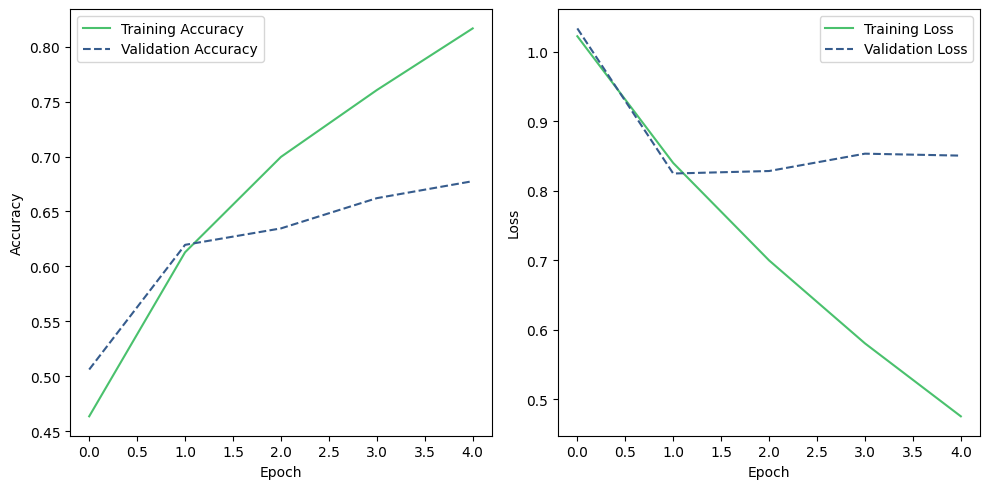

In [26]:
#Call the function to plot training history
training_history_gru_only = plot_training_history(history_oversampled_gruonly)

*Evaluate*

Using classification report and confusion matrix.

In [27]:
#Function to evaluate DL models
def evaluate_dl_model(model, X_test, y_test, target_names=['Negative', 'Neutral', 'Positive']):
    """
    Evaluate the trained model on the test data and generate classification report and confusion matrix.

    Parameters:
    model (keras.models.Sequential): Trained GRU model.
    X_test (numpy.ndarray): Test data features.
    y_test (numpy.ndarray): Test data labels.
    target_names (list): List of target class names.

    Returns:
    classification_report (str): Classification report as a string.
    fig (matplotlib.figure.Figure): Figure object containing the confusion matrix plot.
    """
    #Predict probabilities for the test data
    y_pred_prob = model.predict(X_test)

    #Get the predicted labels by finding the index of the class with the highest probability
    y_pred = np.argmax(y_pred_prob, axis=1)

    #Generate classification report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(class_report)

    #Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    #Plot confusion matrix
    fig = plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=target_names, yticklabels=target_names, cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()

    return fig

1078/1078 [==============================] - 80s 74ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.68      0.65     11527
           1       0.55      0.47      0.51     11388
           2       0.68      0.72      0.70     11571

    accuracy                           0.62     34486
   macro avg       0.62      0.62      0.62     34486
weighted avg       0.62      0.62      0.62     34486



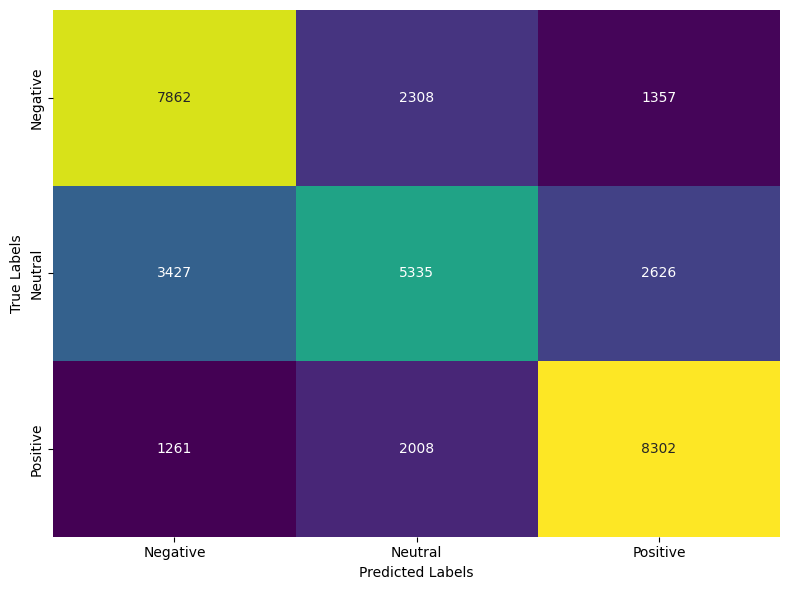

In [28]:
#Evaluate GRU model on entire dataset
oversampled_gruonly = evaluate_dl_model(gru_model_over_gruonly_all_instance, X_test_random_over, y_test_random_over)

This model is massively overfitting, this is why early stopping only allowed 5 epochs to run. Validation loss was increasing rather than decreasing. Training accuracy reached 0.8168 before stopping.

The architecture is lacking dense/dropout layers and maybe oversimplified compared to baseline. Going to add on dense/dropout layer and reintroduce flatten layer (in baseline architecture).

In [29]:
#One dense/dropout layer before classfiication layer plus flatten, dropout after embedding removed
def gru_model_over_onedense_flatten_all(units=128, dense_units=32, dropout=0.3, optimizer='adam',
              learning_rate=0.001, activation='relu',
              recurrent_dropout=0.2, regularization=None, 
              alpha=None, lambda_=None,
              dense_dropout=0.2):
    """
    Creates a one-layer GRU model with dropout for sentiment analysis for oversampled data. 1 dense/dropout layer.

    Parameters:
    units (int): Dimensionality of the output space (number of units in the GRU layer).
    dense_units (int): Dimensionality of the dense layer.
    dropout (float): Dropout rate for the input units.
    optimizer (str): Adam optimizer to use for training.
    learning_rate (float): Learning rate for the optimizer.
    activation (str): ReLU activation function.
    recurrent_dropout (float): Dropout rate for the recurrent units.
    regularization (str or None): Regularization technique to use. Supported values are 'l1', 'l2', or None.
    alpha (float or None): Regularization strength for L1 regularization.
    lambda_ (float or None): Regularization strength for L2 regularization.
    dense_dropout (float): Dropout rate for the dense layers.

    Returns:
    keras.models.Sequential: Compiled GRU model.
    """
    #Build layers
    model = Sequential()
    #Add random_oversampled_embedding_layer_all
    model.add(random_oversampled_embedding_layer_all)

    #Add GRU layer with regularization
    if regularization == 'l1':
        kernel_regularizer = regularizers.l1(alpha)
        recurrent_regularizer = regularizers.l1(alpha)
    elif regularization == 'l2':
        kernel_regularizer = regularizers.l2(lambda_)
        recurrent_regularizer = regularizers.l2(lambda_)
    else:
        kernel_regularizer = None
        recurrent_regularizer = None

    model.add(GRU(units=units, dropout=dropout,
                  recurrent_dropout=recurrent_dropout,
                  kernel_regularizer=kernel_regularizer,
                  recurrent_regularizer=recurrent_regularizer))
    
    #One dense and dropout layer
    model.add(Dense(units=dense_units, activation=activation))
    model.add(Dropout(dense_dropout))

    #Reintroduce flatten layer
    model.add(Flatten())
    
    #Add classification dense layer
    model.add(Dense(units=3, activation='softmax'))

    #Compile model
    #Not using one-hot encoding so need to use sparse_categorical_crossentropy to handle integer labels
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [30]:
#Create an instance of the GRU model for downsampled data with optimized parameters
gru_model_over_onedense_flatten_all_instance = gru_model_over_onedense_flatten_all()

#Fit the model to the entire oversampled training data with early stopping
history_oversampled_gru_model_over_onedense_flatten_all = gru_model_over_onedense_flatten_all_instance.fit(X_train_random_over, y_train_random_over, 
                                                                     epochs=30, batch_size=64, 
                                                                     verbose=2, validation_split=0.2,
                                                                     callbacks=[early_stopping])

Epoch 1/30
130/130 - 138s - loss: 0.9807 - accuracy: 0.4938 - val_loss: 0.9140 - val_accuracy: 0.5611 - 138s/epoch - 1s/step
Epoch 2/30
130/130 - 149s - loss: 0.7703 - accuracy: 0.6568 - val_loss: 0.8328 - val_accuracy: 0.6196 - 149s/epoch - 1s/step
Epoch 3/30
130/130 - 140s - loss: 0.6454 - accuracy: 0.7313 - val_loss: 0.8932 - val_accuracy: 0.6303 - 140s/epoch - 1s/step
Epoch 4/30
130/130 - 131s - loss: 0.5476 - accuracy: 0.7808 - val_loss: 0.8445 - val_accuracy: 0.6651 - 131s/epoch - 1s/step
Epoch 5/30
130/130 - 138s - loss: 0.4656 - accuracy: 0.8215 - val_loss: 0.8777 - val_accuracy: 0.6641 - 138s/epoch - 1s/step


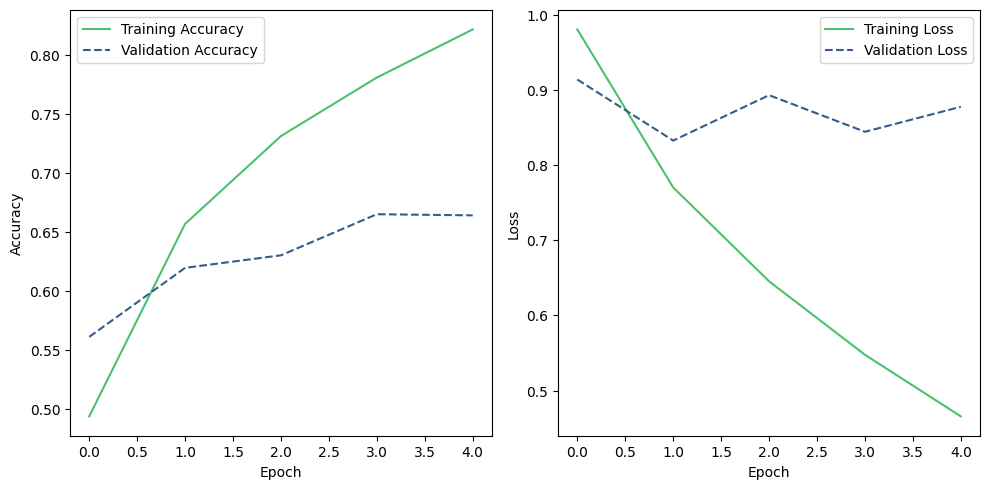

In [31]:
#Call the function to plot training history
training_history_onedense_flatten = plot_training_history(history_oversampled_gru_model_over_onedense_flatten_all)

1078/1078 [==============================] - 79s 73ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.70      0.66     11527
           1       0.57      0.43      0.49     11388
           2       0.67      0.75      0.70     11571

    accuracy                           0.63     34486
   macro avg       0.62      0.63      0.62     34486
weighted avg       0.62      0.63      0.62     34486



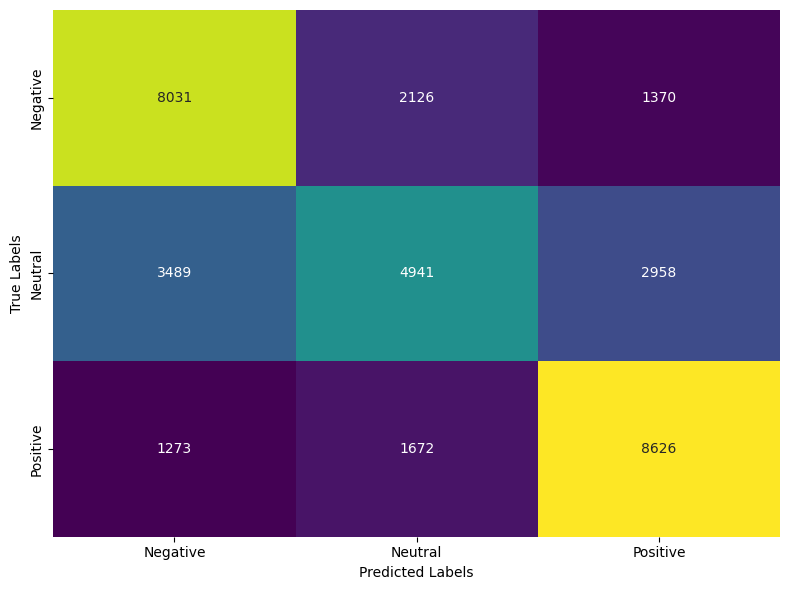

In [32]:
#Evaluate GRU model on entire dataset
oversampled_gru_onedense_flatten = evaluate_dl_model(gru_model_over_onedense_flatten_all_instance, X_test_random_over, y_test_random_over)

This model is also overfitting, this is why early stopping only allowed 5 epochs to run. Validation loss was increasing rather than decreasing. Training accuracy reached 0.8215 before stopping.

The architecture has one dense/dropout layers and flatten lyer prioir to classification layer but overfitting still occurring. Going to run original baseline architectur with optjmised hyperparameters in hope that overfitting is redued..

In [33]:
def gru_model_over_all(units=128, dropout=0.2, optimizer='adam',
              learning_rate=0.001, activation='relu',
              recurrent_dropout=0.1, regularization=None, 
              alpha=None, lambda_=None,
              dense_dropout=0.2, num_dense_layers=3):
    """
    Creates a one-layer GRU model with dropout for sentiment analysis for oversampled data.

    Parameters:
    units (int): Dimensionality of the output space (number of units in the GRU layer).
    dropout (float): Dropout rate for the input units.
    optimizer (str): Adam optimizer to use for training.
    learning_rate (float): Learning rate for the optimizer.
    activation (str): ReLU activation function.
    recurrent_dropout (float): Dropout rate for the recurrent units.
    regularization (str or None): Regularization technique to use. Supported values are 'l1', 'l2', or None.
    alpha (float or None): Regularization strength for L1 regularization.
    lambda_ (float or None): Regularization strength for L2 regularization.
    dense_dropout (float): Dropout rate for the dense layers.
    num_dense_layers (int): Number of dense layers to add between GRU and the classification dense layer.

    Returns:
    keras.models.Sequential: Compiled GRU model.
    """
    #Build layers
    model = Sequential()
    #Add random_oversampled_embedding_layer_all
    model.add(random_oversampled_embedding_layer_all)
    #Add dropout layer after embedding layer
    model.add(Dropout(dropout))
    
    #Add GRU layer with regularization
    if regularization == 'l1':
        kernel_regularizer = regularizers.l1(alpha)
        recurrent_regularizer = regularizers.l1(alpha)
    elif regularization == 'l2':
        kernel_regularizer = regularizers.l2(lambda_)
        recurrent_regularizer = regularizers.l2(lambda_)
    else:
        kernel_regularizer = None
        recurrent_regularizer = None

    model.add(GRU(units=units, dropout=dropout,
                  recurrent_dropout=recurrent_dropout,
                  kernel_regularizer=kernel_regularizer,
                  recurrent_regularizer=recurrent_regularizer))
    
    #Define units for dense layers
    dense_units = [64, 32, 16]

    #Three dense and dropout layers
    for i in range(num_dense_layers):
        model.add(Dense(units=dense_units[i], activation=activation))
        model.add(Dropout(dense_dropout))

    #Add Flatten layer converting to 1D array
    model.add(Flatten())

    #Add classification dense layer
    model.add(Dense(units=3, activation='softmax'))

    #Compile model
    #Not using one-hot encoding so need to use sparse_categorical_crossentropy to handle integer labels
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [34]:
#Create an instance of the GRU model for downsampled data with optimized parameters
gru_model_over_all_instance = gru_model_over_all()

#Fit the model to the entire oversampled training data with early stopping
history_oversampled_gru_model_over_all = gru_model_over_all_instance.fit(X_train_random_over, y_train_random_over, 
                                                                     epochs=30, batch_size=64, 
                                                                     verbose=2, validation_split=0.2,
                                                                     callbacks=[early_stopping])

Epoch 1/30
130/130 - 160s - loss: 1.0229 - accuracy: 0.4529 - val_loss: 0.9131 - val_accuracy: 0.5679 - 160s/epoch - 1s/step
Epoch 2/30
130/130 - 114s - loss: 0.8020 - accuracy: 0.6429 - val_loss: 0.8555 - val_accuracy: 0.6187 - 114s/epoch - 875ms/step
Epoch 3/30
130/130 - 74s - loss: 0.6711 - accuracy: 0.7257 - val_loss: 0.8187 - val_accuracy: 0.6486 - 74s/epoch - 570ms/step
Epoch 4/30
130/130 - 76s - loss: 0.6002 - accuracy: 0.7695 - val_loss: 0.8420 - val_accuracy: 0.6414 - 76s/epoch - 584ms/step
Epoch 5/30
130/130 - 72s - loss: 0.5405 - accuracy: 0.7989 - val_loss: 0.8651 - val_accuracy: 0.6651 - 72s/epoch - 553ms/step
Epoch 6/30
130/130 - 75s - loss: 0.4811 - accuracy: 0.8214 - val_loss: 0.9012 - val_accuracy: 0.6486 - 75s/epoch - 577ms/step


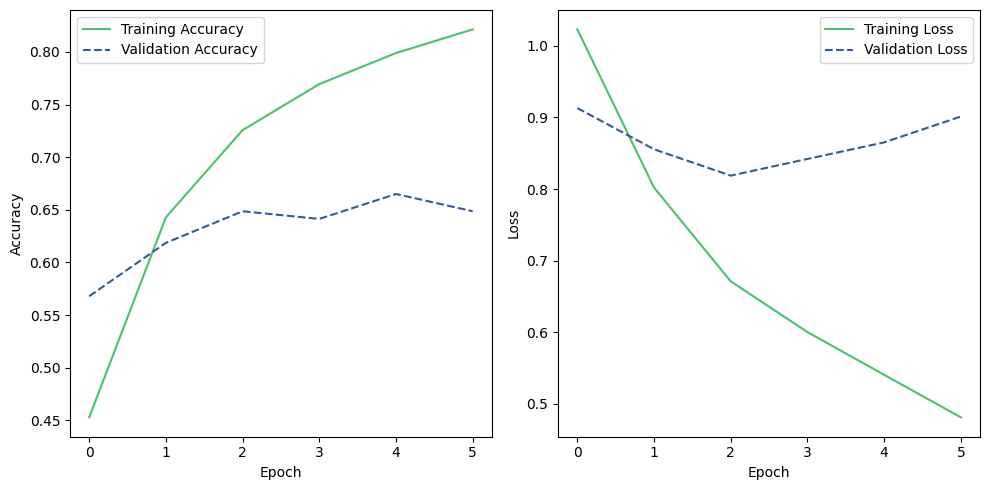

In [35]:
#Call the function to plot training history
training_history_gru_original = plot_training_history(history_oversampled_gru_model_over_all)

1078/1078 [==============================] - 29s 27ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.57      0.63     11527
           1       0.53      0.65      0.59     11388
           2       0.71      0.70      0.71     11571

    accuracy                           0.64     34486
   macro avg       0.65      0.64      0.64     34486
weighted avg       0.65      0.64      0.64     34486



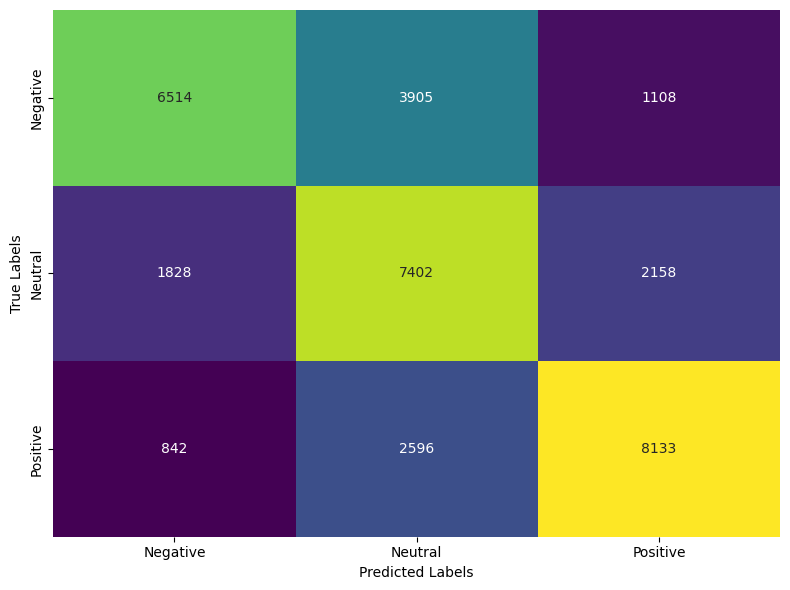

In [36]:
#Evaluate GRU model on entire dataset
oversampled_gru_original = evaluate_dl_model(gru_model_over_all_instance, X_test_random_over, y_test_random_over)

Model early stopped at 6 epochs due to overfitting, validation loss still inceasing using baseline architecture. Raining accuracy was 0.8214 at stopping.

Run for batch size 32 to see if reduces overfitting (model updates more frequently).

In [37]:
#Create an instance of the GRU model for data with optimized parameters
gru_model_over_all_instance_32batch = gru_model_over_all()

#Fit the model to the entire oversampled training data with early stopping and batch size 32
history_oversampled_gru_model_over_all_32batch = gru_model_over_all_instance_32batch.fit(X_train_random_over, y_train_random_over, 
                                                                     epochs=30, batch_size=32, 
                                                                     verbose=2, validation_split=0.2,
                                                                     callbacks=[early_stopping])

Epoch 1/30
259/259 - 73s - loss: 0.9292 - accuracy: 0.5214 - val_loss: 0.8458 - val_accuracy: 0.6114 - 73s/epoch - 281ms/step
Epoch 2/30
259/259 - 70s - loss: 0.6855 - accuracy: 0.7174 - val_loss: 0.8581 - val_accuracy: 0.6525 - 70s/epoch - 272ms/step
Epoch 3/30
259/259 - 70s - loss: 0.5826 - accuracy: 0.7754 - val_loss: 0.9606 - val_accuracy: 0.6283 - 70s/epoch - 270ms/step
Epoch 4/30
259/259 - 79s - loss: 0.4917 - accuracy: 0.8126 - val_loss: 0.9665 - val_accuracy: 0.6631 - 79s/epoch - 303ms/step


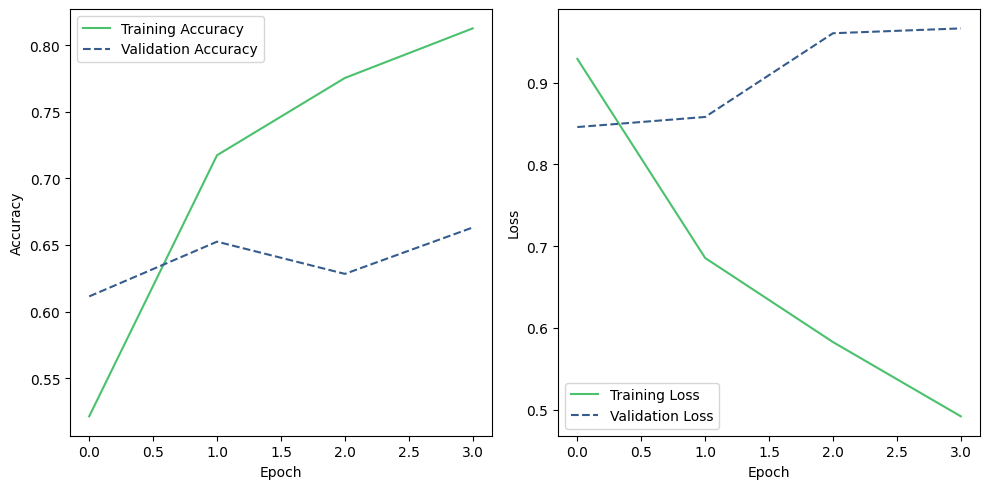

In [38]:
#Call the function to plot training history
training_history_gru_original_32batch = plot_training_history(history_oversampled_gru_model_over_all_32batch)

1078/1078 [==============================] - 76s 70ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.71      0.65     11527
           1       0.50      0.49      0.49     11388
           2       0.75      0.63      0.68     11571

    accuracy                           0.61     34486
   macro avg       0.62      0.61      0.61     34486
weighted avg       0.62      0.61      0.61     34486



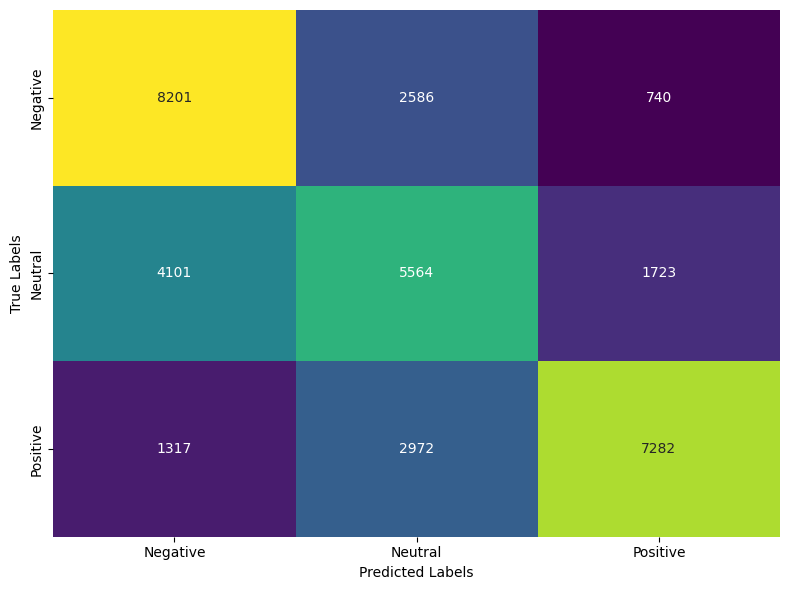

In [39]:
#Evaluate GRU model on entire dataset
oversampled_gru_original_32batch = evaluate_dl_model(gru_model_over_all_instance_32batch, X_test_random_over, y_test_random_over)

**GRU summary**
The baseline model and other models tested that achieved highest hyperparameter optmisation training accuracy are all overfitting. This is potentially due to the oversampled dataset size being considerably smaller than the Drugs.com dataset. The model may need considerably more data due to noise or task/model complexity, preventing effective learning.

Reducing batch size from 64 to 32 for baseline architecture also had no effect on overfitting. Model only ran 4 epochs before early stopping due to increasing validation loss as for previous attempts. The training accuracy was 0.8126.

There is no point increasing the model architecture complexity by increasing the number of GRU layers- the model will still overfit!

Will try optimising LSTM baseline architecture for the oversampled data next and see if model overfits to the same extent.

**LSTM model**

Will use original architecture (3 dense/dropout layers, flatten layer and dropout between embedding and LSTM layer) for direct comparison with GRU. Hoping that overfitting is not so significant with LSTM model, but likely.

In [142]:
#Hyperparameter optimisation for LSTM model (baseline architecture)
def lstm_model_over(units=64, dropout=0.5, optimizer='adam',
              learning_rate=0.001, activation='relu',
              recurrent_dropout=0.1, regularization=None, 
              alpha=None, lambda_=None,
              dense_dropout=0.5, num_dense_layers=3):
    """
    Creates a LSTM model with baseline architecture with dropout for sentiment analysis for oversampled data.

    Parameters:
    units (int): Dimensionality of the output space (number of units in the LSTM layer).
    dropout (float): Dropout rate for the input units.
    optimizer (str): Adam optimizer to use for training.
    learning_rate (float): Learning rate for the optimizer.
    activation (str): ReLU activation function.
    recurrent_dropout (float): Dropout rate for the recurrent units.
    regularization (str or None): Regularization technique to use. Supported values are 'l1', 'l2', or None.
    alpha (float or None): Regularization strength for L1 regularization.
    lambda_ (float or None): Regularization strength for L2 regularization.
    dense_dropout (float): Dropout rate for the dense layers.
    num_dense_layers (int): Number of dense layers to add between LSTM and the classification dense layer.

    Returns:
    keras.models.Sequential: Compiled LSTM model.
    """
    #Build layers
    model = Sequential()
    #Add random_oversampled_embedding_layer
    model.add(random_oversampled_embedding_layer)
    #Add dropout layer after embedding layer
    model.add(Dropout(dropout))
    
    #Add GRU layer with dynamic regularization
    if regularization == 'l1':
        kernel_regularizer = regularizers.l1(alpha)
        recurrent_regularizer = regularizers.l1(alpha)
    elif regularization == 'l2':
        kernel_regularizer = regularizers.l2(lambda_)
        recurrent_regularizer = regularizers.l2(lambda_)
    else:
        kernel_regularizer = None
        recurrent_regularizer = None

    model.add(LSTM(units=units, dropout=dropout,
                  recurrent_dropout=recurrent_dropout,
                  kernel_regularizer=kernel_regularizer,
                  recurrent_regularizer=recurrent_regularizer))
    
    #Define units for dense layers
    dense_units = [64, 32, 16]

    #Three dense and dropout layers
    for i in range(num_dense_layers):
        model.add(Dense(units=dense_units[i], activation=activation))
        model.add(Dropout(dense_dropout))

    #Add Flatten layer converting to 1D array
    model.add(Flatten())

    #Add classification dense layer
    model.add(Dense(units=3, activation='softmax'))

    #Compile model
    #Not using one-hot encoding so need to use sparse_categorical_crossentropy to handle integer labels
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

#Wrap the Keras model with KerasClassifier
model_wrapper_lstm = KerasClassifier(build_fn=lstm_model_over)

#Create RandomizedSearchCV objects for each dataset and embedding layer
#5-fold CV with 50 iterations
#Trad off with computational time and parameter space coverage
random_search_oversampled_lstm = RandomizedSearchCV(
    estimator=model_wrapper_lstm,
    param_distributions=param_dist,
    n_iter=50,  #Number of candidates sampled, very small proportion of feature space
    scoring='accuracy',
    cv=5, #5-fold cross-validation
    verbose=2,  #Displays a summary of each iteration, including the current parameter settings and the best score so far
    n_jobs=-1, #Use all available processors
    error_score='raise'
)

C:\Users\local_8739582\Temp\ipykernel_28736\3795525667.py:70: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_wrapper_lstm = KerasClassifier(build_fn=lstm_model_over)


In [143]:
#Fit the RandomizedSearchCV objects to the subset (10%) training data
random_search_oversampled_lstm.fit(X_train_random_over_subset, y_train_random_over_subset)

#Get the best parameters and best score for each RandomizedSearchCV object
print("Best parameters found for oversampled data:", random_search_oversampled_lstm.best_params_)
print("Best accuracy found for oversampled data:", random_search_oversampled_lstm.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
134/134 [==============================] - 37s 259ms/step - loss: 1.2343 - accuracy: 0.5294
Best parameters found for oversampled data: {'units': 128, 'regularization': 'l2', 'recurrent_dropout': 0.2, 'learning_rate': 0.001, 'lambda_': 0.001, 'dropout': 0.2, 'dense_dropout': 0.2, 'alpha': 0.01}
Best accuracy found for oversampled data: 0.6099504901907327


*Fit entire oversampled data to optimised LSTM*

#Create the embedding layer for the entire dataset with optimized parameters
random_oversampled_embedding_layer_all = Embedding(input_dim=vocab_size_top_five_diseases,
                                        output_dim=embedding_dim,
                                        embeddings_initializer=Constant(embedding_matrix_top_five_diseases),
                                        input_length=X_train_random_over.shape[1],  #Use the length of the entire dataset
                                        trainable=True)  #Set trainable=True if you want embeddings to update during training

In [40]:
#Function defining lstm model for all oversampled data using optimised hyperparameters
def lstm_model_over_all(units=128, dropout=0.2, optimizer='adam',
              learning_rate=0.001, activation='relu',
              recurrent_dropout=0.1, regularization='l2', 
              alpha=None, lambda_=0.001,
              dense_dropout=0.2, num_dense_layers=3):
    """
    Creates a LSTM model with baseline architecture with dropout for sentiment analysis for oversampled data.

    Parameters:
    units (int): Dimensionality of the output space (number of units in the LSTM layer).
    dropout (float): Dropout rate for the input units.
    optimizer (str): Adam optimizer to use for training.
    learning_rate (float): Learning rate for the optimizer.
    activation (str): ReLU activation function.
    recurrent_dropout (float): Dropout rate for the recurrent units.
    regularization (str or None): Regularization technique to use. Supported values are 'l1', 'l2', or None.
    alpha (float or None): Regularization strength for L1 regularization.
    lambda_ (float or None): Regularization strength for L2 regularization.
    dense_dropout (float): Dropout rate for the dense layers.
    num_dense_layers (int): Number of dense layers to add between LSTM and the classification dense layer.

    Returns:
    keras.models.Sequential: Compiled LSTM model.
    """
    #Build layers
    model = Sequential()
    #Add random_oversampled_embedding_layer_all
    model.add(random_oversampled_embedding_layer_all)
    #Add dropout layer after embedding layer
    model.add(Dropout(dropout))
    
    #Add GRU layer with dynamic regularization
    if regularization == 'l1':
        kernel_regularizer = regularizers.l1(alpha)
        recurrent_regularizer = regularizers.l1(alpha)
    elif regularization == 'l2':
        kernel_regularizer = regularizers.l2(lambda_)
        recurrent_regularizer = regularizers.l2(lambda_)
    else:
        kernel_regularizer = None
        recurrent_regularizer = None

    model.add(LSTM(units=units, dropout=dropout,
                  recurrent_dropout=recurrent_dropout,
                  kernel_regularizer=kernel_regularizer,
                  recurrent_regularizer=recurrent_regularizer))
    
    #Define units for dense layers
    dense_units = [64, 32, 16]

    #Three dense and dropout layers
    for i in range(num_dense_layers):
        model.add(Dense(units=dense_units[i], activation=activation))
        model.add(Dropout(dense_dropout))

    #Add Flatten layer converting to 1D array
    model.add(Flatten())

    #Add classification dense layer
    model.add(Dense(units=3, activation='softmax'))

    #Compile model
    #Not using one-hot encoding so need to use sparse_categorical_crossentropy to handle integer labels
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [41]:
#Create an instance of the LSTM model for oversampled data with optimised parameters
lstm_model_over_all_instance = lstm_model_over_all()

#Fit the model to the entire oversampled training data
#30 epochs, batch size 64
history_oversampled_lstm_original = lstm_model_over_all_instance.fit(X_train_random_over, y_train_random_over, 
                                                                     epochs=30, batch_size=64, 
                                                                     verbose=2, validation_split=0.2,
                                                                     callbacks=[early_stopping])

Epoch 1/30
130/130 - 156s - loss: 1.1612 - accuracy: 0.5536 - val_loss: 1.1255 - val_accuracy: 0.5442 - 156s/epoch - 1s/step
Epoch 2/30
130/130 - 164s - loss: 0.8167 - accuracy: 0.7204 - val_loss: 0.9418 - val_accuracy: 0.6433 - 164s/epoch - 1s/step
Epoch 3/30
130/130 - 170s - loss: 0.6971 - accuracy: 0.7715 - val_loss: 1.0135 - val_accuracy: 0.6375 - 170s/epoch - 1s/step
Epoch 4/30
130/130 - 168s - loss: 0.6211 - accuracy: 0.8050 - val_loss: 0.9993 - val_accuracy: 0.6646 - 168s/epoch - 1s/step
Epoch 5/30
130/130 - 170s - loss: 0.5696 - accuracy: 0.8247 - val_loss: 1.0165 - val_accuracy: 0.6626 - 170s/epoch - 1s/step


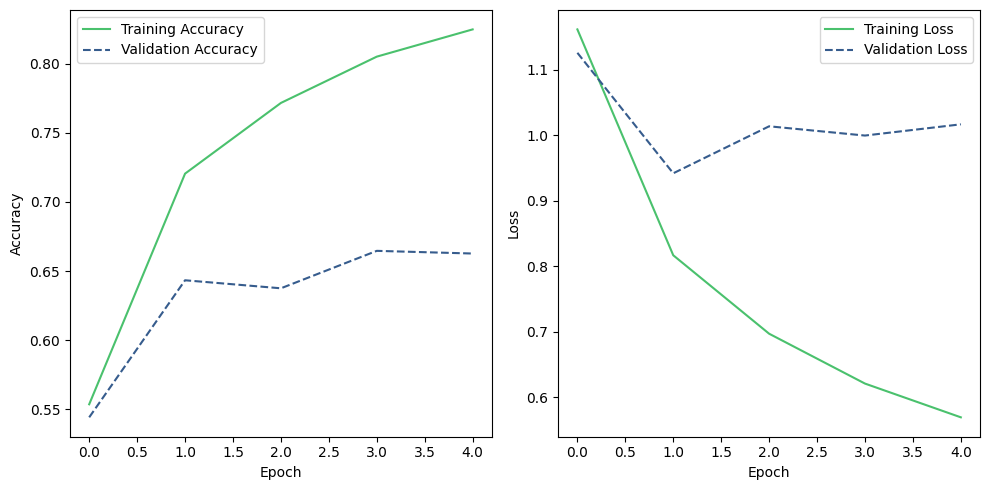

In [42]:
#Plot training history
training_history_lstm_original = plot_training_history(history_oversampled_lstm_original)

1078/1078 [==============================] - 131s 121ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.71      0.67     11527
           1       0.57      0.54      0.56     11388
           2       0.73      0.67      0.70     11571

    accuracy                           0.64     34486
   macro avg       0.64      0.64      0.64     34486
weighted avg       0.64      0.64      0.64     34486



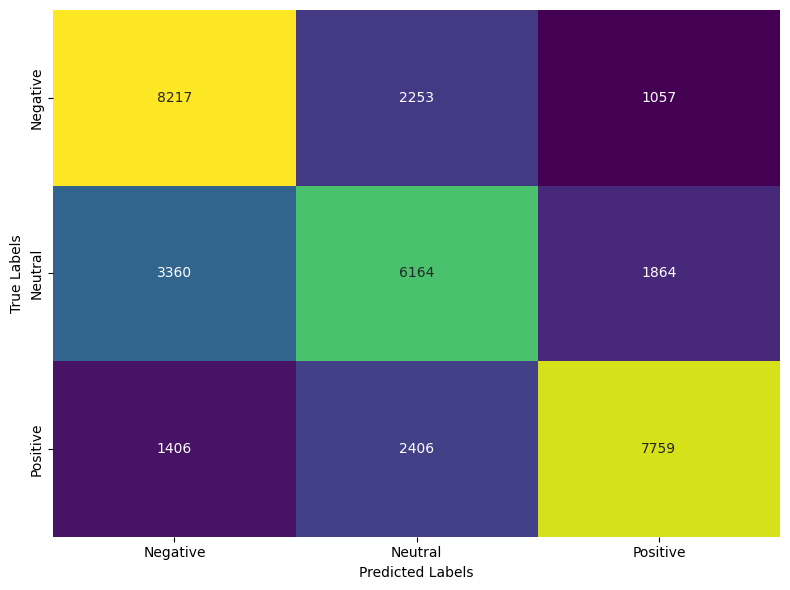

In [43]:
#Evaluate LSTM model on entire dataset
oversampled_lstm_original = evaluate_dl_model(lstm_model_over_all_instance, X_test_random_over, y_test_random_over)

**Summary of LSTM model**

LSTM model also overfits (based on baseline model architecture with hyperparameter optimisation). This is in all likelihood due to the dataset size.

In [44]:
#Create dict of remaining DL plots created in this notebook for use in report
figures_to_save_3 = {}

figures_to_save_3["./training_history_gru_only.png"] = training_history_gru_only
figures_to_save_3["./oversampled_gruonly_cm.png"] = oversampled_gruonly
figures_to_save_3["./training_history_onedense_flatten.png"] = training_history_onedense_flatten
figures_to_save_3["./oversampled_gru_onedense_flatten_cm.png"] = oversampled_gru_onedense_flatten
figures_to_save_3["./training_history_gru_original.png"] = training_history_gru_original
figures_to_save_3["./oversampled_gru_original.png"] = oversampled_gru_original
figures_to_save_3["./training_history_gru_original_32batch.png"] = training_history_gru_original_32batch
figures_to_save_3["./oversampled_gru_original_32batch.png"] = oversampled_gru_original_32batch
figures_to_save_3["./training_history_lstm_original.png"] = training_history_lstm_original
figures_to_save_3["./oversampled_lstm_original.png"] = oversampled_lstm_original

figures_to_save_3

{'./training_history_gru_only.png': <Figure size 1000x500 with 2 Axes>,
 './oversampled_gruonly_cm.png': <Figure size 800x600 with 1 Axes>,
 './training_history_onedense_flatten.png': <Figure size 1000x500 with 2 Axes>,
 './oversampled_gru_onedense_flatten_cm.png': <Figure size 800x600 with 1 Axes>,
 './training_history_gru_original.png': <Figure size 1000x500 with 2 Axes>,
 './oversampled_gru_original.png': <Figure size 800x600 with 1 Axes>,
 './training_history_gru_original_32batch.png': <Figure size 1000x500 with 2 Axes>,
 './oversampled_gru_original_32batch.png': <Figure size 800x600 with 1 Axes>,
 './training_history_lstm_original.png': <Figure size 1000x500 with 2 Axes>,
 './oversampled_lstm_original.png': <Figure size 800x600 with 1 Axes>}

In [47]:
save_figures(figures_to_save_3)

**Running BiLSTM on oversampled dataset**

Due to evidence of overfitting on oversampled dataset which is a smaller dataset than the Drugs.com dataset, as a validation exercise I am going to run a BiLSTM model using baseline architecture, optimising for hyperparameters.

BiLSTM can be beneficial for mitigating overfitting, especially when dealing with relatively small datasets. Bidirectional models process the input sequences in both forward and backward directions, capturing dependencies from past and future contexts simultaneously. This can help improve the model's ability to learn meaningful representations from the data and potentially reduce overfitting.

In [50]:
#from tensorflow.keras.layers import Bidirectional
#Function for one BiLSTM layer model for optmisation and runnong in oversampeld dataset
def bilstm_model(units=64, dropout=0.5, optimizer='adam',
                 learning_rate=0.001, activation='relu',
                 recurrent_dropout=0.1, regularization=None, 
                 alpha=None, lambda_=None,
                 dense_dropout=0.5, num_dense_layers=3):
    """
    Creates a Bidirectional LSTM model with dropout for sentiment analysis for oversampled dataset.

    Parameters:
    units (int): Dimensionality of the output space (number of units in the LSTM layer).
    dropout (float): Dropout rate for the input units.
    optimizer (str): Adam optimizer to use for training.
    learning_rate (float): Learning rate for the optimizer.
    activation (str): ReLU activation function.
    recurrent_dropout (float): Dropout rate for the recurrent units.
    regularization (str or None): Regularization technique to use. Supported values are 'l1', 'l2', or None.
    alpha (float or None): Regularization strength for L1 regularization.
    lambda_ (float or None): Regularization strength for L2 regularization.
    dense_dropout (float): Dropout rate for the dense layers.
    num_dense_layers (int): Number of dense layers to add between LSTM and the classification dense layer.

    Returns:
    keras.models.Sequential: Compiled Bidirectional LSTM model.
    """
    #Build layers
    model = Sequential()
    #Add random_oversampled_embedding_layer
    model.add(random_oversampled_embedding_layer)
    #Add dropout layer after embedding layer
    model.add(Dropout(dropout))
    
    #Add Bidirectional LSTM layer with dynamic regularization
    if regularization == 'l1':
        kernel_regularizer = regularizers.l1(alpha)
        recurrent_regularizer = regularizers.l1(alpha)
    elif regularization == 'l2':
        kernel_regularizer = regularizers.l2(lambda_)
        recurrent_regularizer = regularizers.l2(lambda_)
    else:
        kernel_regularizer = None
        recurrent_regularizer = None

    #Create bidirectional LSTM layer (wrap LSTM layer)
    model.add(Bidirectional(LSTM(units=units, dropout=dropout,
                                  recurrent_dropout=recurrent_dropout,
                                  kernel_regularizer=kernel_regularizer,
                                  recurrent_regularizer=recurrent_regularizer)))
    
    #Define units for dense layers
    dense_units = [64, 32, 16]

    #Three dense and dropout layers
    for i in range(num_dense_layers):
        model.add(Dense(units=dense_units[i], activation=activation))
        model.add(Dropout(dense_dropout))

    #Add Flatten layer converting to 1D array
    model.add(Flatten())

    #Add classification dense layer
    model.add(Dense(units=3, activation='softmax'))

    #Compile model
    #Not using one-hot encoding so need to use sparse_categorical_crossentropy to handle integer labels
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

#Wrap the Keras model with KerasClassifier
model_wrapper_bilstm = KerasClassifier(build_fn=bilstm_model)

#Create RandomizedSearchCV objects
#5-fold CV with 50 iterations
#Trade off with computational time and parameter space coverage
random_search_oversampled_bilstm = RandomizedSearchCV(
    estimator=model_wrapper_bilstm,
    param_distributions=param_dist,
    n_iter=50,  #Number of candidates sampled, very small proportion of feature space
    scoring='accuracy',
    cv=5, #5-fold cross-validation
    verbose=2,  #Displays a summary of each iteration, including the current parameter settings and the best score so far
    n_jobs=-1, #Use all available processors
    error_score='raise'
)

C:\Users\local_8739581\Temp\ipykernel_51068\2136212891.py:71: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_wrapper_bilstm = KerasClassifier(build_fn=bilstm_model)


In [51]:
#Fit the RandomizedSearchCV objects to the subset (10%) training data
random_search_oversampled_bilstm.fit(X_train_random_over_subset, y_train_random_over_subset)

#Get the best parameters and best score for each RandomizedSearchCV object
print("Best parameters found for oversampled data:", random_search_oversampled_bilstm.best_params_)
print("Best accuracy found for oversampled data:", random_search_oversampled_bilstm.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
324/324 [==============================] - 354s 1s/step - loss: 1.0471 - accuracy: 0.4367
Best parameters found for oversampled data: {'units': 128, 'regularization': None, 'recurrent_dropout': 0.3, 'learning_rate': 0.01, 'lambda_': 0.1, 'dropout': 0.3, 'dense_dropout': 0.2, 'alpha': 0.001}
Best accuracy found for oversampled data: 0.5136781053649105
Best parameters found for oversampled data: {'units': 128, 'regularization': None, 'recurrent_dropout': 0.3, 'learning_rate': 0.01, 'lambda_': 0.1, 'dropout': 0.3, 'dense_dropout': 0.2, 'alpha': 0.001}
Best accuracy found for oversampled data: 0.5136781053649105
Best parameters found for oversampled data: {'units': 128, 'regularization': None, 'recurrent_dropout': 0.3, 'learning_rate': 0.01, 'lambda_': 0.1, 'dropout': 0.3, 'dense_dropout': 0.2, 'alpha': 0.001}
Best accuracy found for oversampled data: 0.5136781053649105


*Run BiLSTM model on entire oversampled dataset*

Using optimised hyperparameters above.

Initial architecture is the same as that presented in Haque 2024 baseline model paper.

Haque, R., Laskar, S. H., Khushbu, K. G., Hasan, M. J. & Uddin, J. (2023) Data-driven solution to identify sentiments from online drug reviews. Computers, 12(4), 87

In [52]:
#Function ti run on all oversampled data
def bilstm_model_all(units=128, dropout=0.3, optimizer='adam',
                 learning_rate=0.001, activation='relu',
                 recurrent_dropout=0.3, regularization=None, 
                 alpha=None, lambda_=None,
                 dense_dropout=0.2, num_dense_layers=3):
    """
    Creates a Bidirectional LSTM model with dropout for sentiment analysis for oversampled dataset.

    Parameters:
    units (int): Dimensionality of the output space (number of units in the LSTM layer).
    dropout (float): Dropout rate for the input units.
    optimizer (str): Adam optimizer to use for training.
    learning_rate (float): Learning rate for the optimizer.
    activation (str): ReLU activation function.
    recurrent_dropout (float): Dropout rate for the recurrent units.
    regularization (str or None): Regularization technique to use. Supported values are 'l1', 'l2', or None.
    alpha (float or None): Regularization strength for L1 regularization.
    lambda_ (float or None): Regularization strength for L2 regularization.
    dense_dropout (float): Dropout rate for the dense layers.
    num_dense_layers (int): Number of dense layers to add between LSTM and the classification dense layer.

    Returns:
    keras.models.Sequential: Compiled Bidirectional LSTM model.
    """
    #Build layers
    model = Sequential()
    #Add random_oversampled_embedding_layer_all
    model.add(random_oversampled_embedding_layer_all)
    #Add dropout layer after embedding layer
    model.add(Dropout(dropout))
    
    #Add Bidirectional LSTM layer with dynamic regularization
    if regularization == 'l1':
        kernel_regularizer = regularizers.l1(alpha)
        recurrent_regularizer = regularizers.l1(alpha)
    elif regularization == 'l2':
        kernel_regularizer = regularizers.l2(lambda_)
        recurrent_regularizer = regularizers.l2(lambda_)
    else:
        kernel_regularizer = None
        recurrent_regularizer = None

    #Create bidirectional LSTM layer (wrap LSTM layer)
    model.add(Bidirectional(LSTM(units=units, dropout=dropout,
                                  recurrent_dropout=recurrent_dropout,
                                  kernel_regularizer=kernel_regularizer,
                                  recurrent_regularizer=recurrent_regularizer)))
    
    #Define units for dense layers
    dense_units = [64, 32, 16]

    #Three dense and dropout layers
    for i in range(num_dense_layers):
        model.add(Dense(units=dense_units[i], activation=activation))
        model.add(Dropout(dense_dropout))

    #Add Flatten layer converting to 1D array
    model.add(Flatten())

    #Add classification dense layer
    model.add(Dense(units=3, activation='softmax'))

    #Compile model
    #Not using one-hot encoding so need to use sparse_categorical_crossentropy to handle integer labels
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [53]:
#Create an instance of the BiLSTM model for oversampled data with optimised parameters
bilstm_model_all_instance = bilstm_model_all()

#Fit the model to the entire oversampled training data
#30 epochs, batch size 32
history_oversampled_bilstm = bilstm_model_all_instance.fit(X_train_random_over, y_train_random_over, 
                                                                     epochs=30, batch_size=32, 
                                                                     verbose=2, validation_split=0.2,
                                                                     callbacks=[early_stopping])

Epoch 1/30
Epoch 1/30
Epoch 1/30
259/259 - 294s - loss: 0.9023 - accuracy: 0.5709 - val_loss: 0.8881 - val_accuracy: 0.6346 - 294s/epoch - 1s/step
259/259 - 294s - loss: 0.9023 - accuracy: 0.5709 - val_loss: 0.8881 - val_accuracy: 0.6346 - 294s/epoch - 1s/step
259/259 - 294s - loss: 0.9023 - accuracy: 0.5709 - val_loss: 0.8881 - val_accuracy: 0.6346 - 294s/epoch - 1s/step
Epoch 2/30
Epoch 2/30
Epoch 2/30
259/259 - 290s - loss: 0.6661 - accuracy: 0.7435 - val_loss: 0.9444 - val_accuracy: 0.6448 - 290s/epoch - 1s/step
259/259 - 290s - loss: 0.6661 - accuracy: 0.7435 - val_loss: 0.9444 - val_accuracy: 0.6448 - 290s/epoch - 1s/step
259/259 - 290s - loss: 0.6661 - accuracy: 0.7435 - val_loss: 0.9444 - val_accuracy: 0.6448 - 290s/epoch - 1s/step
Epoch 3/30
Epoch 3/30
Epoch 3/30
259/259 - 288s - loss: 0.5635 - accuracy: 0.7840 - val_loss: 0.9771 - val_accuracy: 0.6510 - 288s/epoch - 1s/step
259/259 - 288s - loss: 0.5635 - accuracy: 0.7840 - val_loss: 0.9771 - val_accuracy: 0.6510 - 288s/epoch

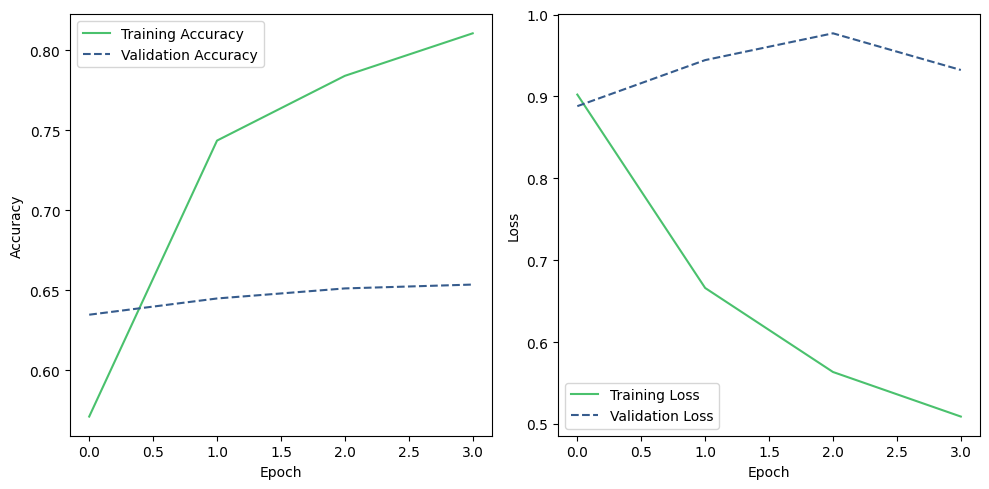

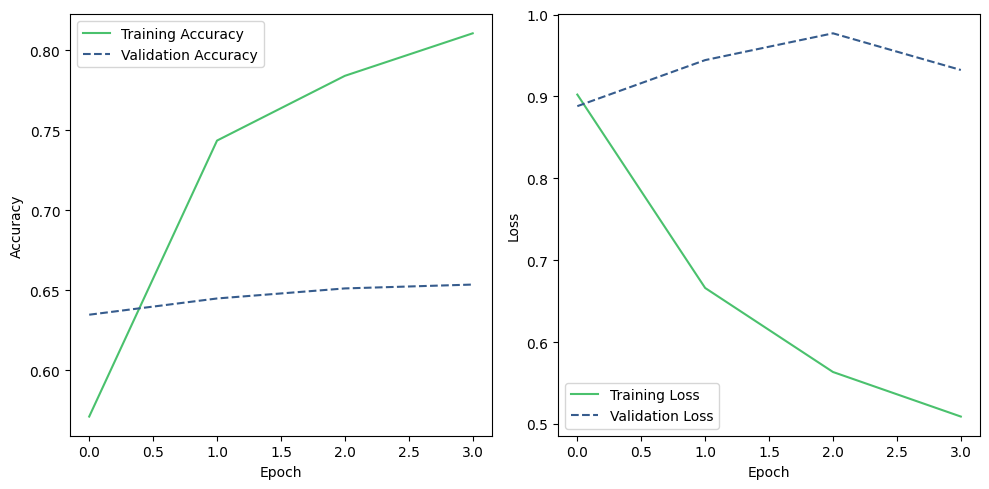

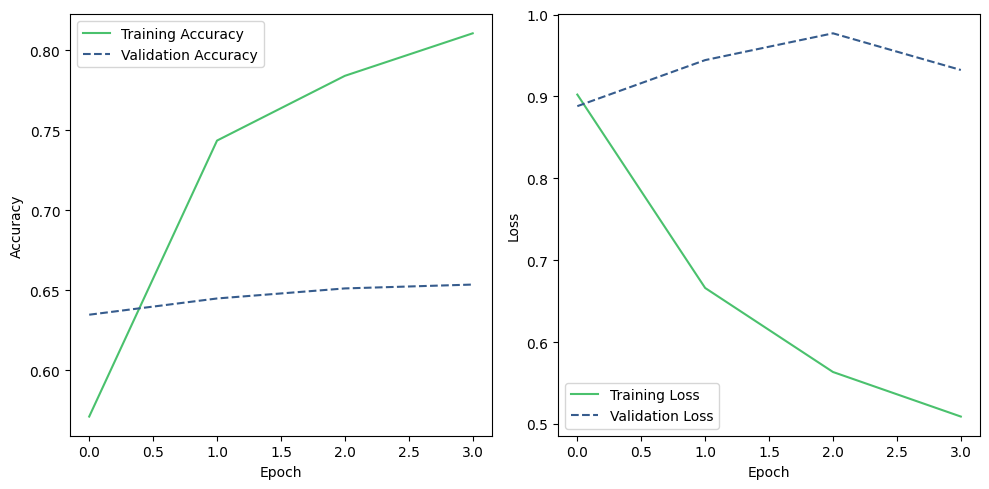

In [54]:
#Plot training history
training_history_bilstm = plot_training_history(history_oversampled_bilstm)

1078/1078 [==============================] - 277s 256ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.59      0.63     11527
           1       0.57      0.48      0.52     11388
           2       0.60      0.79      0.68     11571

    accuracy                           0.62     34486
   macro avg       0.62      0.62      0.61     34486
weighted avg       0.62      0.62      0.61     34486

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.59      0.63     11527
           1       0.57      0.48      0.52     11388
           2       0.60      0.79      0.68     11571

    accuracy                           0.62     34486
   macro avg       0.62      0.62      0.61     34486
weighted avg       0.62      0.62      0.61     34486



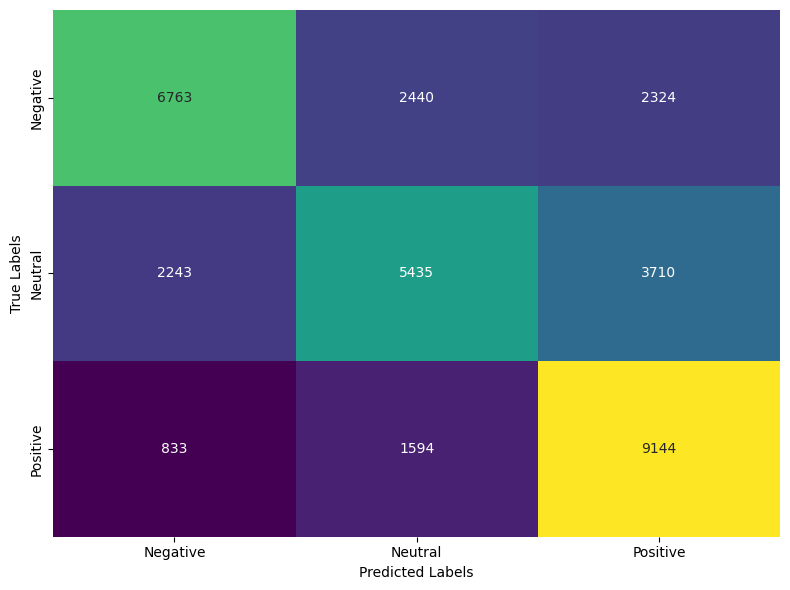

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.59      0.63     11527
           1       0.57      0.48      0.52     11388
           2       0.60      0.79      0.68     11571

    accuracy                           0.62     34486
   macro avg       0.62      0.62      0.61     34486
weighted avg       0.62      0.62      0.61     34486



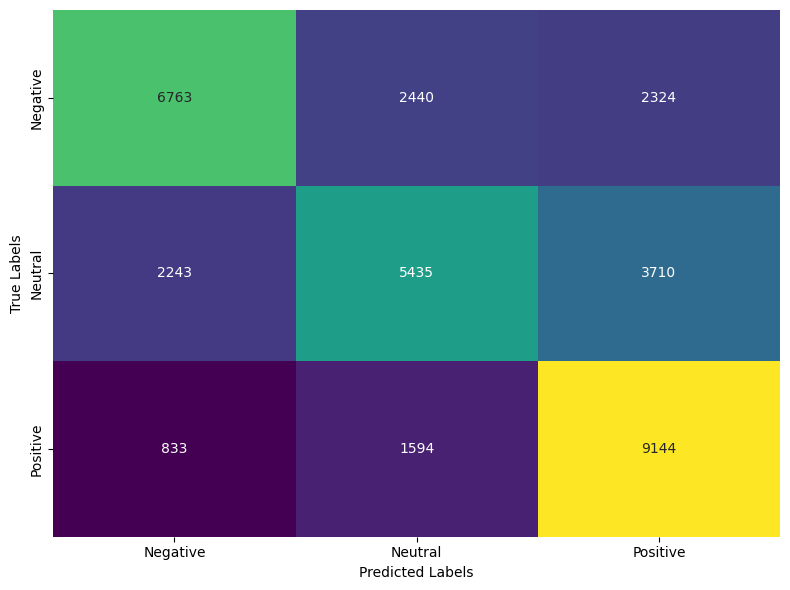

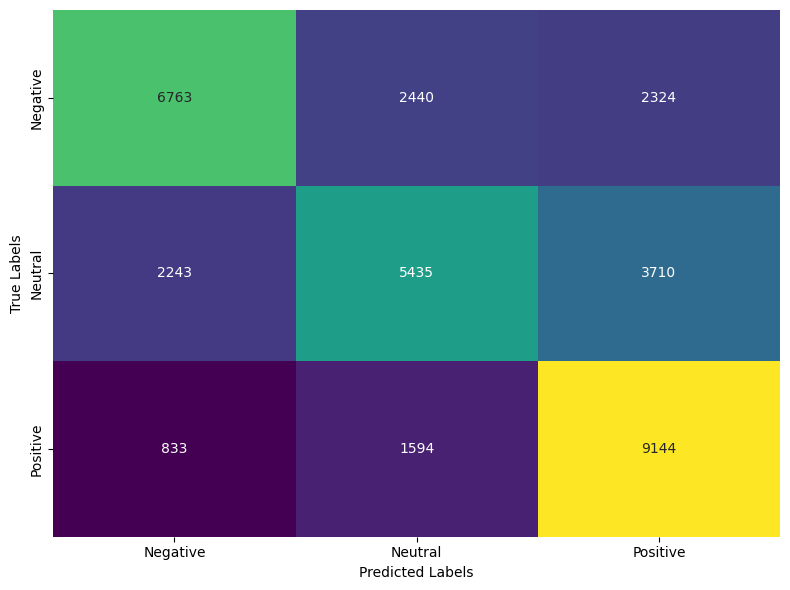

In [55]:
#Evaluate LSTM model on entire dataset
oversampled_bilstm = evaluate_dl_model(bilstm_model_all_instance, X_test_random_over, y_test_random_over)

BiLSTM baseline model with thhree dense layers is overfitting, so can try reducing complexity of the model to one dense layer  to see if this improves.

In [63]:
def bilstm_model_all_onedense(units=128, dropout=0.3, optimizer='adam',
                 learning_rate=0.001, activation='relu',
                 recurrent_dropout=0.3, regularization=None, 
                 alpha=None, lambda_=None,
                 dense_dropout=0.2):
    """
    Creates a Bidirectional LSTM model with dropout and one dense layer for sentiment analysis for oversampled dataset.

    Parameters:
    units (int): Dimensionality of the output space (number of units in the LSTM layer).
    dropout (float): Dropout rate for the input units.
    optimizer (str): Adam optimizer to use for training.
    learning_rate (float): Learning rate for the optimizer.
    activation (str): ReLU activation function.
    recurrent_dropout (float): Dropout rate for the recurrent units.
    regularization (str or None): Regularization technique to use. Supported values are 'l1', 'l2', or None.
    alpha (float or None): Regularization strength for L1 regularization.
    lambda_ (float or None): Regularization strength for L2 regularization.
    dense_dropout (float): Dropout rate for the dense layers.
    
    Returns:
    keras.models.Sequential: Compiled Bidirectional LSTM model.
    """
    #Build layers
    model = Sequential()
    #Add random_oversampled_embedding_layer_all
    model.add(random_oversampled_embedding_layer_all)
    #Add dropout layer after embedding layer
    model.add(Dropout(dropout))
    
    #Add Bidirectional LSTM layer with dynamic regularization
    if regularization == 'l1':
        kernel_regularizer = regularizers.l1(alpha)
        recurrent_regularizer = regularizers.l1(alpha)
    elif regularization == 'l2':
        kernel_regularizer = regularizers.l2(lambda_)
        recurrent_regularizer = regularizers.l2(lambda_)
    else:
        kernel_regularizer = None
        recurrent_regularizer = None

    #Create bidirectional LSTM layer (wrap LSTM layer)
    model.add(Bidirectional(LSTM(units=units, dropout=dropout,
                                  recurrent_dropout=recurrent_dropout,
                                  kernel_regularizer=kernel_regularizer,
                                  recurrent_regularizer=recurrent_regularizer)))

    #One dense and dropout layer
    model.add(Dense(units=32, activation=activation))
    model.add(Dropout(dense_dropout))

    #Add Flatten layer converting to 1D array
    model.add(Flatten())

    #Add classification dense layer
    model.add(Dense(units=3, activation='softmax'))

    #Compile model
    #Not using one-hot encoding so need to use sparse_categorical_crossentropy to handle integer labels
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [64]:
#Create an instance of the BiLSTM model for oversampled data with optimised parameters
bilstm_model_all_onedenselayer_instance = bilstm_model_all_onedense()

#Fit the model to the entire oversampled training data
#30 epochs, batch size 32
history_oversampled_bilstm_onedenselayer = bilstm_model_all_onedenselayer_instance.fit(X_train_random_over, y_train_random_over, 
                                                                     epochs=30, batch_size=32, 
                                                                     verbose=2, validation_split=0.2,
                                                                     callbacks=[early_stopping])

Epoch 1/30
Epoch 1/30
Epoch 1/30
259/259 - 306s - loss: 0.7395 - accuracy: 0.6754 - val_loss: 0.9932 - val_accuracy: 0.6085 - 306s/epoch - 1s/step
259/259 - 306s - loss: 0.7395 - accuracy: 0.6754 - val_loss: 0.9932 - val_accuracy: 0.6085 - 306s/epoch - 1s/step
259/259 - 306s - loss: 0.7395 - accuracy: 0.6754 - val_loss: 0.9932 - val_accuracy: 0.6085 - 306s/epoch - 1s/step
Epoch 2/30
Epoch 2/30
Epoch 2/30
259/259 - 310s - loss: 0.5648 - accuracy: 0.7759 - val_loss: 0.9904 - val_accuracy: 0.6462 - 310s/epoch - 1s/step
259/259 - 310s - loss: 0.5648 - accuracy: 0.7759 - val_loss: 0.9904 - val_accuracy: 0.6462 - 310s/epoch - 1s/step
259/259 - 310s - loss: 0.5648 - accuracy: 0.7759 - val_loss: 0.9904 - val_accuracy: 0.6462 - 310s/epoch - 1s/step
Epoch 3/30
Epoch 3/30
Epoch 3/30
259/259 - 372s - loss: 0.4853 - accuracy: 0.8120 - val_loss: 0.9582 - val_accuracy: 0.6689 - 372s/epoch - 1s/step
259/259 - 372s - loss: 0.4853 - accuracy: 0.8120 - val_loss: 0.9582 - val_accuracy: 0.6689 - 372s/epoch

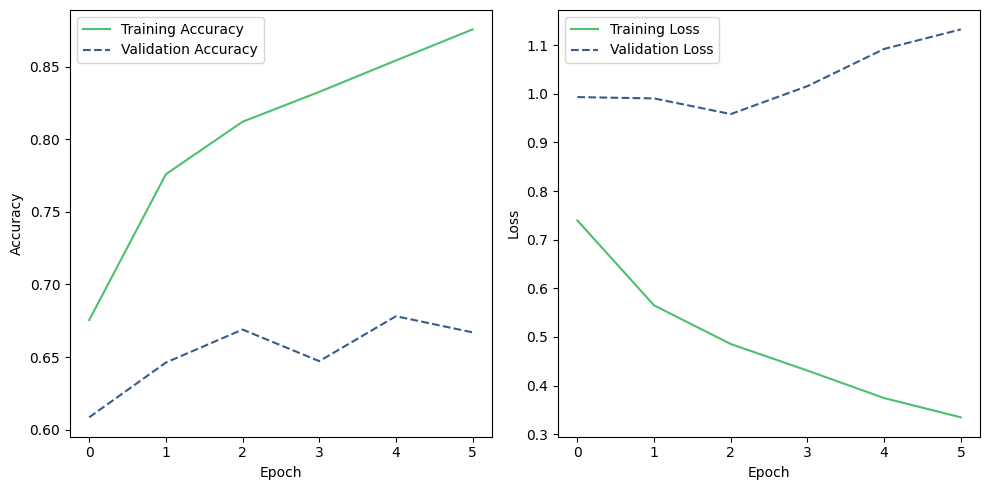

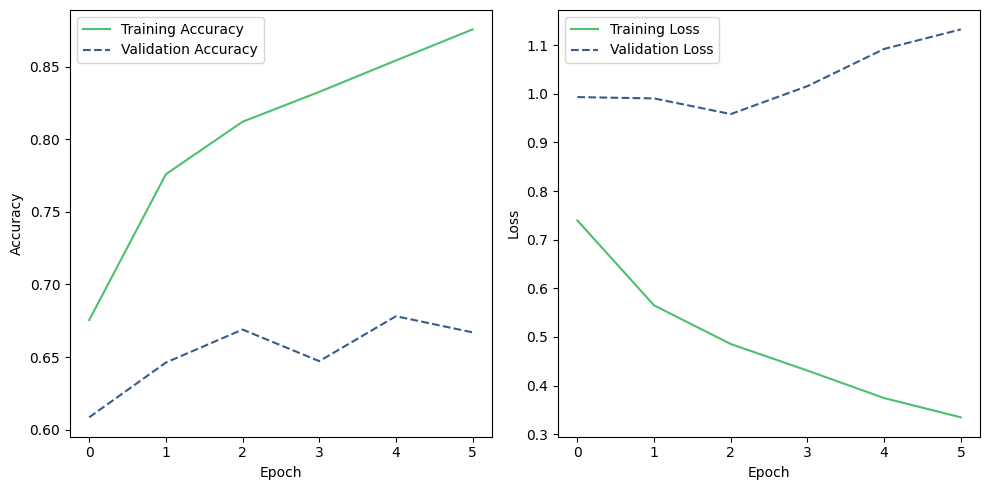

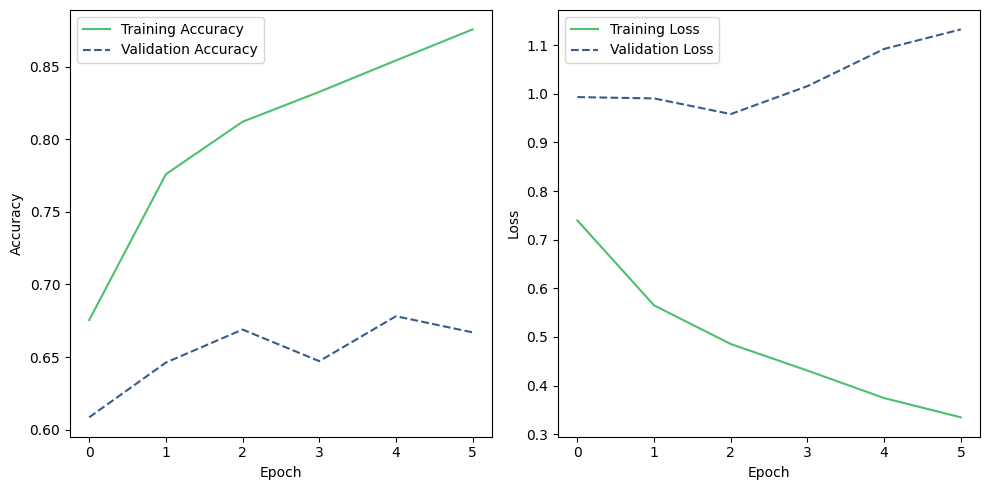

In [65]:
#Plot training history
training_history_bilstm_onedenselayer = plot_training_history(history_oversampled_bilstm_onedenselayer)

1078/1078 [==============================] - 353s 327ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67     11527
           1       0.58      0.66      0.62     11388
           2       0.73      0.70      0.71     11571

    accuracy                           0.66     34486
   macro avg       0.67      0.66      0.67     34486
weighted avg       0.67      0.66      0.67     34486

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67     11527
           1       0.58      0.66      0.62     11388
           2       0.73      0.70      0.71     11571

    accuracy                           0.66     34486
   macro avg       0.67      0.66      0.67     34486
weighted avg       0.67      0.66      0.67     34486



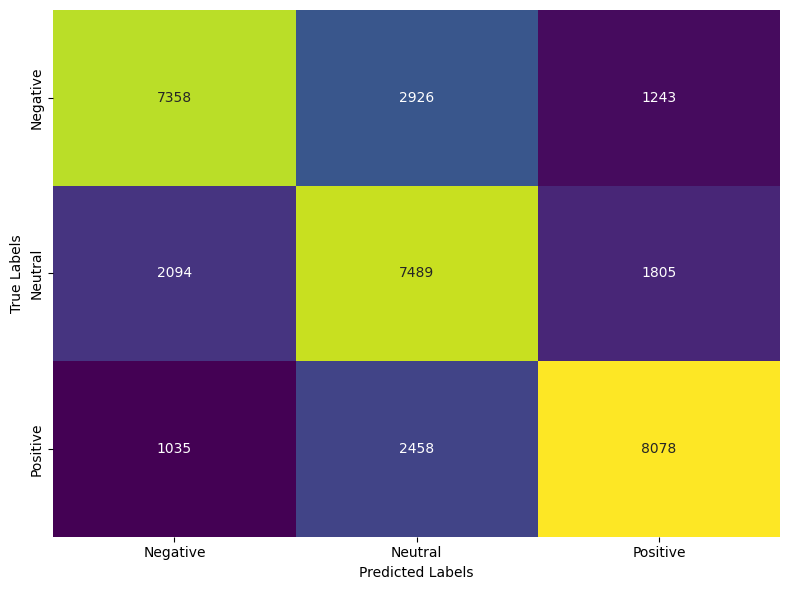

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67     11527
           1       0.58      0.66      0.62     11388
           2       0.73      0.70      0.71     11571

    accuracy                           0.66     34486
   macro avg       0.67      0.66      0.67     34486
weighted avg       0.67      0.66      0.67     34486



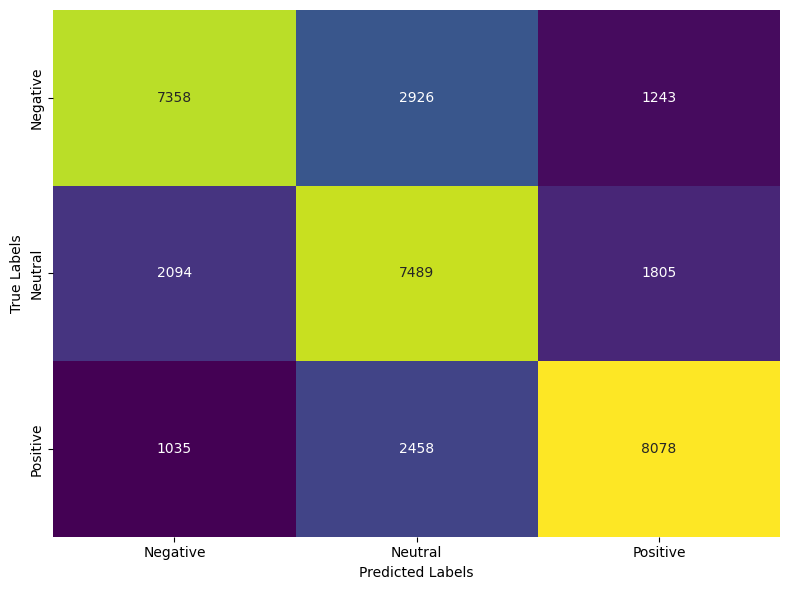

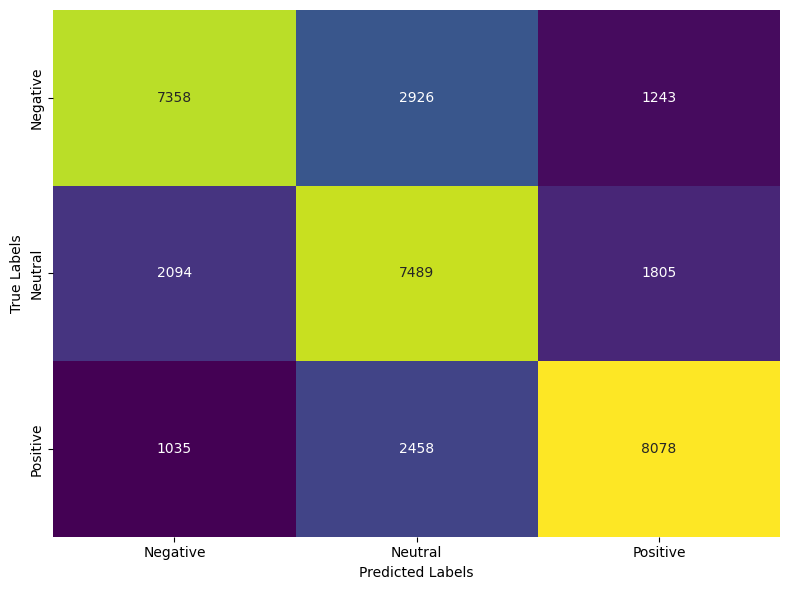

In [66]:
#Evaluate LSTM model on entire dataset
oversampled_bilstm_onedenselayer = evaluate_dl_model(bilstm_model_all_onedenselayer_instance, X_test_random_over, y_test_random_over)

BiLSTM model with only one dense layer is still overfitting, so can try reducing complexity of the model further to see if this improves.

In [67]:
def bilstm_model_all_nodense(units=128, dropout=0.3, optimizer='adam',
                 learning_rate=0.001, activation='relu',
                 recurrent_dropout=0.3, regularization=None, 
                 alpha=None, lambda_=None):
    """
    Creates a Bidirectional LSTM model with no dense layers for sentiment analysis for oversampled dataset.

    Parameters:
    units (int): Dimensionality of the output space (number of units in the LSTM layer).
    dropout (float): Dropout rate for the input units.
    optimizer (str): Adam optimizer to use for training.
    learning_rate (float): Learning rate for the optimizer.
    activation (str): ReLU activation function.
    recurrent_dropout (float): Dropout rate for the recurrent units.
    regularization (str or None): Regularization technique to use. Supported values are 'l1', 'l2', or None.
    alpha (float or None): Regularization strength for L1 regularization.
    lambda_ (float or None): Regularization strength for L2 regularization.
    
    Returns:
    keras.models.Sequential: Compiled Bidirectional LSTM model.
    """
    #Build layers
    model = Sequential()
    #Add random_oversampled_embedding_layer_all
    model.add(random_oversampled_embedding_layer_all)
    
    #Add Bidirectional LSTM layer with dynamic regularization
    if regularization == 'l1':
        kernel_regularizer = regularizers.l1(alpha)
        recurrent_regularizer = regularizers.l1(alpha)
    elif regularization == 'l2':
        kernel_regularizer = regularizers.l2(lambda_)
        recurrent_regularizer = regularizers.l2(lambda_)
    else:
        kernel_regularizer = None
        recurrent_regularizer = None

    #Create bidirectional LSTM layer (wrap LSTM layer)
    model.add(Bidirectional(LSTM(units=units, dropout=dropout,
                                  recurrent_dropout=recurrent_dropout,
                                  kernel_regularizer=kernel_regularizer,
                                  recurrent_regularizer=recurrent_regularizer)))

    #Add classification dense layer
    model.add(Dense(units=3, activation='softmax'))

    #Compile model
    #Not using one-hot encoding so need to use sparse_categorical_crossentropy to handle integer labels
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [68]:
#Create an instance of the BiLSTM model for oversampled data with optimised parameters
bilstm_model_all_nodense_instance = bilstm_model_all_nodense()

#Fit the model to the entire oversampled training data
#30 epochs, batch size 32
history_oversampled_bilstm_nodense = bilstm_model_all_nodense_instance.fit(X_train_random_over, y_train_random_over, 
                                                                     epochs=30, batch_size=32, 
                                                                     verbose=2, validation_split=0.2,
                                                                     callbacks=[early_stopping])

Epoch 1/30
Epoch 1/30
Epoch 1/30
259/259 - 350s - loss: 0.5955 - accuracy: 0.7558 - val_loss: 0.8600 - val_accuracy: 0.6593 - 350s/epoch - 1s/step
259/259 - 350s - loss: 0.5955 - accuracy: 0.7558 - val_loss: 0.8600 - val_accuracy: 0.6593 - 350s/epoch - 1s/step
259/259 - 350s - loss: 0.5955 - accuracy: 0.7558 - val_loss: 0.8600 - val_accuracy: 0.6593 - 350s/epoch - 1s/step
Epoch 2/30
Epoch 2/30
Epoch 2/30
259/259 - 475s - loss: 0.4127 - accuracy: 0.8434 - val_loss: 0.9885 - val_accuracy: 0.6554 - 475s/epoch - 2s/step
259/259 - 475s - loss: 0.4127 - accuracy: 0.8434 - val_loss: 0.9885 - val_accuracy: 0.6554 - 475s/epoch - 2s/step
259/259 - 475s - loss: 0.4127 - accuracy: 0.8434 - val_loss: 0.9885 - val_accuracy: 0.6554 - 475s/epoch - 2s/step
Epoch 3/30
Epoch 3/30
Epoch 3/30
259/259 - 408s - loss: 0.3374 - accuracy: 0.8748 - val_loss: 1.0150 - val_accuracy: 0.6810 - 408s/epoch - 2s/step
259/259 - 408s - loss: 0.3374 - accuracy: 0.8748 - val_loss: 1.0150 - val_accuracy: 0.6810 - 408s/epoch

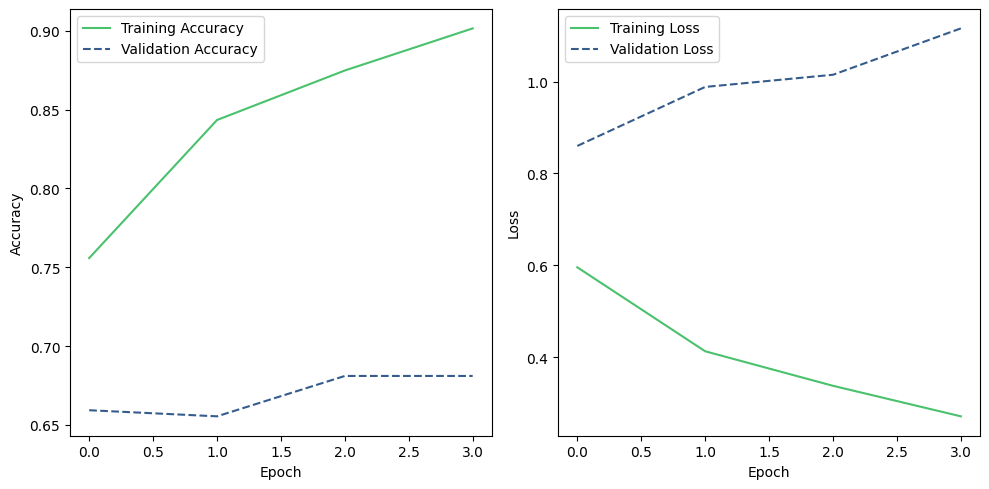

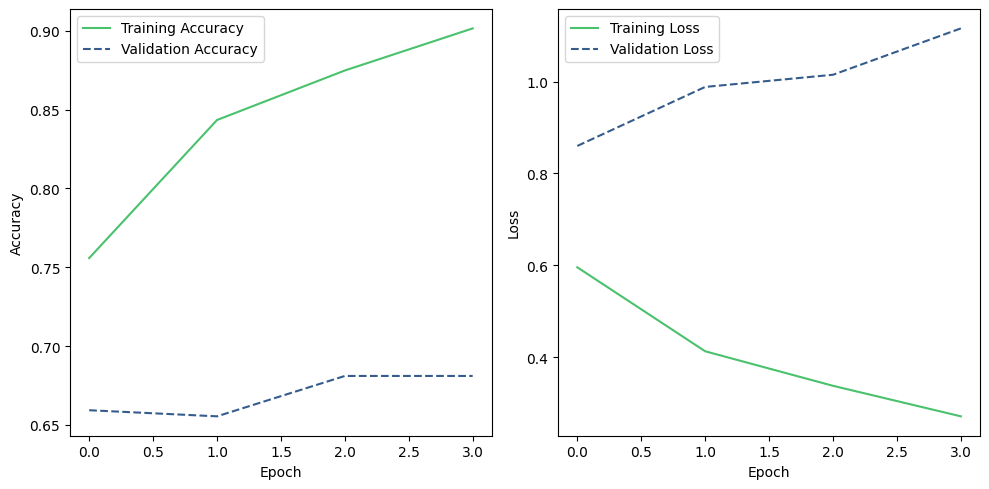

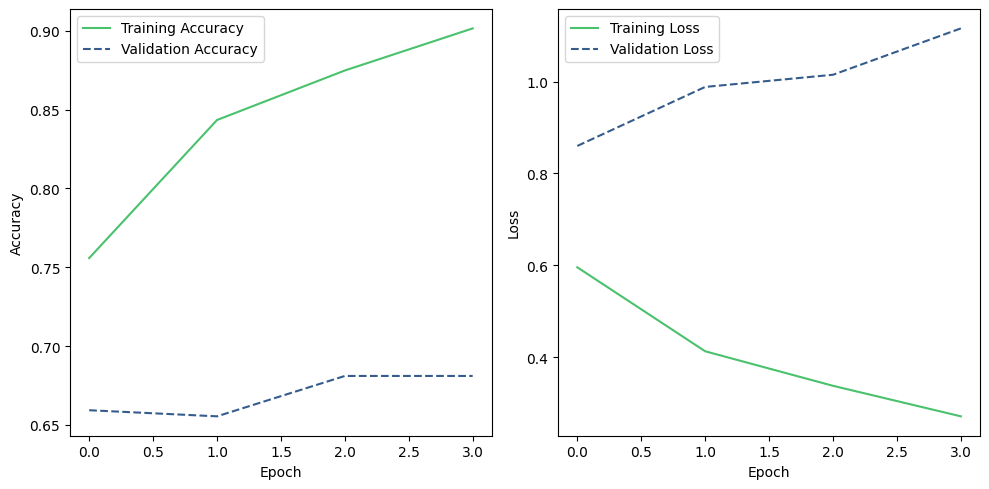

In [69]:
#Plot training history
training_history_bilstm_nodense = plot_training_history(history_oversampled_bilstm_nodense)

1078/1078 [==============================] - 461s 427ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67     11527
           1       0.55      0.69      0.61     11388
           2       0.75      0.62      0.68     11571

    accuracy                           0.65     34486
   macro avg       0.66      0.65      0.65     34486
weighted avg       0.66      0.65      0.65     34486

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67     11527
           1       0.55      0.69      0.61     11388
           2       0.75      0.62      0.68     11571

    accuracy                           0.65     34486
   macro avg       0.66      0.65      0.65     34486
weighted avg       0.66      0.65      0.65     34486



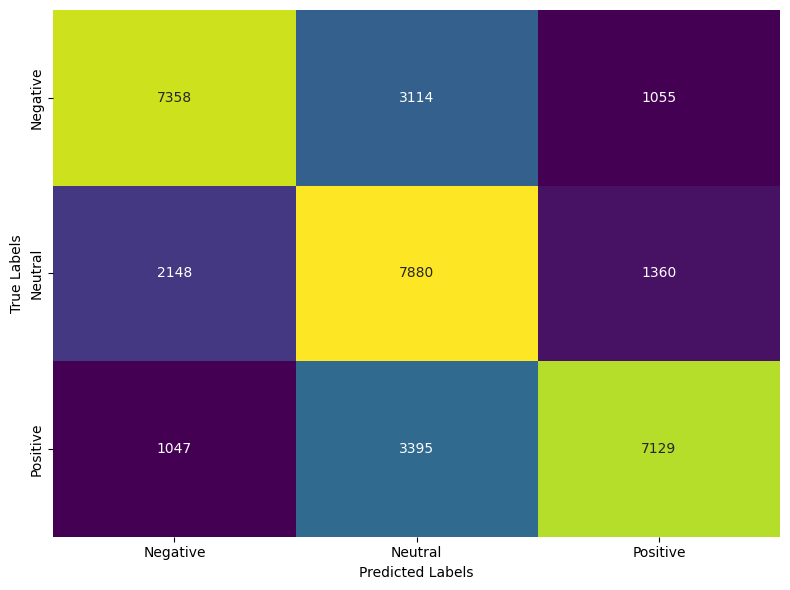

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67     11527
           1       0.55      0.69      0.61     11388
           2       0.75      0.62      0.68     11571

    accuracy                           0.65     34486
   macro avg       0.66      0.65      0.65     34486
weighted avg       0.66      0.65      0.65     34486



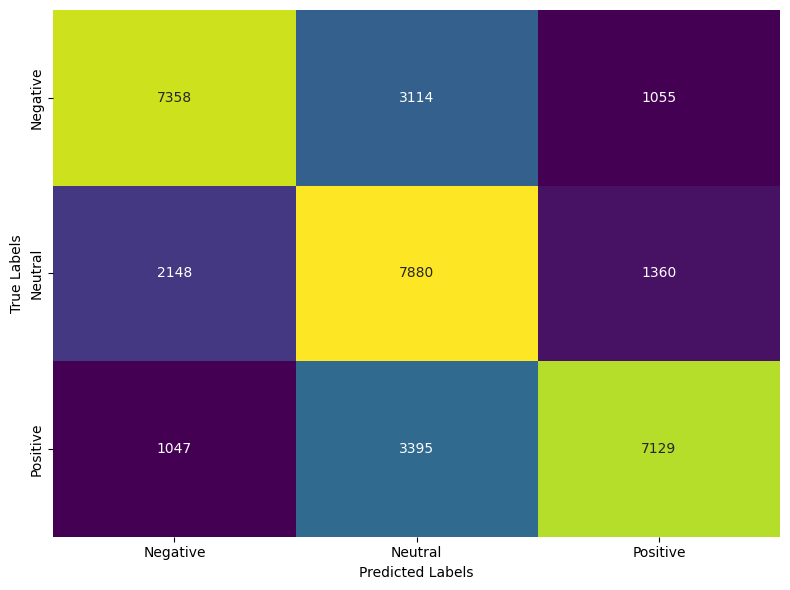

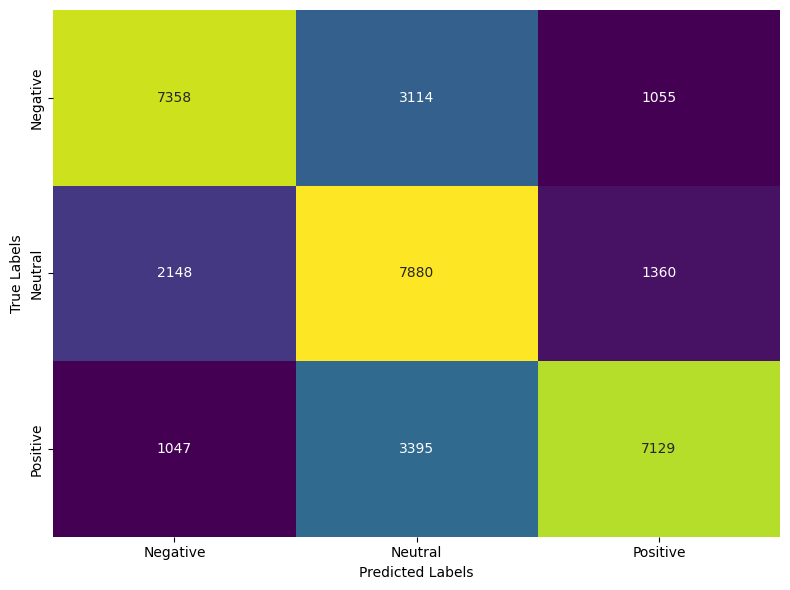

In [70]:
#Evaluate LSTM model on entire dataset
oversampled_bilstm_nodense = evaluate_dl_model(bilstm_model_all_nodense_instance, X_test_random_over, y_test_random_over)

Removing all dense layers, dropout between embedding layer and BiLSTM layer and flatten layer has shown no improvement regarding overfitting. Model stopped after 4 epochs.

In [71]:
#Create dict of remaining DL plots created in this notebook for use in report
figures_to_save_4 = {}

figures_to_save_4["./training_history_bilstm.png"] = training_history_bilstm
figures_to_save_4["./oversampled_bilstm.png"] = oversampled_bilstm
figures_to_save_4["./training_history_bilstm.png"] = training_history_bilstm_onedenselayer
figures_to_save_4["./oversampled_bilstm.png"] = oversampled_bilstm_onedenselayer
figures_to_save_4["./training_history_bilstm_nodense.png"] = training_history_bilstm_nodense
figures_to_save_4["./oversampled_bilstm_nodense.png"] = oversampled_bilstm_nodense

figures_to_save_4

{'./training_history_bilstm.png': <Figure size 1000x500 with 2 Axes>,
 './oversampled_bilstm.png': <Figure size 800x600 with 1 Axes>,
 './training_history_bilstm_nodense.png': <Figure size 1000x500 with 2 Axes>,
 './oversampled_bilstm_nodense.png': <Figure size 800x600 with 1 Axes>}

{'./training_history_bilstm.png': <Figure size 1000x500 with 2 Axes>,
 './oversampled_bilstm.png': <Figure size 800x600 with 1 Axes>,
 './training_history_bilstm_nodense.png': <Figure size 1000x500 with 2 Axes>,
 './oversampled_bilstm_nodense.png': <Figure size 800x600 with 1 Axes>}

{'./training_history_bilstm.png': <Figure size 1000x500 with 2 Axes>,
 './oversampled_bilstm.png': <Figure size 800x600 with 1 Axes>,
 './training_history_bilstm_nodense.png': <Figure size 1000x500 with 2 Axes>,
 './oversampled_bilstm_nodense.png': <Figure size 800x600 with 1 Axes>}

In [72]:
save_figures(figures_to_save_4)

**Summary of BiLSTM model**

Tried baseline BiLSTM architecture, only one dense/dropout layer and also without and dense/dropout layers and no dropout between embedding layer and BiLSTM layer. Still all overfitting. I think this is due to the dataset size itself and it is insufficient to effectively optimise a DL model.

**Summary of DL models**

Hyperparameter tuning and regularisation were explored for each model using randomised search and cross-validation (5-fold) to identify optimal parameters for running the models on the datasets. Randomly oversampled dataset was chosen for model comparison.

All of the models were trained for 30 epochs but with early stopping regularisation to ensure stopping (patience 3) as model overfits, however every model is overfitting to the validation data, regardless of simple vs more complex baseline architecture and hyperparameter tuning, batch size optimisation and experimenting with different regularisation approaches (including drop out and L1/L2 regularisation). This means that the model generalises poorly to new unseen data. 

Changing batch size from 64 to 32 did not reduce overfitting, reducing model complexity by removing dense/dropout layers, removing flatten layer, and removing dropout layer between embedding layer and GRU/LSTM/BiLSTM layer also saw no improvement. The number of GRU/LSTM/BiLSTM layers was not explored because with one layer all models were overfitting, therefore there was no benefit in increasing model complexity further.

Hyperparameter optimisation using randomised search only covered a small proportion of the parameter space, incresaed accuracy could have been achieved with grid search or increased iterations but there is a trade off with computational time, outise the time restrictions of this work.

In all likelihood, the random oversampling dataset (on the five diseases with the most reviews in Drugs.com dataset) is too small for the DL models and task complexity, requiring increased data for effective training. Data could also still be quite noisy with the models needing more samples to for meaningful learning.

Word embedding was used for feature engineering to enhance the DL model ability to learn from a smaller dataset, however this hasn't been successful due to overfitting observed.

**Summary of all models**

Oversampling the top five diseases drug review dataset using SMOTE was a really effective way of balancing the classes for ML models. RF achieved the best accuracy compared to multinomialNB. The precision, recall and F1-score for all classes was also excellent. The model outperformed the literature RF models performed on the drugs.com dataset.

All DL model architectures tested (GRU, LSTM, BiLSTM) overfit the random oversampled data. Hyperparameter optimisation, regularisation (L1 and L2 and dropout/number of dropout layers) and changing batch size also did not improve overfitting. The overfitting is likely due to the dataset size. 

Further work could involve exploring a transformer for sentiment classification, optimising RNN models using the original Drugs.com dataset but with weight adjustment during model optimisations to account for the class imbalances. Another alternative would be to supplement the imbalanced classes with data from a similar labelled dataset such as druglib.com to balance the classes, however this will increase the dataset size, increasing computational resource/time . Perhaps dimensionality reduction of the drugs.com dataset could also be explored using PCA or t-SNE to capture relevant features and enhance models ability to learn from a smaller dataset.